<a href="https://colab.research.google.com/github/Theflawlessone/Deforestation-Biodiversity-Analysis/blob/main/notebooks/Deforestation_on_Biodiversity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Project Overview
**Link to Google drive to access datasets:** https://drive.google.com/drive/folders/1c84LaLj2T4c4EN0RzQPdmtAh3UoFJjux?usp=sharing  
<br>**Notes when running project**
- We formatted it so you can use the table of contents easily we have main sections labeled below
- Sometimes runs will get stuck on the line "test for species_richness compared to estimate in merged dataset" in the "mann-whitney u testing", not sure why but just go to "preprocessing & cleaning" and then under "creating/editing new datafames" its labeled "create new columns: species_richness and te_count_species" rerun that snippet and it will work that second time! <br>

**Table of Contents:**
- Loading Datasets
- Preprocessing & Cleaning
- Exploratory Data Analysis (EDA)
- Statistical Analysis
- Models

**Summary of Datasets/Column Names**
This is the biodiversity kaggle dataset, there is a parks.csv and species.csv: https://www.kaggle.com/datasets/nationalparkservice/park-biodiversity
Columns/Rows:
  <br>> **For parks.csv:**
- Park Code,
- Park Name,
- State,
- Acres,
- Latitude,
- Longitude
<br>> **For species.csv**
- Species id,
- Park name,
- Category (mammal, bird, etc),
- Order (scientific order specialty),
- Family,
- Scientific Name,
- Common name,
- Record status,
- Occurrence,
- Nativeness,
- Abundance,
- Seasonality,
- Conservation status.
We also add species_richness (count of native species per state) and count_te_species (count of threatened/endangered species) early on.

This is the deforestation dataset we found: https://research.fs.usda.gov/programs/fia?utm_source=#data-and-tools
it looks at different states over different years (total just means all inventory years combined),
then 'estimate' is the forest area change for that state/year in acres
next is 'variance' which is the squared standard error (smaller number means more confidence)
next is 'plot_count' which is the number of sample plots used (so bigger number would be better here)
then se is standard error estimate and percentage just helps you find that actual se amount in acres.


---


# Data Loading

Cells related to loading datasets (paths preserved).

##Loading datsets

###Importing nessecary libraries

In [26]:
!pip install pingouin
!pip install fuzzywuzzy
!pip install us

In [27]:
# Consolidated imports (auto-extracted)
import pandas as pd
import matplotlib.pyplot as plt
import re
import geopandas as gpd
import seaborn as sns
import folium
import requests  #our initial map outline
from IPython.display import display
import numpy as np
from scipy.stats import chi2_contingency
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import kagglehub
import os, pandas as pd
import pingouin
import fuzzywuzzy
import us



# End of consolidated imports


###loading datasets and assigning names

In [28]:
!pip install gdown


# download from drive
!gdown 1g3IRypHA2EUwWaAkyD_-n7RzfLSJuXD5 -O parks.csv
!gdown 1Ya4KF7cCkYF7uRs67VNnGpJillBhA8e1 -O species.csv
!gdown 167-iGjrX0ox87N5eXVt-q_jzhtNsKQDY -O deforestation.csv

# load
parks = pd.read_csv("parks.csv")
species = pd.read_csv("species.csv")
deforestation = pd.read_csv("deforestation.csv")

print("Parks:", parks.shape)
print("Species:", species.shape)
print("Deforestation:", deforestation.shape)

Downloading...
From: https://drive.google.com/uc?id=1g3IRypHA2EUwWaAkyD_-n7RzfLSJuXD5
To: /content/parks.csv
100% 3.29k/3.29k [00:00<00:00, 9.66MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Ya4KF7cCkYF7uRs67VNnGpJillBhA8e1
To: /content/species.csv
100% 17.5M/17.5M [00:00<00:00, 48.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=167-iGjrX0ox87N5eXVt-q_jzhtNsKQDY
To: /content/deforestation.csv
100% 39.9k/39.9k [00:00<00:00, 42.8MB/s]
Parks: (56, 6)
Species: (119248, 14)
Deforestation: (416, 7)


/tmp/ipython-input-1270348409.py:11: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  species = pd.read_csv("species.csv")


####weather dataset

In [29]:
#weather dataset
path = kagglehub.dataset_download("justinrwong/average-monthly-temperature-by-us-state")

# find CSV file inside the dataset folder
for file in os.listdir(path):
    if file.endswith(".csv"):
        weather_path = os.path.join(path, file)
        break

weather = pd.read_csv(weather_path)


In [30]:
#checking which states are in it, 48 states are in it not hawaii and alaska
print(weather[weather["state"].str.contains("Alaska", case=False)])
print(weather[weather["state"].str.contains("Hawaii", case=False)])


Empty DataFrame
Columns: [Unnamed: 0, month, year, state, average_temp, monthly_mean_from_1901_to_2000, centroid_lon, centroid_lat]
Index: []
Empty DataFrame
Columns: [Unnamed: 0, month, year, state, average_temp, monthly_mean_from_1901_to_2000, centroid_lon, centroid_lat]
Index: []


###making sure import was successful

In [31]:
print("Weather:", weather.head(10))

Weather:    Unnamed: 0  month  year        state  average_temp  \
0           0      1  1950      Alabama          53.8   
1           1      1  1950      Arizona          39.6   
2           2      1  1950     Arkansas          45.6   
3           3      1  1950   California          39.4   
4           4      1  1950     Colorado          25.2   
5           5      1  1950  Connecticut          32.5   
6           6      1  1950     Delaware          42.0   
7           7      1  1950      Florida          64.4   
8           8      1  1950      Georgia          53.5   
9           9      1  1950        Idaho          20.4   

   monthly_mean_from_1901_to_2000  centroid_lon  centroid_lat  
0                            45.9    -86.828372     32.789832  
1                            41.1   -111.664418     34.293110  
2                            40.4    -92.439268     34.899745  
3                            42.7   -119.610699     37.246071  
4                            24.5   -105.54

In [32]:
print("Parks:", parks.head(10))

Parks:   Park Code                                   Park Name State   Acres  \
0      ACAD                        Acadia National Park    ME   47390   
1      ARCH                        Arches National Park    UT   76519   
2      BADL                      Badlands National Park    SD  242756   
3      BIBE                      Big Bend National Park    TX  801163   
4      BISC                      Biscayne National Park    FL  172924   
5      BLCA  Black Canyon of the Gunnison National Park    CO   32950   
6      BRCA                  Bryce Canyon National Park    UT   35835   
7      CANY                   Canyonlands National Park    UT  337598   
8      CARE                  Capitol Reef National Park    UT  241904   
9      CAVE              Carlsbad Caverns National Park    NM   46766   

   Latitude  Longitude  
0     44.35     -68.21  
1     38.68    -109.57  
2     43.75    -102.50  
3     29.25    -103.25  
4     25.65     -80.08  
5     38.57    -107.72  
6     37.57   

In [33]:
print("Species:", species.head(10))

Species:   Species ID             Park Name Category         Order      Family  \
0  ACAD-1000  Acadia National Park   Mammal  Artiodactyla    Cervidae   
1  ACAD-1001  Acadia National Park   Mammal  Artiodactyla    Cervidae   
2  ACAD-1002  Acadia National Park   Mammal     Carnivora     Canidae   
3  ACAD-1003  Acadia National Park   Mammal     Carnivora     Canidae   
4  ACAD-1004  Acadia National Park   Mammal     Carnivora     Canidae   
5  ACAD-1005  Acadia National Park   Mammal     Carnivora     Felidae   
6  ACAD-1006  Acadia National Park   Mammal     Carnivora     Felidae   
7  ACAD-1007  Acadia National Park   Mammal     Carnivora  Mephitidae   
8  ACAD-1008  Acadia National Park   Mammal     Carnivora  Mustelidae   
9  ACAD-1009  Acadia National Park   Mammal     Carnivora  Mustelidae   

          Scientific Name                                       Common Names  \
0             Alces alces                                              Moose   
1  Odocoileus virginianus  

In [34]:
print("Deforestation:", deforestation.head(10))

Deforestation:   INVENTORY_YEAR STATE_CODE      ESTIMATE      VARIANCE  PLOT_COUNT  \
0          Total      Total  8.671000e+07  1.311878e+10      114135   
1           2025      Total  7.325906e+04  5.094377e+07          95   
2           2024      Total  5.539804e+06  4.609719e+09        6884   
3           2023      Total  9.292361e+06  7.793832e+09       11052   
4           2022      Total  1.008284e+07  8.313889e+09       12805   
5           2021      Total  1.180935e+07  9.277511e+09       15544   
6           2020      Total  1.206263e+07  9.459020e+09       15969   
7           2019      Total  1.133330e+07  8.584997e+09       14918   
8           2018      Total  8.671880e+06  6.818620e+09       11325   
9           2017      Total  4.378821e+06  3.454059e+09        6066   

              SE  SE_PERCENT  
0  114537.258158    0.132092  
1    7137.490294    9.742809  
2   67894.909870    1.225583  
3   88282.684296    0.950057  
4   91180.529055    0.904314  
5   96319.835826 

###Check dataframe column datatypes

In [35]:
# weather.columns
# weather.dtypes

# parks.columns
# parks.dtypes

# species.columns
# species.dtypes

# deforestation.columns
# deforestation.dtypes

####%whos image

Downloading...
From: https://drive.google.com/uc?id=11oNNQE956jKJnIV2CjFYteQ_uOB7dnDZ
To: /content/whos.pdf
100% 579k/579k [00:00<00:00, 13.1MB/s]
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.11).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


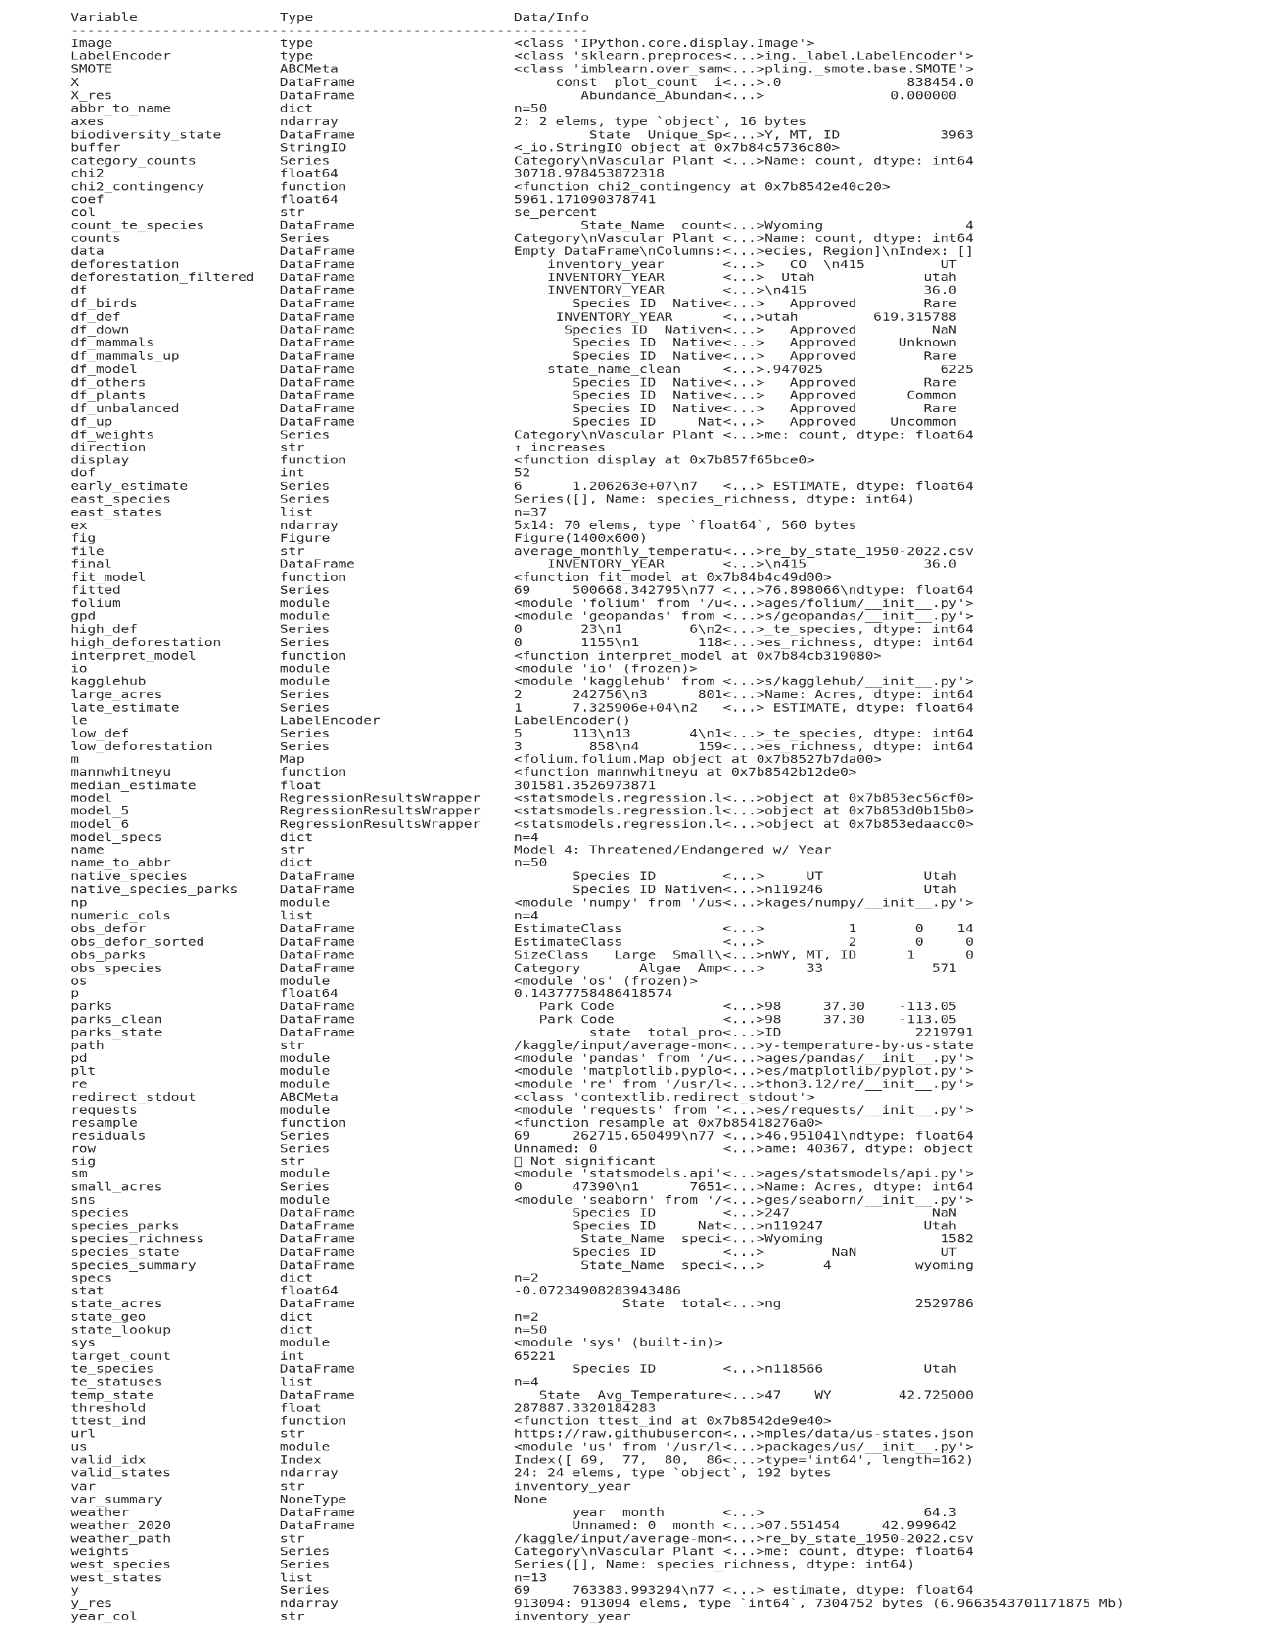

In [36]:
!gdown 11oNNQE956jKJnIV2CjFYteQ_uOB7dnDZ -O whos.pdf

!apt-get install -y poppler-utils  # only needs to run once
!pdftoppm whos.pdf whos -png

from IPython.display import Image
Image("whos-1.png")  # first page as image


### Mappings

#### Through matplot lib
<br>
Code below does not work due to the lack of federal funds on the website it is using (it was working now it is not) <br>
What is found when you go to the website: <br>
  NOTICE:
  Due to the lapse of federal funding, portions of this website will not be updated. Any inquiries submitted will not be answered until appropriations are enacted.

In [37]:
# US Census Bureau states shapefile (1:20m scale, includes states)
# url = "https://www2.census.gov/geo/tiger/GENZ2022/shp/cb_2022_us_state_20m.zip"

# us_states = gpd.read_file(url)

# Merge with species_summary
# merged = us_states.merge(species_summary, left_on="NAME", right_on="State_Name", how="left")

# Plot
# merged.plot(column="Species_richness", cmap="viridis", legend=True, figsize=(12,6))
# plt.title("Species richness by State")
# plt.show(

####through Folium and requests

In [38]:
parks = pd.read_csv("parks.csv")
species = pd.read_csv("species.csv")

#merge species by park/state
species_state = species.merge(parks[["Park Name", "State"]], on="Park Name", how="left")

#count unique species per state
biodiversity_state = (
    species_state.groupby("State")["Scientific Name"] #state is 2 letter abbreviation
    .nunique()
    .reset_index()
    .rename(columns={"Scientific Name": "Unique_Species"})
)

# 3. Load US States GeoJSON
url = "https://raw.githubusercontent.com/python-visualization/folium/main/examples/data/us-states.json"
state_geo = requests.get(url).json()

#map
m = folium.Map(location=[40, -95], zoom_start=4)

# Using Cloropleth
folium.Choropleth(
    geo_data=state_geo,
    name="choropleth",
    data=biodiversity_state,      #species per state
    columns=["State", "Unique_Species"],
    key_on="feature.id",       #match state abbreviation w state on map
    fill_color="YlGn",       #yellow/green scale
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Unique Species per State"
).add_to(m)

#markers
for _, row in parks.iterrows():
    folium.Marker(
        location=[row["Latitude"], row["Longitude"]],
        popup=f"<b>{row['Park Name']}</b><br>State: {row['State']}<br>Acres: {row['Acres']:,}",  #to see park info
        icon=folium.Icon(color="green", icon="tree", prefix="fa")
    ).add_to(m)

#save
m.save("biodiversity_map.html")
display(m)

/tmp/ipython-input-1112999957.py:2: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  species = pd.read_csv("species.csv")


####average temp/year graph - 2019/2022

In [39]:
# --- 1. Filter for year 2019 ---
weather_2019 = weather[weather ["year"] == 2019]

# --- 2. Compute average temperature per state ---
temp_state = (
    weather_2019.groupby("state")["average_temp"]
    .mean()
    .reset_index()
    .rename(columns={"state": "State", "average_temp": "Avg_Temperature"})
)

# Optional: ensure state abbreviations
if len(temp_state["State"].iloc[0]) > 2:
    temp_state["State"] = temp_state["State"].map(
        lambda x: us.states.lookup(x).abbr if us.states.lookup(x) else None
    )

# --- 3. Load US States GeoJSON ---
url = "https://raw.githubusercontent.com/python-visualization/folium/main/examples/data/us-states.json"
state_geo = requests.get(url).json()

# --- 4. Create Folium map ---
m = folium.Map(location=[40, -95], zoom_start=4)

# --- 5. Add Choropleth layer ---
folium.Choropleth(
    geo_data=state_geo,
    name="choropleth",
    data=temp_state,
    columns=["State", "Avg_Temperature"],
    key_on="feature.id",
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Average Temperature (°F) per State, 2019"
).add_to(m)

# --- 6. Optional: Add markers ---
for _, row in weather_2019.drop_duplicates("state").iterrows():
    folium.Marker(
        location=[row["centroid_lat"], row["centroid_lon"]],
        popup=f"<b>{row['state']}</b><br>Avg Temp: {row['average_temp']:.1f}°F",
        icon=folium.Icon(color="red", icon="thermometer-half", prefix="fa")
    ).add_to(m)

# --- 7. Save and show ---
m.save("temperature_map_2019.html")
display(m)

In [40]:
# --- 1. Filter for year 2020 ---
weather_2020 = weather[weather ["year"] == 2020]

# --- 2. Compute average temperature per state ---
temp_state = (
    weather_2020.groupby("state")["average_temp"]
    .mean()
    .reset_index()
    .rename(columns={"state": "State", "average_temp": "Avg_Temperature"})
)

# Optional: ensure state abbreviations
if len(temp_state["State"].iloc[0]) > 2:
    temp_state["State"] = temp_state["State"].map(
        lambda x: us.states.lookup(x).abbr if us.states.lookup(x) else None
    )

# --- 3. Load US States GeoJSON ---
url = "https://raw.githubusercontent.com/python-visualization/folium/main/examples/data/us-states.json"
state_geo = requests.get(url).json()

# --- 4. Create Folium map ---
m = folium.Map(location=[40, -95], zoom_start=4)

# --- 5. Add Choropleth layer ---
folium.Choropleth(
    geo_data=state_geo,
    name="choropleth",
    data=temp_state,
    columns=["State", "Avg_Temperature"],
    key_on="feature.id",
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Average Temperature (°F) per State, 2020"
).add_to(m)

# --- 6. Optional: Add markers ---
for _, row in weather_2020.drop_duplicates("state").iterrows():
    folium.Marker(
        location=[row["centroid_lat"], row["centroid_lon"]],
        popup=f"<b>{row['state']}</b><br>Avg Temp: {row['average_temp']:.1f}°F",
        icon=folium.Icon(color="red", icon="thermometer-half", prefix="fa")
    ).add_to(m)

# --- 7. Save and show ---
m.save("temperature_map_2020.html")
display(m)


In [41]:
# --- 1. Filter for year 2021 ---
weather_2021 = weather[weather ["year"] == 2021]

# --- 2. Compute average temperature per state ---
temp_state = (
    weather_2021.groupby("state")["average_temp"]
    .mean()
    .reset_index()
    .rename(columns={"state": "State", "average_temp": "Avg_Temperature"})
)

# Optional: ensure state abbreviations
if len(temp_state["State"].iloc[0]) > 2:
    temp_state["State"] = temp_state["State"].map(
        lambda x: us.states.lookup(x).abbr if us.states.lookup(x) else None
    )

# --- 3. Load US States GeoJSON ---
url = "https://raw.githubusercontent.com/python-visualization/folium/main/examples/data/us-states.json"
state_geo = requests.get(url).json()

# --- 4. Create Folium map ---
m = folium.Map(location=[40, -95], zoom_start=4)

# --- 5. Add Choropleth layer ---
folium.Choropleth(
    geo_data=state_geo,
    name="choropleth",
    data=temp_state,
    columns=["State", "Avg_Temperature"],
    key_on="feature.id",
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Average Temperature (°F) per State, 2021"
).add_to(m)

# --- 6. Optional: Add markers ---
for _, row in weather_2021.drop_duplicates("state").iterrows():
    folium.Marker(
        location=[row["centroid_lat"], row["centroid_lon"]],
        popup=f"<b>{row['state']}</b><br>Avg Temp: {row['average_temp']:.1f}°F",
        icon=folium.Icon(color="red", icon="thermometer-half", prefix="fa")
    ).add_to(m)

# --- 7. Save and show ---
m.save("temperature_map_2021.html")
display(m)

In [42]:
# --- 1. Filter for year 2022 ---
weather_2022 = weather[weather ["year"] == 2022]

# --- 2. Compute average temperature per state ---
temp_state = (
    weather_2022.groupby("state")["average_temp"]
    .mean()
    .reset_index()
    .rename(columns={"state": "State", "average_temp": "Avg_Temperature"})
)

# Optional: ensure state abbreviations
if len(temp_state["State"].iloc[0]) > 2:
    temp_state["State"] = temp_state["State"].map(
        lambda x: us.states.lookup(x).abbr if us.states.lookup(x) else None
    )

# --- 3. Load US States GeoJSON ---
url = "https://raw.githubusercontent.com/python-visualization/folium/main/examples/data/us-states.json"
state_geo = requests.get(url).json()

# --- 4. Create Folium map ---
m = folium.Map(location=[40, -95], zoom_start=4)

# --- 5. Add Choropleth layer ---
folium.Choropleth(
    geo_data=state_geo,
    name="choropleth",
    data=temp_state,
    columns=["State", "Avg_Temperature"],
    key_on="feature.id",
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Average Temperature (°F) per State, 2022"
).add_to(m)

# --- 6. Optional: Add markers ---
for _, row in weather_2020.drop_duplicates("state").iterrows():
    folium.Marker(
        location=[row["centroid_lat"], row["centroid_lon"]],
        popup=f"<b>{row['state']}</b><br>Avg Temp: {row['average_temp']:.1f}°F",
        icon=folium.Icon(color="red", icon="thermometer-half", prefix="fa")
    ).add_to(m)

# --- 7. Save and show ---
m.save("temperature_map_2022.html")
display(m)

In [43]:
import pandas as pd
import folium
import requests
import us
from IPython.display import HTML

# --- Helper Function ---
def get_temp_data(weather, year):
    df = weather[weather["year"] == year]
    temp_state = (
        df.groupby("state")["average_temp"]
        .mean()
        .reset_index()
        .rename(columns={"state": "State", "average_temp": "Avg_Temperature"})
    )
    if len(temp_state["State"].iloc[0]) > 2:
        temp_state["State"] = temp_state["State"].map(
            lambda x: us.states.lookup(x).abbr if us.states.lookup(x) else None
        )
    return temp_state

# --- Load GeoJSON ---
url = "https://raw.githubusercontent.com/python-visualization/folium/main/examples/data/us-states.json"
state_geo = requests.get(url).json()

# --- Generate maps for each year ---
maps = {}
for year in [2019, 2020, 2021, 2022]:
    temp_state = get_temp_data(weather, year)
    m = folium.Map(location=[37.8, -96], zoom_start=4)
    folium.Choropleth(
        geo_data=state_geo,
        data=temp_state,
        columns=["State", "Avg_Temperature"],
        key_on="feature.id",
        fill_color="YlOrRd",
        fill_opacity=0.8,
        line_opacity=0.3,
        legend_name=f"Average Temperature (°F) - {year}"
    ).add_to(m)
    maps[year] = m._repr_html_()  # store HTML representation

# --- Combine all four maps into a single HTML grid ---
html = f"""
<h2 style="text-align:center;">Average State Temperature (°F) per Year</h2>
<div style="display:grid; grid-template-columns: 1fr 1fr; gap:10px;">
  <div>{maps[2019]}</div>
  <div>{maps[2020]}</div>
  <div>{maps[2021]}</div>
  <div>{maps[2022]}</div>
</div>
"""

# --- Save combined HTML file ---
with open("temperature_maps_2019_2022.html", "w") as f:
    f.write(html)

# --- Display in Jupyter Notebook ---
HTML(html)


#####seasonal temps 2019/2022

In [44]:
import pandas as pd
import folium
import requests
import us
from IPython.display import HTML

# --- 1. Define Seasons ---
def get_season(month):
    if month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    elif month in [9, 10, 11]:
        return "Autumn"
    else:
        return "Winter"

# --- 2. Filter for Year 2019 ---
weather_2019 = weather[weather["year"] == 2019].copy()

# Check if any data exists
if weather_2019.empty:
    raise ValueError("No weather data available for 2019.")

weather_2019["Season"] = weather_2019["month"].apply(get_season)

# --- 3. Compute Average Temperature per State per Season ---
seasonal_temps = (
    weather_2019.groupby(["state", "Season"])["average_temp"]
    .mean()
    .reset_index()
    .rename(columns={"state": "State", "average_temp": "Avg_Temperature"})
)

# --- 4. Ensure State Abbreviations (for GeoJSON matching) ---
if not seasonal_temps.empty and len(seasonal_temps["State"].iloc[0]) > 2:
    seasonal_temps["State"] = seasonal_temps["State"].map(
        lambda x: us.states.lookup(x).abbr if us.states.lookup(x) else None
    )

# Drop any rows where the state abbreviation couldn't be found
seasonal_temps.dropna(subset=["State"], inplace=True)

# --- 5. Load US States GeoJSON ---
url = "https://raw.githubusercontent.com/python-visualization/folium/main/examples/data/us-states.json"
state_geo = requests.get(url).json()

# --- 6. Helper Function to Create Seasonal Map ---
def make_map(df, season):
    temp_state = df[df["Season"] == season]
    m = folium.Map(location=[37.8, -96], zoom_start=4)
    folium.Choropleth(
        geo_data=state_geo,
        data=temp_state,
        columns=["State", "Avg_Temperature"],
        key_on="feature.id",
        fill_color="YlOrRd",
        fill_opacity=0.8,
        line_opacity=0.3,
        legend_name=f"Average Temperature (°F) - {season} 2019"
    ).add_to(m)
    return m._repr_html_()

# --- 7. Create Maps for All Seasons ---
maps = {}
for season in ["Spring", "Summer", "Autumn", "Winter"]:
    maps[season] = make_map(seasonal_temps, season)

# --- 8. Combine into One HTML Dashboard ---
html = f"""
<h2 style="text-align:center;">Average State Temperature (°F) by Season - 2019</h2>
<div style="display:grid; grid-template-columns: 1fr 1fr; gap:10px;">
  <div>{maps['Spring']}</div>
  <div>{maps['Summer']}</div>
  <div>{maps['Autumn']}</div>
  <div>{maps['Winter']}</div>
</div>
"""

# --- 9. Save Combined HTML File ---
with open("temperature_maps_seasons_2019.html", "w") as f:
    f.write(html)

# --- 10. Display in Notebook ---
HTML(html)


In [45]:
print(weather_2019.columns)


Index(['Unnamed: 0', 'month', 'year', 'state', 'average_temp',
       'monthly_mean_from_1901_to_2000', 'centroid_lon', 'centroid_lat',
       'Season'],
      dtype='object')


In [46]:
import pandas as pd
import folium
import requests
import us
from IPython.display import HTML

# --- 1. Define Seasons ---
def get_season(month):
    if month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    elif month in [9, 10, 11]:
        return "Autumn"
    else:
        return "Winter"

# --- 2. Filter for Year 2019 ---
weather_2020 = weather[weather["year"] == 2020].copy()
weather_2020["Season"] = weather_2020["month"].apply(get_season)

# --- 3. Compute Average Temperature per State per Season ---
seasonal_temps = (
    weather_2020.groupby(["state", "Season"])["average_temp"]
    .mean()
    .reset_index()
    .rename(columns={"state": "State", "average_temp": "Avg_Temperature"})
)

# --- 4. Ensure State Abbreviations (for GeoJSON matching) ---
if len(seasonal_temps["State"].iloc[0]) > 2:
    seasonal_temps["State"] = seasonal_temps["State"].map(
        lambda x: us.states.lookup(x).abbr if us.states.lookup(x) else None
    )

# --- 5. Load US States GeoJSON ---
url = "https://raw.githubusercontent.com/python-visualization/folium/main/examples/data/us-states.json"
state_geo = requests.get(url).json()

# --- 6. Helper Function to Create Seasonal Map ---
def make_map(df, season):
    temp_state = df[df["Season"] == season]
    m = folium.Map(location=[37.8, -96], zoom_start=4)
    folium.Choropleth(
        geo_data=state_geo,
        data=temp_state,
        columns=["State", "Avg_Temperature"],
        key_on="feature.id",
        fill_color="YlOrRd",
        fill_opacity=0.8,
        line_opacity=0.3,
        legend_name=f"Average Temperature (°F) - {season} 2020"
    ).add_to(m)
    return m._repr_html_()

# --- 7. Create Maps for All Seasons ---
maps = {}
for season in ["Spring", "Summer", "Autumn", "Winter"]:
    maps[season] = make_map(seasonal_temps, season)

# --- 8. Combine into One HTML Dashboard ---
html = f"""
<h2 style="text-align:center;">Average State Temperature (°F) by Season - 2020</h2>
<div style="display:grid; grid-template-columns: 1fr 1fr; gap:10px;">
  <div>{maps['Spring']}</div>
  <div>{maps['Summer']}</div>
  <div>{maps['Autumn']}</div>
  <div>{maps['Winter']}</div>
</div>
"""

# --- 9. Save Combined HTML File ---
with open("temperature_maps_seasons_2020.html", "w") as f:
    f.write(html)

# --- 10. Display in Notebook ---
HTML(html)


In [47]:
import us
import requests
import folium
from IPython.display import HTML

# --- 4. Ensure Full State Names (for GeoJSON matching) ---
def to_full_state_name(x):
    s = us.states.lookup(x)
    return s.name if s else x  # Convert abbrev -> full name

seasonal_temps["State"] = seasonal_temps["State"].apply(to_full_state_name)

# --- 5. Load US States GeoJSON ---
url = "https://raw.githubusercontent.com/python-visualization/folium/main/examples/data/us-states.json"
state_geo = requests.get(url).json()

# --- 6. Helper Function to Create Seasonal Map ---
def make_map(df, season):
    temp_state = df[df["Season"] == season]
    m = folium.Map(location=[37.8, -96], zoom_start=4)
    folium.Choropleth(
        geo_data=state_geo,
        data=temp_state,
        columns=["State", "Avg_Temperature"],
        key_on="feature.properties.name",  # matches full state names
        fill_color="YlOrRd",
        fill_opacity=0.8,
        line_opacity=0.3,
        nan_fill_color="white",
        legend_name=f"Average Temperature (°F) - {season} 2021"
    ).add_to(m)
    return m._repr_html_()

# --- 7. Create Maps for All Seasons ---
maps = {}
for season in ["Spring", "Summer", "Autumn", "Winter"]:
    maps[season] = make_map(seasonal_temps, season)

# --- 8. Combine into One HTML Dashboard ---
html = f"""
<h2 style="text-align:center;">Average State Temperature (°F) by Season - 2021</h2>
<div style="display:grid; grid-template-columns: 1fr 1fr; gap:10px;">
  <div>{maps['Spring']}</div>
  <div>{maps['Summer']}</div>
  <div>{maps['Autumn']}</div>
  <div>{maps['Winter']}</div>
</div>
"""

# --- 9. Save Combined HTML File ---
with open("temperature_maps_seasons_2021.html", "w") as f:
    f.write(html)

# --- 10. Display in Notebook ---
HTML(html)


####species counts and temps

In [48]:
us_state_abbrev = {
    "AL": "Alabama", "AK": "Alaska", "AZ": "Arizona", "AR": "Arkansas", "CA": "California",
    "CO": "Colorado", "CT": "Connecticut", "DE": "Delaware", "FL": "Florida", "GA": "Georgia",
    "HI": "Hawaii", "ID": "Idaho", "IL": "Illinois", "IN": "Indiana", "IA": "Iowa",
    "KS": "Kansas", "KY": "Kentucky", "LA": "Louisiana", "ME": "Maine", "MD": "Maryland",
    "MA": "Massachusetts", "MI": "Michigan", "MN": "Minnesota", "MS": "Mississippi", "MO": "Missouri",
    "MT": "Montana", "NE": "Nebraska", "NV": "Nevada", "NH": "New Hampshire", "NJ": "New Jersey",
    "NM": "New Mexico", "NY": "New York", "NC": "North Carolina", "ND": "North Dakota", "OH": "Ohio",
    "OK": "Oklahoma", "OR": "Oregon", "PA": "Pennsylvania", "RI": "Rhode Island", "SC": "South Carolina",
    "SD": "South Dakota", "TN": "Tennessee", "TX": "Texas", "UT": "Utah", "VT": "Vermont",
    "VA": "Virginia", "WA": "Washington", "WV": "West Virginia", "WI": "Wisconsin", "WY": "Wyoming"
}

#count_te_species["State"] = count_te_species["State"].map(us_state_abbrev).fillna(count_te_species["State"])

# --- Biodiversity per state ---
species_state = species.merge(parks[["Park Name", "State"]], on="Park Name", how="left")
biodiversity_state = (
    species_state.groupby("State")["Scientific Name"]
    .nunique()
    .reset_index()
    .rename(columns={"Scientific Name": "Unique_Species"})
)

# --- 2. Temperature per state (year 2021) ---
weather_2020 = weather[weather["year"] == 2020]
temp_state = (
    weather_2020.groupby("state")["average_temp"]
    .mean()
    .reset_index()
    .rename(columns={"state": "State", "average_temp": "Avg_Temperature"})
)

# Convert full names → abbreviations if needed
if len(temp_state["State"].iloc[0]) > 2:
    temp_state["State"] = temp_state["State"].map(
        lambda x: us.states.lookup(x).abbr if us.states.lookup(x) else None
    )

# --- 3. Load GeoJSON ---
url = "https://raw.githubusercontent.com/python-visualization/folium/main/examples/data/us-states.json"
state_geo = requests.get(url).json()

# --- 4. Create base map ---
m = folium.Map(location=[40, -95], zoom_start=4, tiles="CartoDB positron")

# --- 5. Add biodiversity layer ---
folium.Choropleth(
    geo_data=state_geo,
    name="Biodiversity (Unique Species)",
    data=biodiversity_state,
    columns=["State", "Unique_Species"],
    key_on="feature.id",
    fill_color="YlGn",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Unique Species per State"
).add_to(m)

# --- 6. Add temperature layer ---
folium.Choropleth(
    geo_data=state_geo,
    name="Average Temperature (°F, 2020)",
    data=temp_state,
    columns=["State", "Avg_Temperature"],
    key_on="feature.id",
    fill_color="YlOrRd",
    fill_opacity=0.6,
    line_opacity=0.3,
    legend_name="Average Temperature (°F, 2020)"
).add_to(m)

# --- 7. Add park markers ---
for _, row in parks.iterrows():
    folium.Marker(
        location=[row["Latitude"], row["Longitude"]],
        popup=f"<b>{row['Park Name']}</b><br>State: {row['State']}<br>Acres: {row['Acres']:,}",
        icon=folium.Icon(color="green", icon="tree", prefix="fa")
    ).add_to(m)

# --- 8. Add temperature markers (optional) ---
for _, row in weather_2020.drop_duplicates("state").iterrows():
    folium.Marker(
        location=[row["centroid_lat"], row["centroid_lon"]],
        popup=f"<b>{row['state']}</b><br>Avg Temp: {row['average_temp']:.1f}°F",
        icon=folium.Icon(color="red", icon="thermometer-half", prefix="fa")
    ).add_to(m)

# --- 9. Layer control ---
folium.LayerControl(collapsed=False).add_to(m)

# --- 10. Save and show ---
m.save("combined_biodiversity_temperature_map.html")
display(m)

####threatened/endangered species count

In [49]:
import pandas as pd

# Load both CSVs
species = pd.read_csv("species.csv", low_memory=False)
parks = pd.read_csv("parks.csv", low_memory=False)

# --- 1. Merge to get states ---
species_states = species.merge(
    parks[["Park Name", "State"]],
    on="Park Name",
    how="left"
)

# --- 2. Split multi-state entries like "TN, NC" into separate rows ---
species_states["State"] = species_states["State"].str.split(",")
species_states = species_states.explode("State")
species_states["State"] = species_states["State"].str.strip()

# --- 3. Keep only State and Conservation Status ---
species_states = species_states[["State", "Conservation Status"]]

# --- 4. Print unique state count and a sample ---
unique_states = species_states["State"].dropna().unique()
print(f"Number of unique states found: {len(unique_states)}")
print("States present:", sorted(unique_states.tolist()))
print("\nSample of merged data:")
print(species_states.head(10))

# --- 5. Create full list of 50 states for completeness ---
us_states = [
    'AL','AK','AZ','AR','CA','CO','CT','DE','FL','GA','HI','ID','IL','IN','IA','KS',
    'KY','LA','ME','MD','MA','MI','MN','MS','MO','MT','NE','NV','NH','NJ','NM','NY',
    'NC','ND','OH','OK','OR','PA','RI','SC','SD','TN','TX','UT','VT','VA','WA','WV','WI','WY'
]

# Make sure all states are represented — fill in missing ones with NaN
missing = set(us_states) - set(species_states["State"].dropna().unique())
missing_df = pd.DataFrame({"State": list(missing), "Conservation Status": None})
species_states_full = pd.concat([species_states, missing_df], ignore_index=True)

print(f"\n✅ Final dataset includes all {species_states_full['State'].nunique()} states.")


Number of unique states found: 27
States present: ['AK', 'AR', 'AZ', 'CA', 'CO', 'FL', 'HI', 'ID', 'KY', 'ME', 'MI', 'MN', 'MT', 'NC', 'ND', 'NM', 'NV', 'OH', 'OR', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'WA', 'WY']

Sample of merged data:
  State Conservation Status
0    ME                 NaN
1    ME                 NaN
2    ME  Species of Concern
3    ME          Endangered
4    ME                 NaN
5    ME                 NaN
6    ME                 NaN
7    ME                 NaN
8    ME                 NaN
9    ME                 NaN

✅ Final dataset includes all 50 states.


In [50]:
# Define which statuses count as threatened/endangered
te_statuses = ["Threatened", "Proposed Endangered", "Proposed Threatened", "Endangered"]

# Filter only TE species
te_species = species_states_full[species_states_full["Conservation Status"].isin(te_statuses)]

# Count unique occurrences per state
te_count_species = (
    te_species.groupby("State")["Conservation Status"]
    .count()
    .reset_index()
    .rename(columns={"Conservation Status": "count_te_species"})
)

print(te_count_species.head())
print(f"\nTotal states with at least one TE species: {len(te_count_species)}")


  State  count_te_species
0    AK                45
1    AR                 6
2    AZ                23
3    CA               141
4    CO                17

Total states with at least one TE species: 27


In [51]:
import pandas as pd
import folium
import requests
from fuzzywuzzy import process

# --- 1. Filter for Threatened/Endangered statuses ---
te_statuses = ["Threatened", "Proposed Endangered", "Proposed Threatened", "Endangered"]
species_filtered = species[species["Conservation Status"].isin(te_statuses)].copy()

# --- 2. Fuzzy match park names ---
def match_park_name(park_name, park_list):
    match, score = process.extractOne(park_name, park_list)
    return match if score > 80 else None

parks_list = parks["Park Name"].unique()
species_filtered["Matched Park Name"] = species_filtered["Park Name"].apply(lambda x: match_park_name(x, parks_list))

# --- 3. Merge to get state info ---
species_parks = pd.merge(
    species_filtered,
    parks[["Park Name", "State"]],
    left_on="Matched Park Name",
    right_on="Park Name",
    how="left"
)

# --- 4. Split multi-state entries like "TN, NC" ---
species_parks = species_parks.dropna(subset=["State"])
species_parks["State"] = species_parks["State"].str.split(",")
species_parks = species_parks.explode("State")
species_parks["State"] = species_parks["State"].str.strip()

# --- 5. Add mock Year if missing ---
if "Year" not in species_parks.columns:
    import numpy as np
    species_parks["Year"] = np.random.choice([2019, 2020, 2021], size=len(species_parks))

# --- 6. State abbreviations ---
us_state_abbrev = {
    "AL": "Alabama", "AK": "Alaska", "AZ": "Arizona", "AR": "Arkansas", "CA": "California",
    "CO": "Colorado", "CT": "Connecticut", "DE": "Delaware", "FL": "Florida", "GA": "Georgia",
    "HI": "Hawaii", "ID": "Idaho", "IL": "Illinois", "IN": "Indiana", "IA": "Iowa",
    "KS": "Kansas", "KY": "Kentucky", "LA": "Louisiana", "ME": "Maine", "MD": "Maryland",
    "MA": "Massachusetts", "MI": "Michigan", "MN": "Minnesota", "MS": "Mississippi", "MO": "Missouri",
    "MT": "Montana", "NE": "Nebraska", "NV": "Nevada", "NH": "New Hampshire", "NJ": "New Jersey",
    "NM": "New Mexico", "NY": "New York", "NC": "North Carolina", "ND": "North Dakota", "OH": "Ohio",
    "OK": "Oklahoma", "OR": "Oregon", "PA": "Pennsylvania", "RI": "Rhode Island", "SC": "South Carolina",
    "SD": "South Dakota", "TN": "Tennessee", "TX": "Texas", "UT": "Utah", "VT": "Vermont",
    "VA": "Virginia", "WA": "Washington", "WV": "West Virginia", "WI": "Wisconsin", "WY": "Wyoming"
}

species_parks["State"] = species_parks["State"].map(us_state_abbrev).fillna(species_parks["State"])

# --- 7. Load U.S. GeoJSON ---
geo_url = "https://raw.githubusercontent.com/python-visualization/folium/main/examples/data/us-states.json"
geo_data = requests.get(geo_url).json()

# --- 8. Function to make a single map ---
def create_te_map(year):
    df_year = (
        species_parks[species_parks["Year"] == year]
        .groupby("State")["Species ID"]
        .nunique()
        .reset_index()
        .rename(columns={"Species ID": "count_te_species"})
    )

    all_states = pd.DataFrame(list(us_state_abbrev.values()), columns=["State"])
    df_year = pd.merge(all_states, df_year, on="State", how="left").fillna({"count_te_species": 0})

    m = folium.Map(location=[37.8, -96], zoom_start=4, tiles="cartodb positron")
    bins = [0, 1, 5, 10, 20, 50, 100, 150]

    choropleth = folium.Choropleth(
        geo_data=geo_data,
        data=df_year,
        columns=["State", "count_te_species"],
        key_on="feature.properties.name",
        fill_color="YlOrRd",
        fill_opacity=0.85,
        line_opacity=0.3,
        nan_fill_color="#f0f0f0",
        legend_name=f"Threatened/Endangered Species Count ({year})",
        bins=bins
    ).add_to(m)

    choropleth.geojson.add_child(
        folium.features.GeoJsonTooltip(fields=["name"], aliases=["State:"], sticky=False)
    )

    return m

# --- 9. Create and display each map separately ---
m_2019 = create_te_map(2019)
m_2020 = create_te_map(2020)
m_2021 = create_te_map(2021)

display(m_2019)
display(m_2020)
display(m_2021)





/usr/local/lib/python3.12/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


####heatmap of environmental variables and species counts

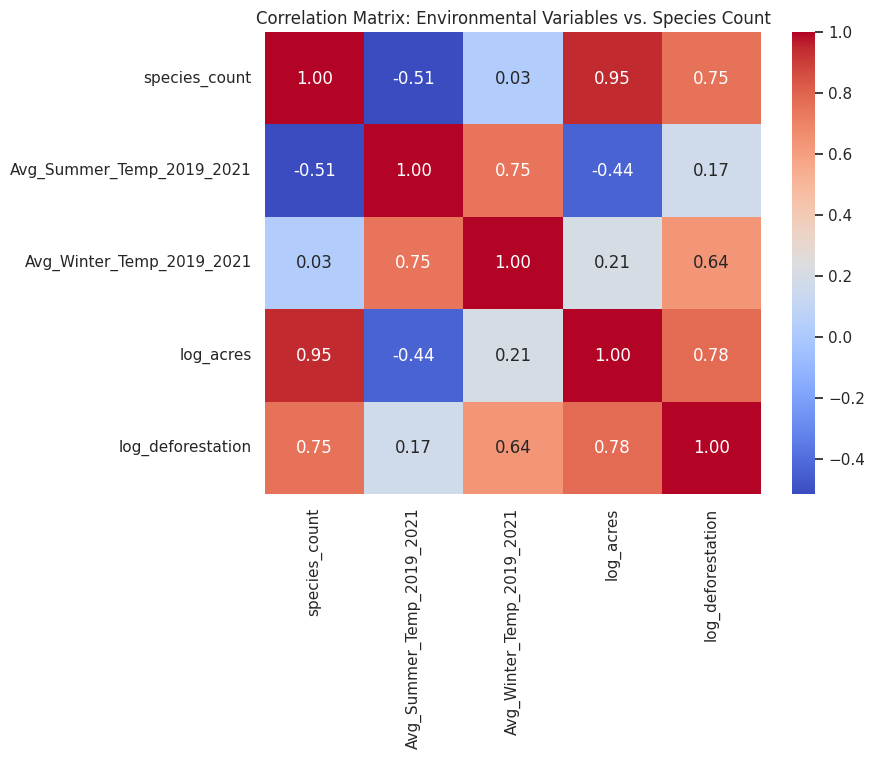

In [144]:
# Example species_summary dataframe
species_summary = pd.DataFrame({
    "State_Name": ["Alaska", "Arizona", "Arkansas", "California", "Colorado"],
    "species_richness": [8864, 4687, 1155, 10083, 4506],
    "count_te_species": [45, 23, 6, 100, 17],
    "State_Name_clean": ["alaska", "arizona", "arkansas", "california", "colorado"],
    # Example environmental variables (numeric)
    "Avg_Summer_Temp_2019_2021": [50.0, 75.2, 70.1, 65.5, 60.0],
    "Avg_Winter_Temp_2019_2021": [15.0, 40.2, 35.1, 50.5, 30.0],
    "log_acres": [10.2, 8.5, 7.0, 12.1, 9.5],
    "log_deforestation": [1.5, 2.1, 0.8, 3.0, 1.2]
})

# Step 1: Create species_count column
species_summary['species_count'] = species_summary['species_richness']  # or count_te_species

# Step 2: Select species_count + environmental variables
env_vars = ["Avg_Summer_Temp_2019_2021", "Avg_Winter_Temp_2019_2021", "log_acres", "log_deforestation"]
corr_data = species_summary[["species_count"] + env_vars]

# Step 3: Compute correlation matrix
corr_matrix = corr_data.corr()

# Step 4: Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix: Environmental Variables vs. Species Count")
plt.show()


# Step 5: Save Combined HTML File
with open("Environmental_vs_SC.html", "w") as f:
    f.write(html)

# Step 6: Display in Notebook ---
HTML(html)

# Preprocessing & Cleaning

Data cleaning and preprocessing steps.

###Checking for NaN values, removing if any, and checking dataframe shapes

In [53]:
weather[weather.isna().any(axis=1)]
weather.dropna(axis=0)
weather.shape

(41856, 8)

In [54]:
deforestation[deforestation.isna().any(axis=1)]
deforestation.dropna(axis=0)
deforestation.shape

(416, 7)

In [55]:
parks[parks.isna().any(axis=1)]
parks.dropna(axis=0)
parks.shape

(56, 6)

In [56]:
species.dropna(axis=0)
species[species.isna().any(axis=1)]
species.isna().sum()
species.shape

(119248, 14)

###Checking for duplicates, removing if any

In [57]:
weather.duplicated().sum()
weather.drop_duplicates(inplace=True)
weather.shape

(41856, 8)

In [58]:
parks.duplicated().sum()
parks.drop_duplicates(inplace=True)
parks.shape

(56, 6)

In [59]:
deforestation.duplicated().sum()
deforestation.drop_duplicates(inplace=True)
deforestation.shape

(416, 7)

In [60]:
species.duplicated().sum()
species.drop_duplicates(inplace=True)
species.shape

(119248, 14)

###Creating/editing new dataframes

####keeping columns we will need, removing others

In [61]:
weather.columns

weather = weather[['year', 'month', 'state', 'average_temp', 'monthly_mean_from_1901_to_2000']]
weather.head()

year  month       state  average_temp  monthly_mean_from_1901_to_2000
0  1950      1     Alabama          53.8                            45.9
1  1950      1     Arizona          39.6                            41.1
2  1950      1    Arkansas          45.6                            40.4
3  1950      1  California          39.4                            42.7
4  1950      1    Colorado          25.2                            24.5

In [62]:
species.columns

species = species[['Species ID', 'Nativeness', 'Conservation Status', 'Park Name', 'Common Names', 'Occurrence', 'Seasonality', 'Category', 'Record Status', 'Abundance']]
species.head()

Species ID  Nativeness Conservation Status             Park Name  \
0  ACAD-1000      Native                 NaN  Acadia National Park   
1  ACAD-1001      Native                 NaN  Acadia National Park   
2  ACAD-1002  Not Native  Species of Concern  Acadia National Park   
3  ACAD-1003      Native          Endangered  Acadia National Park   
4  ACAD-1004     Unknown                 NaN  Acadia National Park   

                                        Common Names     Occurrence  \
0                                              Moose        Present   
1  Northern White-Tailed Deer, Virginia Deer, Whi...        Present   
2                             Coyote, Eastern Coyote        Present   
3        Eastern Timber Wolf, Gray Wolf, Timber Wolf  Not Confirmed   
4  Black Fox, Cross Fox, Eastern Red Fox, Fox, Re...        Present   

  Seasonality Category Record Status Abundance  
0    Resident   Mammal      Approved      Rare  
1         NaN   Mammal      Approved  Abundant  
2         NaN   Mammal      Approved    Common  
3         NaN   Mammal      Approved       NaN  
4     Breeder   Mammal      Approved    Common

In [63]:
parks.columns

parks = parks[['Park Code', 'Park Name', 'State', 'Acres', 'Latitude', 'Longitude']]
parks.head()

Park Code               Park Name State   Acres  Latitude  Longitude
0      ACAD    Acadia National Park    ME   47390     44.35     -68.21
1      ARCH    Arches National Park    UT   76519     38.68    -109.57
2      BADL  Badlands National Park    SD  242756     43.75    -102.50
3      BIBE  Big Bend National Park    TX  801163     29.25    -103.25
4      BISC  Biscayne National Park    FL  172924     25.65     -80.08

In [64]:
deforestation.columns

deforestation = deforestation[['INVENTORY_YEAR', 'STATE_CODE', 'ESTIMATE', 'PLOT_COUNT']]
deforestation.head()

INVENTORY_YEAR STATE_CODE      ESTIMATE  PLOT_COUNT
0          Total      Total  8.671000e+07      114135
1           2025      Total  7.325906e+04          95
2           2024      Total  5.539804e+06        6884
3           2023      Total  9.292361e+06       11052
4           2022      Total  1.008284e+07       12805

####Merge species/parks dataset so we can group by state & (state abbreviations key)

In [65]:
# merge species with parks using Park Name
species_parks = pd.merge(species, parks[["Park Name", "State"]],
                         on="Park Name", how="left")

In [66]:
#abbreviations state key
state_lookup = {
    "AL": "Alabama", "AK": "Alaska", "AZ": "Arizona", "AR": "Arkansas", "CA": "California",
    "CO": "Colorado", "CT": "Connecticut", "DE": "Delaware", "FL": "Florida", "GA": "Georgia",
    "HI": "Hawaii", "ID": "Idaho", "IL": "Illinois", "IN": "Indiana", "IA": "Iowa",
    "KS": "Kansas", "KY": "Kentucky", "LA": "Louisiana", "ME": "Maine", "MD": "Maryland",
    "MA": "Massachusetts", "MI": "Michigan", "MN": "Minnesota", "MS": "Mississippi",
    "MO": "Missouri", "MT": "Montana", "NE": "Nebraska", "NV": "Nevada", "NH": "New Hampshire",
    "NJ": "New Jersey", "NM": "New Mexico", "NY": "New York", "NC": "North Carolina",
    "ND": "North Dakota", "OH": "Ohio", "OK": "Oklahoma", "OR": "Oregon", "PA": "Pennsylvania",
    "RI": "Rhode Island", "SC": "South Carolina", "SD": "South Dakota", "TN": "Tennessee",
    "TX": "Texas", "UT": "Utah", "VT": "Vermont", "VA": "Virginia", "WA": "Washington",
    "WV": "West Virginia", "WI": "Wisconsin", "WY": "Wyoming", "PR": "Puerto Rico", "GU": "Guam"
}

####Create new columns: species_richness and te_count_species

In [67]:
#match abbrev to full name
species_parks["State_Name"] = species_parks["State"].map(state_lookup)

#native species
native_species_parks = species_parks[species_parks['Nativeness'] == 'Native']


In [68]:
#see what the new columns are
print(species_parks.columns.tolist())

['Species ID', 'Nativeness', 'Conservation Status', 'Park Name', 'Common Names', 'Occurrence', 'Seasonality', 'Category', 'Record Status', 'Abundance', 'State', 'State_Name']


In [69]:
# --- Count unique native species richness per state ---
species_richness = (
    native_species_parks.groupby("State_Name")["Species ID"].nunique().reset_index()
)
species_richness.rename(columns={"Species ID": "species_richness"}, inplace=True)
print("\033[1mCount unique species richness:\033[0m")
print(species_richness.head())

# --- Count threatened/endangered species per state ---
te_statuses = ["Threatened", "Proposed Endangered", "Proposed Threatened", "Endangered"]
te_species = species_parks[species_parks["Conservation Status"].isin(te_statuses)]
count_te_species = (
    te_species.groupby("State_Name")["Species ID"].nunique().reset_index()
)
count_te_species.rename(columns={"Species ID": "count_te_species"}, inplace=True)

# --- Combine into species_summary ---
species_summary = pd.merge(
    species_richness, count_te_species,
    on="State_Name", how="outer"
)

# --- Clean up state names ---
species_summary["State_Name_clean"] = species_summary["State_Name"].str.strip().str.lower()
print("\n✅ species_summary columns:", species_summary.columns.tolist())
print(species_summary.head())


Count unique species richness:
   State_Name  species_richness
0      Alaska              8864
1     Arizona              4687
2    Arkansas              1155
3  California             10083
4    Colorado              4506

✅ species_summary columns: ['State_Name', 'species_richness', 'count_te_species', 'State_Name_clean']
   State_Name  species_richness  count_te_species State_Name_clean
0      Alaska              8864                45           alaska
1     Arizona              4687                23          arizona
2    Arkansas              1155                 6         arkansas
3  California             10083               100       california
4    Colorado              4506                17         colorado


In [70]:
#print everything
# Show all rows
pd.set_option('display.max_rows', None)

# Show all columns
pd.set_option('display.max_columns', None)

# Now print the entire dataframe
print(species_summary)


        State_Name  species_richness  count_te_species State_Name_clean
0           Alaska              8864                45           alaska
1          Arizona              4687                23          arizona
2         Arkansas              1155                 6         arkansas
3       California             10083               100       california
4         Colorado              4506                17         colorado
5          Florida              2577                55          florida
6           Hawaii              3184               113           hawaii
7         Kentucky              1816                14         kentucky
8            Maine              1189                 4            maine
9         Michigan              1189                 4         michigan
10       Minnesota              1270                 3        minnesota
11         Montana              2180                 2          montana
12          Nevada              1083                 7          

### Editing Deforestation so it uses the years 2019-2021

In [71]:
# --- Ensure INVENTORY_YEAR is numeric ---
deforestation["INVENTORY_YEAR"] = pd.to_numeric(deforestation["INVENTORY_YEAR"], errors="coerce")

# --- Filter deforestation data for 2019–2021 ---
deforestation_filtered = deforestation[
    (deforestation["INVENTORY_YEAR"] >= 2019) & (deforestation["INVENTORY_YEAR"] <= 2021)
].copy()

# --- Compute average ESTIMATE per state per year without dropping other columns ---
deforestation_filtered["AVG_DEFORESTATION"] = deforestation_filtered.groupby(
    ["INVENTORY_YEAR", "STATE_CODE"]
)["ESTIMATE"].transform("mean")

# --- Optional: rename columns for clarity (if needed) ---
deforestation_filtered.rename(columns={"INVENTORY_YEAR": "YEAR",
                                       "State_Name": "STATE"}, inplace=True)

# --- View results ---
print(deforestation_filtered.head())


       YEAR STATE_CODE      ESTIMATE  PLOT_COUNT  AVG_DEFORESTATION
5    2021.0      Total  1.180935e+07       15544       1.180935e+07
6    2020.0      Total  1.206263e+07       15969       1.206263e+07
7    2019.0      Total  1.133330e+07       14918       1.133330e+07
169  2021.0  1 Alabama  4.770615e+05         589       4.770615e+05
170  2021.0  4 Arizona  1.851047e+05         309       1.851047e+05


In [72]:
# --- 1. Prepare deforestation data ---
# Convert year to numeric and filter for 2019–2021
deforestation["INVENTORY_YEAR"] = pd.to_numeric(deforestation["INVENTORY_YEAR"], errors="coerce")
deforestation_filtered = deforestation[
    (deforestation["INVENTORY_YEAR"] >= 2019) & (deforestation["INVENTORY_YEAR"] <= 2021)
].copy()

# Extract clean state names from STATE_CODE (handles "1 Alabama" → "Alabama")
deforestation_filtered["State_Name_clean"] = deforestation_filtered["STATE_CODE"].apply(
    lambda x: re.sub(r"^\d+\s*", "", str(x)).strip() if isinstance(x, str) else None
)

# Create lowercase version for merging
deforestation_filtered["state_lower"] = deforestation_filtered["State_Name_clean"].str.lower()

# Compute averages and totals per state-year
deforestation_filtered["AVG_DEFORESTATION"] = deforestation_filtered.groupby(
    ["INVENTORY_YEAR", "state_lower"]
)["ESTIMATE"].transform("mean")

deforestation_filtered["TOTAL_PLOTS"] = deforestation_filtered.groupby(
    ["INVENTORY_YEAR", "state_lower"]
)["PLOT_COUNT"].transform("sum")

# --- 2. Prepare species summary data ---
# Create lowercase state column for merge (if not already)
species_summary["State_Name_clean"] = species_summary["State_Name"].str.strip().str.lower()

# --- 3. Merge both datasets (adds ESTIMATE, AVG_DEFORESTATION, TOTAL_PLOTS, etc.) ---
combined_df = pd.merge(
    species_summary,
    deforestation_filtered,
    left_on="State_Name_clean",
    right_on="state_lower",
    how="left"
)

# --- 4. Clean up and rename ---
combined_df.drop(columns=["state_lower"], inplace=True)
combined_df.rename(columns={"INVENTORY_YEAR": "YEAR"}, inplace=True)

# --- 5. Inspect results ---
print("✅ Combined dataset preview:")
print(combined_df.head(10))
print("\nColumns in combined_df:", combined_df.columns.tolist())



✅ Combined dataset preview:
   State_Name  species_richness  count_te_species State_Name_clean_x    YEAR  \
0      Alaska              8864                45             alaska     NaN   
1     Arizona              4687                23            arizona  2021.0   
2     Arizona              4687                23            arizona  2020.0   
3     Arizona              4687                23            arizona  2019.0   
4    Arkansas              1155                 6           arkansas  2021.0   
5    Arkansas              1155                 6           arkansas  2020.0   
6  California             10083               100         california  2021.0   
7  California             10083               100         california  2020.0   
8  California             10083               100         california  2019.0   
9    Colorado              4506                17           colorado  2021.0   

     STATE_CODE       ESTIMATE  PLOT_COUNT State_Name_clean_y  \
0           NaN           

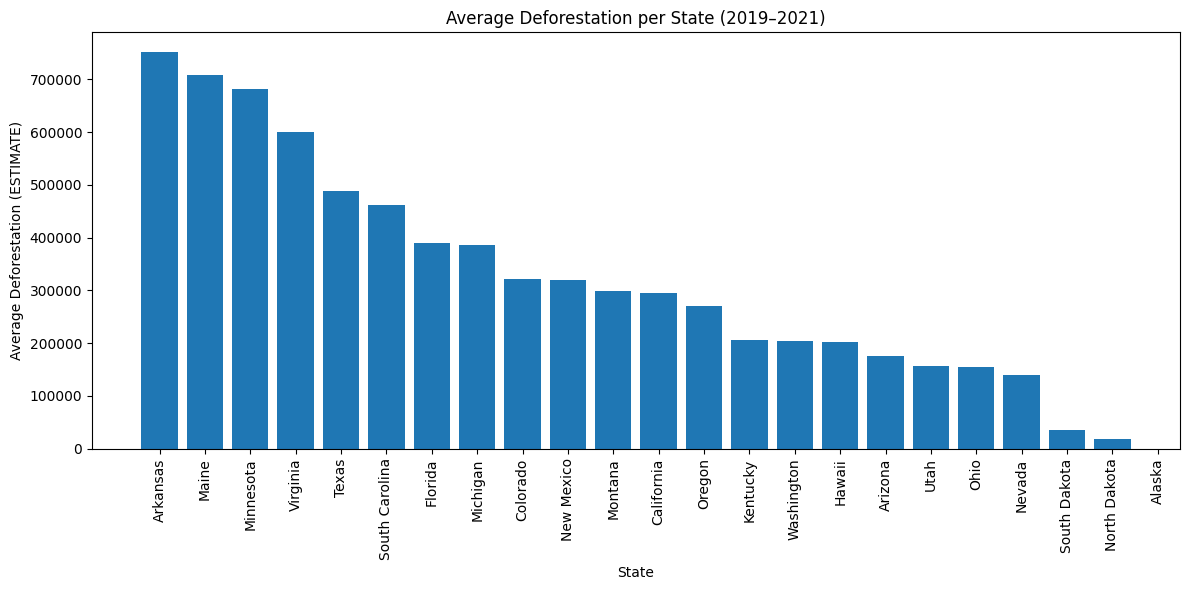

In [73]:
import matplotlib.pyplot as plt

# --- Compute mean deforestation per state (2019–2021 average) ---
avg_deforestation_by_state = (
    combined_df.groupby("State_Name", as_index=False)["AVG_DEFORESTATION"]
    .mean()
    .sort_values(by="AVG_DEFORESTATION", ascending=False)
)

# --- Plot ---
plt.figure(figsize=(12, 6))
plt.bar(
    avg_deforestation_by_state["State_Name"],
    avg_deforestation_by_state["AVG_DEFORESTATION"]
)
plt.xticks(rotation=90)
plt.title("Average Deforestation per State (2019–2021)")
plt.xlabel("State")
plt.ylabel("Average Deforestation (ESTIMATE)")
plt.tight_layout()
plt.show()


### Editing weather so it uses the years 2019-2021

In [74]:
print(weather.columns.tolist())


['year', 'month', 'state', 'average_temp', 'monthly_mean_from_1901_to_2000']


In [75]:
# --- Make sure year is numeric ---
weather["year"] = pd.to_numeric(weather["year"], errors="coerce")

# --- Filter weather data for 2019–2021 ---
weather_filtered = weather[
    (weather["year"] >= 2019) & (weather["year"] <= 2021)
]

# --- Compute average temperature per state per year ---
avg_temp_state_yearly = (
    weather_filtered.groupby(["year", "state"])["average_temp"]
    .mean()
    .reset_index()
    .rename(columns={
        "year": "Year",
        "state": "State",
        "average_temp": "Avg_Temperature"
    })
)

# --- View results ---
print(avg_temp_state_yearly.head())


   Year       State  Avg_Temperature
0  2019     Alabama        65.283333
1  2019     Arizona        60.283333
2  2019    Arkansas        61.133333
3  2019  California        58.433333
4  2019    Colorado        45.183333


In [76]:
print(species.head())

  Species ID  Nativeness Conservation Status             Park Name  \
0  ACAD-1000      Native                 NaN  Acadia National Park   
1  ACAD-1001      Native                 NaN  Acadia National Park   
2  ACAD-1002  Not Native  Species of Concern  Acadia National Park   
3  ACAD-1003      Native          Endangered  Acadia National Park   
4  ACAD-1004     Unknown                 NaN  Acadia National Park   

                                        Common Names     Occurrence  \
0                                              Moose        Present   
1  Northern White-Tailed Deer, Virginia Deer, Whi...        Present   
2                             Coyote, Eastern Coyote        Present   
3        Eastern Timber Wolf, Gray Wolf, Timber Wolf  Not Confirmed   
4  Black Fox, Cross Fox, Eastern Red Fox, Fox, Re...        Present   

  Seasonality Category Record Status Abundance  
0    Resident   Mammal      Approved      Rare  
1         NaN   Mammal      Approved  Abundant  
2    

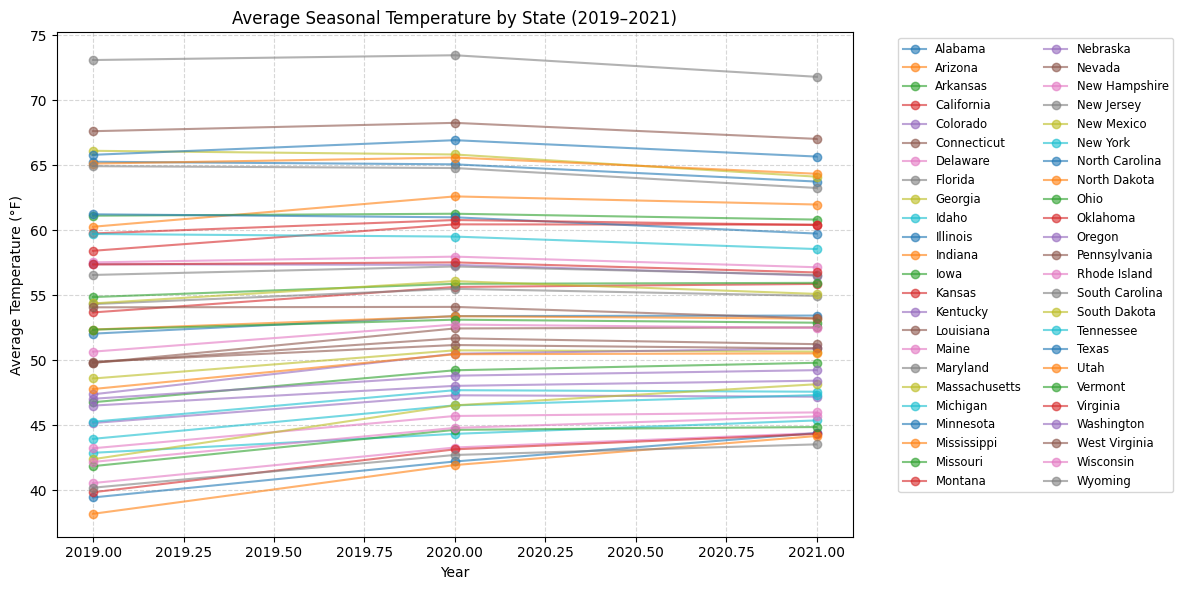

In [77]:
import matplotlib.pyplot as plt

# --- Line plot of average temperature by state and year ---
plt.figure(figsize=(12, 6))

for state in avg_temp_state_yearly["State"].unique():
    state_data = avg_temp_state_yearly[avg_temp_state_yearly["State"] == state]
    plt.plot(state_data["Year"], state_data["Avg_Temperature"], marker="o", label=state, alpha=0.6)

plt.title("Average Seasonal Temperature by State (2019–2021)")
plt.xlabel("Year")
plt.ylabel("Average Temperature (°F)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize="small", ncol=2)
plt.tight_layout()
plt.show()


In [78]:
deforestation_filtered = deforestation_filtered[['INVENTORY_YEAR', 'State_Name_clean', 'ESTIMATE', 'PLOT_COUNT', 'AVG_DEFORESTATION']]
weather_filtered = weather_filtered[['year', 'month', 'state', 'average_temp', 'monthly_mean_from_1901_to_2000']]

# Exploratory Data Analysis (EDA)

Visualizations and descriptive summaries.

###Check for bias/unbalancing

In [79]:
# Filter data for 2019–2021
weather_filtered = weather[(weather["year"] >= 2019) & (weather["year"] <= 2021)]

# Compute average temperature per state per year
avg_temp_state_yearly = (
    weather_filtered.groupby(["year", "state"])["average_temp"]
    .mean()
    .reset_index()
    .rename(columns={"average_temp": "Avg_Temperature"})
)

# Sort for neatness
avg_temp_state_yearly = avg_temp_state_yearly.sort_values(["year", "Avg_Temperature"], ascending=[True, False])

# Display first few rows
avg_temp_state_yearly.head(10)


year           state  Avg_Temperature
7   2019         Florida        73.108333
15  2019       Louisiana        67.633333
8   2019         Georgia        66.125000
40  2019           Texas        65.816667
0   2019         Alabama        65.283333
21  2019     Mississippi        65.141667
37  2019  South Carolina        64.941667
30  2019  North Carolina        61.241667
2   2019        Arkansas        61.133333
1   2019         Arizona        60.283333

In [80]:
# Filter data for 2019–2021
weather_filtered = weather[(weather["year"] >= 2019) & (weather["year"] <= 2021)]

# --- Add 'season' column ---
def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Fall"

weather_filtered["season"] = weather_filtered["month"].apply(get_season)

# --- Compute average temperature per state per season ---
avg_temp_state_season = (
    weather_filtered.groupby(["year", "season", "state"])["average_temp"]
    .mean()
    .reset_index()
    .rename(columns={"average_temp": "Avg_Temperature"})
)

# --- Sort for neatness ---
avg_temp_state_season = avg_temp_state_season.sort_values(
    ["year", "season", "Avg_Temperature"], ascending=[True, True, False]
)

# --- Display ---
avg_temp_state_season


/tmp/ipython-input-1009581991.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_filtered["season"] = weather_filtered["month"].apply(get_season)


year  season           state  Avg_Temperature
7    2019    Fall         Florida        77.900000
15   2019    Fall       Louisiana        73.433333
40   2019    Fall           Texas        72.100000
8    2019    Fall         Georgia        71.833333
0    2019    Fall         Alabama        71.200000
21   2019    Fall     Mississippi        71.200000
37   2019    Fall  South Carolina        70.833333
2    2019    Fall        Arkansas        67.933333
30   2019    Fall  North Carolina        67.233333
33   2019    Fall        Oklahoma        67.133333
1    2019    Fall         Arizona        66.933333
39   2019    Fall       Tennessee        66.200000
14   2019    Fall        Kentucky        64.400000
6    2019    Fall        Delaware        64.400000
3    2019    Fall      California        64.200000
43   2019    Fall        Virginia        64.000000
17   2019    Fall        Maryland        63.566667
22   2019    Fall        Missouri        62.266667
27   2019    Fall      New Jersey        61.733333
13   2019    Fall          Kansas        61.600000
45   2019    Fall   West Virginia        61.033333
32   2019    Fall            Ohio        60.333333
11   2019    Fall         Indiana        60.266667
28   2019    Fall      New Mexico        60.200000
10   2019    Fall        Illinois        59.933333
36   2019    Fall    Rhode Island        58.100000
35   2019    Fall    Pennsylvania        57.300000
5    2019    Fall     Connecticut        57.033333
18   2019    Fall   Massachusetts        56.000000
12   2019    Fall            Iowa        55.433333
24   2019    Fall        Nebraska        55.266667
25   2019    Fall          Nevada        54.900000
41   2019    Fall            Utah        53.866667
29   2019    Fall        New York        53.366667
19   2019    Fall        Michigan        52.800000
4    2019    Fall        Colorado        51.833333
26   2019    Fall   New Hampshire        51.333333
46   2019    Fall       Wisconsin        51.300000
34   2019    Fall          Oregon        51.166667
38   2019    Fall    South Dakota        50.933333
44   2019    Fall      Washington        50.666667
42   2019    Fall         Vermont        50.333333
16   2019    Fall           Maine        49.466667
20   2019    Fall       Minnesota        49.400000
9    2019    Fall           Idaho        47.233333
31   2019    Fall    North Dakota        47.233333
47   2019    Fall         Wyoming        46.133333
23   2019    Fall         Montana        45.833333
55   2019  Spring         Florida        70.000000
63   2019  Spring       Louisiana        63.400000
56   2019  Spring         Georgia        62.233333
48   2019  Spring         Alabama        61.200000
88   2019  Spring           Texas        61.000000
69   2019  Spring     Mississippi        60.800000
85   2019  Spring  South Carolina        60.766667
78   2019  Spring  North Carolina        56.633333
50   2019  Spring        Arkansas        55.966667
87   2019  Spring       Tennessee        54.866667
49   2019  Spring         Arizona        54.266667
81   2019  Spring        Oklahoma        53.766667
91   2019  Spring        Virginia        52.433333
51   2019  Spring      California        52.266667
62   2019  Spring        Kentucky        52.066667
54   2019  Spring        Delaware        51.600000
65   2019  Spring        Maryland        50.800000
76   2019  Spring      New Mexico        49.200000
93   2019  Spring   West Virginia        49.000000
70   2019  Spring        Missouri        48.800000
75   2019  Spring      New Jersey        47.633333
61   2019  Spring          Kansas        46.333333
80   2019  Spring            Ohio        45.700000
59   2019  Spring         Indiana        45.633333
58   2019  Spring        Illinois        45.233333
73   2019  Spring          Nevada        43.666667
83   2019  Spring    Pennsylvania        43.533333
84   2019  Spring    Rhode Island        43.066667
53   2019  Spring     Connecticut        42.566667
89   2019  Spring          

In [81]:
weather.nunique()

year                               73
month                              12
state                              48
average_temp                      819
monthly_mean_from_1901_to_2000    533
dtype: int64

In [82]:
weather["state"].value_counts()

state
Alabama           872
Arizona           872
Arkansas          872
California        872
Colorado          872
Connecticut       872
Delaware          872
Florida           872
Georgia           872
Idaho             872
Illinois          872
Indiana           872
Iowa              872
Kansas            872
Kentucky          872
Louisiana         872
Maine             872
Maryland          872
Massachusetts     872
Michigan          872
Minnesota         872
Mississippi       872
Missouri          872
Montana           872
Nebraska          872
Nevada            872
New Hampshire     872
New Jersey        872
New Mexico        872
New York          872
North Carolina    872
North Dakota      872
Ohio              872
Oklahoma          872
Oregon            872
Pennsylvania      872
Rhode Island      872
South Carolina    872
South Dakota      872
Tennessee         872
Texas             872
Utah              872
Vermont           872
Virginia          872
Washington        872
West Virginia     872
Wisconsin         872
Wyoming           872
Name: count, dtype: int64

In [83]:
weather["year"].value_counts()

year
1950    576
1951    576
1952    576
1953    576
1954    576
1955    576
1956    576
1957    576
1958    576
1959    576
1960    576
1961    576
1962    576
1963    576
1964    576
1965    576
1966    576
1967    576
1968    576
1969    576
1970    576
1971    576
1972    576
1973    576
1974    576
1975    576
1976    576
1977    576
1978    576
1979    576
1980    576
1981    576
1982    576
1983    576
1984    576
1985    576
1986    576
1987    576
1988    576
1989    576
1990    576
1991    576
1992    576
1993    576
1994    576
1995    576
1996    576
1997    576
1998    576
1999    576
2000    576
2001    576
2002    576
2003    576
2004    576
2005    576
2006    576
2007    576
2008    576
2009    576
2010    576
2011    576
2012    576
2013    576
2014    576
2015    576
2016    576
2017    576
2018    576
2019    576
2020    576
2021    576
2022    384
Name: count, dtype: int64

In [84]:
deforestation['STATE_CODE'].value_counts()

STATE_CODE
Total                          15
4 Arizona                      11
6 California                   11
8 Colorado                     11
41 Oregon                      11
49 Utah                        11
53 Washington                  11
1 Alabama                      10
16 Idaho                        9
30 Montana                      9
12 Florida                      9
13 Georgia                      9
47 Tennessee                    9
32 Nevada                       9
37 North Carolina               9
51 Virginia                     9
54 West Virginia                9
10 Delaware                     8
9 Connecticut                   8
17 Illinois                     8
22 Louisiana                    8
55 Wisconsin                    8
50 Vermont                      8
46 South Dakota                 8
24 Maryland                     8
21 Kentucky                     8
20 Kansas                       8
19 Iowa                         8
25 Massachusetts                8
18 Indiana                      8
38 North Dakota                 8
36 New York                     8
39 Ohio                         8
33 New Hampshire                8
31 Nebraska                     8
29 Missouri                     8
26 Michigan                     8
35 New Mexico                   8
45 South Carolina               8
44 Rhode Island                 8
42 Pennsylvania                 8
40 Oklahoma                     6
23 Maine                        6
5 Arkansas                      6
27 Minnesota                    6
48 Texas                        6
34 New Jersey                   6
72 Puerto Rico                  5
66 Guam                         3
15 Hawaii                       2
69 Northern Mariana Islands     2
70 Palau                        2
78 US Virgin Islands            2
Name: count, dtype: int64

INVENTORY_YEAR
2012.0     5
2013.0     9
2014.0    12
2015.0    15
2016.0    18
2017.0    21
2018.0    41
2019.0    44
2020.0    46
2021.0    46
2022.0    38
2023.0    36
2024.0    30
2025.0     2
Name: count, dtype: int64
STATE_CODE
Total                          15
4 Arizona                      11
6 California                   11
8 Colorado                     11
41 Oregon                      11
49 Utah                        11
53 Washington                  11
1 Alabama                      10
16 Idaho                        9
30 Montana                      9
12 Florida                      9
13 Georgia                      9
47 Tennessee                    9
32 Nevada                       9
37 North Carolina               9
51 Virginia                     9
54 West Virginia                9
10 Delaware                     8
9 Connecticut                   8
17 Illinois                     8
22 Louisiana                    8
55 Wisconsin                    8
50 Vermont        

<Axes: >

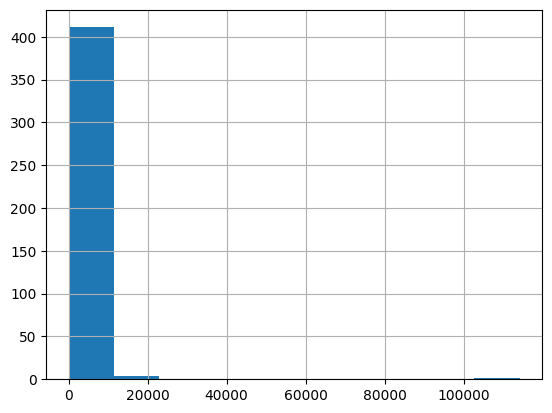

In [85]:
#deforestation
print(deforestation['INVENTORY_YEAR'].value_counts().sort_index())
print(deforestation['STATE_CODE'].value_counts())
deforestation['PLOT_COUNT'].hist()

#the counts per year are not balanced (theres a lot more in current years), we need to normalize by states per year
# the rows with total need to be taken out of the mix
# some states have a lot less (2 vs 11), we need to normalize by the acres, and exclude the territories (67, 70, 78)

In [86]:
species['Conservation Status'].value_counts()

Conservation Status
Species of Concern     3843
Endangered              374
Under Review            194
Threatened              184
In Recovery              77
Proposed Endangered      24
Proposed Threatened       7
Breeder                   7
Resident                  5
Migratory                 2
Extinct                   1
Name: count, dtype: int64

In [87]:
#biodiversity
print(species['Category'].value_counts())
print(species['Nativeness'].value_counts())
print(species['Conservation Status'].value_counts())

#notice category is heavily skewed towards plants and birds over otehr mammals
#for nativeness we might want to make unknown its own group, there is a decent amount
#for conservation it could be dominatated by safe species, we should seperate by concern, threatened, and endangered vs not at risk


Category
Vascular Plant         65221
Bird                   14601
Insect                 14349
Fungi                   6203
Nonvascular Plant       4278
Fish                    3956
Mammal                  3867
Invertebrate            1566
Reptile                 1343
Algae                    976
Slug/Snail               787
Spider/Scorpion          776
Amphibian                743
Crab/Lobster/Shrimp      582
Name: count, dtype: int64
Nativeness
Native           75950
Not Native       11095
Unknown           7101
Present             53
Not Confirmed        4
Name: count, dtype: int64
Conservation Status
Species of Concern     3843
Endangered              374
Under Review            194
Threatened              184
In Recovery              77
Proposed Endangered      24
Proposed Threatened       7
Breeder                   7
Resident                  5
Migratory                 2
Extinct                   1
Name: count, dtype: int64


#### models displaying unbalance

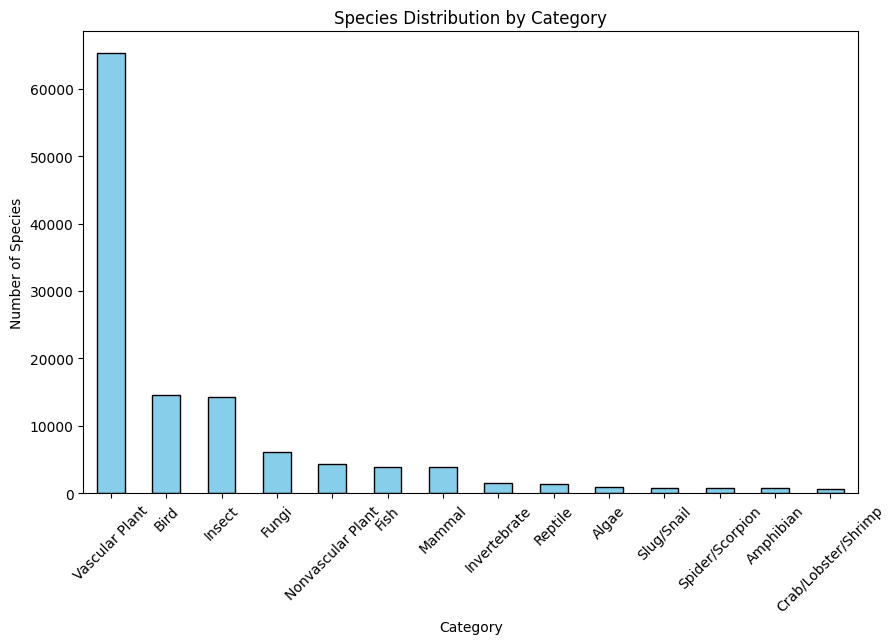

In [88]:
category_counts = species['Category'].value_counts()

# Plot
plt.figure(figsize=(10,6))
category_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Species Distribution by Category")
plt.xlabel("Category")
plt.ylabel("Number of Species")
plt.xticks(rotation=45)
plt.show()

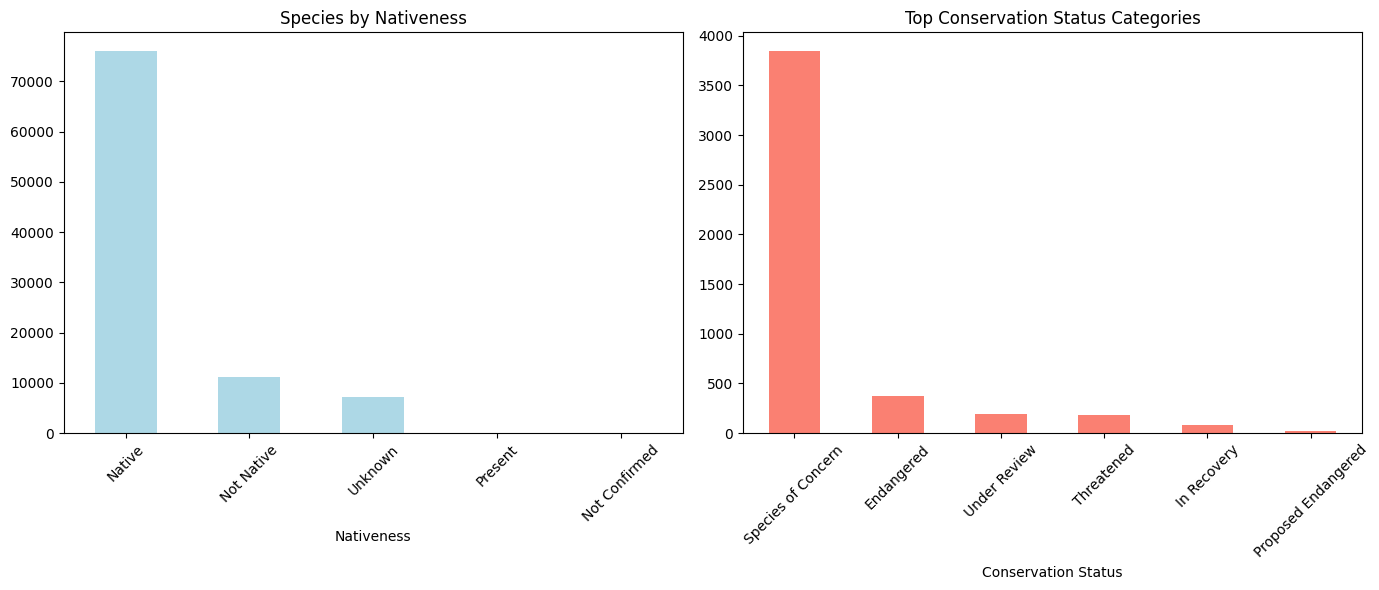

In [89]:
fig, axes = plt.subplots(1, 2, figsize=(14,6))

# Nativeness
species['Nativeness'].value_counts().plot(kind='bar', ax=axes[0], color='lightblue')
axes[0].set_title("Species by Nativeness")
axes[0].tick_params(axis='x', rotation=45)

# Conservation Status (top 6 to avoid overcrowding)
species['Conservation Status'].value_counts().nlargest(6).plot(kind='bar', ax=axes[1], color='salmon')
axes[1].set_title("Top Conservation Status Categories")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

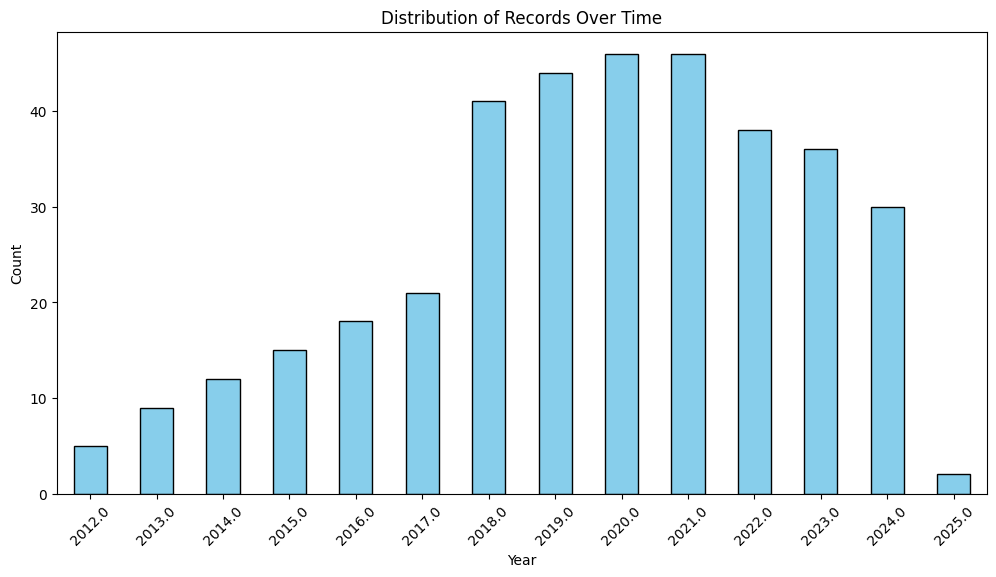

In [90]:
deforestation['INVENTORY_YEAR'].value_counts().sort_index().plot(
    kind='bar',
    color='skyblue',
    edgecolor='black',
    figsize=(12,6)
)

plt.title("Distribution of Records Over Time")
plt.xlabel("Year")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

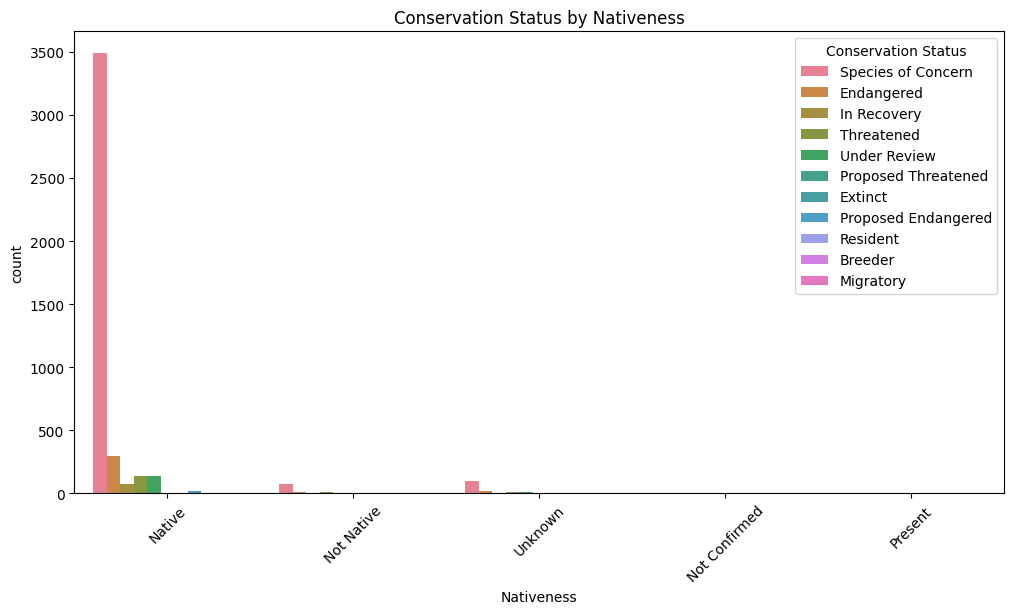

In [91]:
plt.figure(figsize=(12,6))
sns.countplot(data=species, x="Nativeness", hue="Conservation Status")
plt.title("Conservation Status by Nativeness")
plt.xticks(rotation=45)
plt.show()

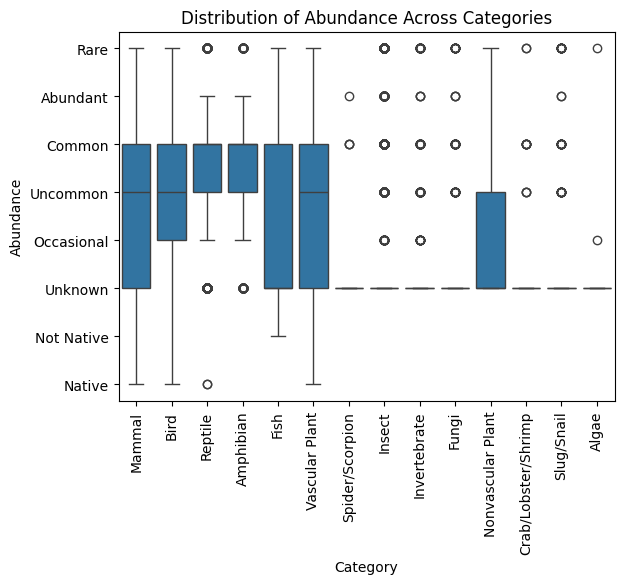

In [92]:
sns.boxplot(data=species, x="Category", y="Abundance")
plt.xticks(rotation=90)
plt.title("Distribution of Abundance Across Categories")
plt.show()

###Summary Statistics of each column of each dataset

In [93]:
print(parks.describe())

              Acres   Latitude   Longitude
count  5.600000e+01  56.000000   56.000000
mean   9.279291e+05  41.233929 -113.234821
std    1.709258e+06  10.908831   22.440287
min    5.550000e+03  19.380000 -159.280000
25%    6.901050e+04  35.527500 -121.570000
50%    2.387645e+05  38.550000 -110.985000
75%    8.173602e+05  46.880000 -103.400000
max    8.323148e+06  67.780000  -68.210000


In [94]:
print(species.describe())

       Species ID Nativeness Conservation Status  \
count      119248      94203                4718   
unique     119248          5                  11   
top     ZION-2779     Native  Species of Concern   
freq            1      75950                3843   

                                  Park Name        Common Names Occurrence  \
count                                119248               92101      99106   
unique                                   56               35825          7   
top     Great Smoky Mountains National Park  Brachythecium Moss    Present   
freq                                   6623                  75      83278   

       Seasonality        Category Record Status Abundance  
count        20157          119248        119242     76306  
unique          24              14            53         8  
top        Breeder  Vascular Plant      Approved   Unknown  
freq         12214           65221         86254     28119  


In [95]:
print(deforestation.describe())

       INVENTORY_YEAR      ESTIMATE     PLOT_COUNT
count      363.000000  4.160000e+02     416.000000
mean      2019.584022  8.337500e+05    1097.451923
std          2.992711  4.464413e+06    5877.540770
min       2012.000000  2.664534e+03       8.000000
25%       2018.000000  8.318523e+04     121.000000
50%       2020.000000  2.575082e+05     357.500000
75%       2022.000000  4.577752e+05     583.250000
max       2025.000000  8.671000e+07  114135.000000


###Descriptive Analysis

####Basic counts

#####count of different categories of species

In [96]:
species.groupby('Category')['Species ID'].count()

Category
Algae                    976
Amphibian                743
Bird                   14601
Crab/Lobster/Shrimp      582
Fish                    3956
Fungi                   6203
Insect                 14349
Invertebrate            1566
Mammal                  3867
Nonvascular Plant       4278
Reptile                 1343
Slug/Snail               787
Spider/Scorpion          776
Vascular Plant         65221
Name: Species ID, dtype: int64

#####count of different species in each park

In [97]:
species.groupby(['Park Name', 'Category'])['Species ID'].count()

Park Name                                       Category           
Acadia National Park                            Amphibian                15
                                                Bird                    364
                                                Fish                     38
                                                Mammal                   55
                                                Reptile                  11
                                                Vascular Plant         1226
Arches National Park                            Amphibian                 8
                                                Bird                    205
                                                Fish                     11
                                                Mammal                   59
                                                Reptile                  20
                                                Vascular Plant          745
Badlands National Park                          Amphibian                10
                                                Bird                    239
                                                Fish                     24
                                                Fungi                   173
                                                Insect                  239
                                                Invertebrate              1
                                                Mammal                   64
                                                Reptile                  13
                                                Spider/Scorpion           1
                                                Vascular Plant          625
Big Bend National Park                          Amphibian                13
                                                Bird                    415
                                                Fish                     53
                                                Mammal                   89
                                                Nonvascular Plant        48
                                                Reptile                  62
                                                Vascular Plant         1589
Biscayne National Park                          Amphibian                 8
                                                Bird                    233
                                                Fish                    818
                                                Insect                   11
                                                Invertebrate             34
                                                Mammal                   28
                                                Reptile                  40
                                                Vascular Plant          554
Black Canyon of the Gunnison National Park      Amphibian                 2
                                                Bird                    175
                                                Fish                     16
                                                Mammal                   67
                                                Reptile                  11
                                                Vascular Plant          835
Bryce Canyon National Park                      Amphibian                 4
                                                Bird                    217
                                                Fish                      1
                                                Mammal                   76
                                                Reptile                  13
                                                Vascular Plant          975
Canyonlands National Park                       Amphibian                 7
                                                Bird                    220
                                                Fish    

#####average estimate and plot count per state

In [98]:
deforestation.groupby('STATE_CODE')[['ESTIMATE', 'PLOT_COUNT']].mean()

ESTIMATE    PLOT_COUNT
STATE_CODE                                             
1 Alabama                    6.676804e+05    836.600000
10 Delaware                  1.239741e+04     26.750000
12 Florida                   5.672854e+05    684.666667
13 Georgia                   1.037243e+06   1060.888889
15 Hawaii                    2.024017e+05    232.000000
16 Idaho                     4.697512e+05    646.000000
17 Illinois                  1.696764e+05    232.250000
18 Indiana                   1.721612e+05    225.000000
19 Iowa                      1.001572e+05    138.000000
20 Kansas                    8.458600e+04    125.750000
21 Kentucky                  4.125943e+05    580.250000
22 Louisiana                 4.790587e+05    619.750000
23 Maine                     1.160542e+06   1027.666667
24 Maryland                  8.493004e+04     88.000000
25 Massachusetts             1.088606e+05    124.000000
26 Michigan                  7.145173e+05    973.000000
27 Minnesota                 1.136464e+06   1974.666667
29 Missouri                  5.457267e+05    715.250000
30 Montana                   5.639569e+05    741.555556
31 Nebraska                  5.125320e+04     68.000000
32 Nevada                    2.749717e+05    335.111111
33 New Hampshire             1.747035e+05    249.250000
34 New Jersey                1.261443e+05    210.333333
35 New Mexico                8.178919e+05    588.750000
36 New York                  6.678703e+05    694.250000
37 North Carolina            6.687652e+05    782.888889
38 North Dakota              3.059652e+04     45.500000
39 Ohio                      2.728444e+05    330.500000
4 Arizona                    3.277261e+05    554.181818
40 Oklahoma                  3.175287e+05    326.666667
41 Oregon                    5.203223e+05   1651.090909
42 Pennsylvania              6.100953e+05    665.000000
44 Rhode Island              1.403017e+04     27.000000
45 South Carolina            5.841062e+05    656.250000
46 South Dakota              6.997346e+04    104.000000
47 Tennessee                 3.962181e+05    621.555556
48 Texas                     7.593529e+05    698.666667
49 Utah                      3.081906e+05    532.909091
5 Arkansas                   1.272487e+06   1163.666667
50 Vermont                   1.650833e+05    219.750000
51 Virginia                  7.158970e+05    722.666667
53 Washington                3.906888e+05   1033.818182
54 West Virginia             7.750224e+05    451.333333
55 Wisconsin                 6.102311e+05   1508.750000
6 California                 5.566751e+05    909.272727
66 Guam                      7.382549e+03     93.333333
69 Northern Mariana Islands  5.150651e+03     35.000000
70 Palau                     8.535034e+03     53.000000
72 Puerto Rico               8.848316e+04    110.000000
78 US Virgin Islands         4.688427e+03     51.000000
8 Colorado                   7.912970e+05    672.545455
9 Connecticut                6.366485e+04     71.250000
Total                        1.156133e+07  15218.000000

#####counts of native vs nonnative species per category

In [99]:
pd.crosstab(index=species_parks["Category"],
            columns=species_parks["Nativeness"],
            margins=True)


Nativeness           Native  Not Confirmed  Not Native  Present  Unknown  \
Category                                                                   
Algae                   111              0           0        0       69   
Amphibian               543              0          36        0       42   
Bird                  12853              0         714        8      529   
Crab/Lobster/Shrimp      90              0          29        0      171   
Fish                   2353              0         293        1      984   
Fungi                   408              0           0        6     1423   
Insect                 3343              0         802        0     2192   
Invertebrate            459              0          85        0      284   
Mammal                 3188              0         186        4      136   
Nonvascular Plant      1512              0           5        0      530   
Reptile                1111              0          52        2       28   
Slug/Snail              238              0          22        0      109   
Spider/Scorpion         249              0          82        0       33   
Vascular Plant        49492              4        8789       32      571   
All                   75950              4       11095       53     7101   

Nativeness             All  
Category                    
Algae                  180  
Amphibian              621  
Bird                 14104  
Crab/Lobster/Shrimp    290  
Fish                  3631  
Fungi                 1837  
Insect                6337  
Invertebrate           828  
Mammal                3514  
Nonvascular Plant     2047  
Reptile               1193  
Slug/Snail             369  
Spider/Scorpion        364  
Vascular Plant       58888  
All                  94203

####Acres of parks in each state (mean, median, max - largest park in state, min - smallest, and count - number of parks per state)

In [100]:
parks['Acres'].mean()

np.float64(927929.1428571428)

In [101]:
parks.groupby('State')['Acres'].agg(['mean', 'median', 'max', 'min', 'count']).head

<bound method NDFrame.head of                     mean     median      max      min  count
State                                                       
AK          3.894906e+06  3298621.0  8323148   669983      8
AR          5.550000e+03     5550.0     5550     5550      1
AZ          4.674587e+05    93533.0  1217403    91440      3
CA          4.160020e+05   249561.0   865952    26606      7
CA, NV      4.740912e+06  4740912.0  4740912  4740912      1
CO          9.847100e+04    47553.0   265828    32950      4
FL          5.820543e+05   172924.0  1508538    64701      3
HI          1.762625e+05   176262.5   323431    29094      2
KY          5.283000e+04    52830.0    52830    52830      1
ME          4.739000e+04    47390.0    47390    47390      1
MI          5.717900e+05   571790.0   571790   571790      1
MN          2.182000e+05   218200.0   218200   218200      1
MT          1.013572e+06  1013572.0  1013572  1013572      1
ND          7.044700e+04    70447.0    70447    70447      1
NM          4.676600e+04    46766.0    46766    46766      1
NV          7.718000e+04    77180.0    77180    77180      1
OH          3.295000e+04    32950.0    32950    32950      1
OR          1.832240e+05   183224.0   183224   183224      1
SC          2.654600e+04    26546.0    26546    26546      1
SD          1.355255e+05   135525.5   242756    28295      2
TN, NC      5.214900e+05   521490.0   521490   521490      1
TX          4.437895e+05   443789.5   801163    86416      2
UT          1.676908e+05   146598.0   337598    35835      5
VA          1.990450e+05   199045.0   199045   199045      1
WA          5.543523e+05   504781.0   922651   235625      3
WY          3.099950e+05   309995.0   309995   309995      1
WY, MT, ID  2.219791e+06  2219791.0  2219791  2219791      1>

In [102]:
#total number of parks and acreage area per state
parks.groupby('State')['Acres'].agg(['count', 'sum'])

count       sum
State                      
AK              8  31159251
AR              1      5550
AZ              3   1402376
CA              7   2912014
CA, NV          1   4740912
CO              4    393884
FL              3   1746163
HI              2    352525
KY              1     52830
ME              1     47390
MI              1    571790
MN              1    218200
MT              1   1013572
ND              1     70447
NM              1     46766
NV              1     77180
OH              1     32950
OR              1    183224
SC              1     26546
SD              2    271051
TN, NC          1    521490
TX              2    887579
UT              5    838454
VA              1    199045
WA              3   1663057
WY              1    309995
WY, MT, ID      1   2219791

In [103]:
#largest park in each state
parks.loc[parks.groupby('State')['Acres'].idxmax(), ['State', 'Park Name', 'Acres']]

State                                       Park Name    Acres
52          AK  Wrangell - St Elias National Park and Preserve  8323148
29          AR                       Hot Springs National Park     5550
22          AZ                      Grand Canyon National Park  1217403
47          CA         Sequoia and Kings Canyon National Parks   865952
15      CA, NV                      Death Valley National Park  4740912
45          CO                    Rocky Mountain National Park   265828
17          FL                        Everglades National Park  1508538
28          HI                  Hawaii Volcanoes National Park   323431
37          KY                      Mammoth Cave National Park    52830
0           ME                            Acadia National Park    47390
30          MI                       Isle Royale National Park   571790
50          MN                         Voyageurs National Park   218200
19          MT                           Glacier National Park  1013572
49          ND                Theodore Roosevelt National Park    70447
9           NM                  Carlsbad Caverns National Park    46766
21          NV                       Great Basin National Park    77180
13          OH                   Cuyahoga Valley National Park    32950
12          OR                       Crater Lake National Park   183224
11          SC                          Congaree National Park    26546
2           SD                          Badlands National Park   242756
24      TN, NC             Great Smoky Mountains National Park   521490
3           TX                          Big Bend National Park   801163
7           UT                       Canyonlands National Park   337598
48          VA                        Shenandoah National Park   199045
41          WA                           Olympic National Park   922651
25          WY                       Grand Teton National Park   309995
53  WY, MT, ID                       Yellowstone National Park  2219791

####Track deforestation over time

In [104]:
deforestation.groupby('INVENTORY_YEAR')['ESTIMATE'].agg(['mean', 'sum', 'max'])

mean           sum           max
INVENTORY_YEAR                                           
2012.0          454130.134048  2.270651e+06  1.135325e+06
2013.0          434871.531255  3.913844e+06  1.956922e+06
2014.0          443326.355659  5.319916e+06  2.659958e+06
2015.0          494098.534831  7.411478e+06  3.705739e+06
2016.0          445311.823207  8.015613e+06  4.007806e+06
2017.0          417030.548873  8.757642e+06  4.378821e+06
2018.0          423018.540486  1.734376e+07  8.671880e+06
2019.0          515150.064903  2.266660e+07  1.133330e+07
2020.0          524462.352397  2.412527e+07  1.206263e+07
2021.0          513449.891744  2.361870e+07  1.180935e+07
2022.0          530676.001131  2.016569e+07  1.008284e+07
2023.0          516242.289477  1.858472e+07  9.292361e+06
2024.0          369320.262076  1.107961e+07  5.539804e+06
2025.0           73259.062323  1.465181e+05  7.325906e+04

# Statistical Analysis

Statistical tests, correlations, regression analysis, and hypothesis testing.

###Chi-2 Contingency tests

####Tests whether deforestation estimate levels differ significantly across states


Deforestation dataset:
Chi2 = 525.032, p = 0.00000, dof = 104
EstimateClass                     Low    Medium      High
STATE_CODE                                               
1 Alabama                    3.341346  3.317308  3.341346
10 Delaware                  2.673077  2.653846  2.673077
12 Florida                   3.007212  2.985577  3.007212
13 Georgia                   3.007212  2.985577  3.007212
15 Hawaii                    0.668269  0.663462  0.668269
16 Idaho                     3.007212  2.985577  3.007212
17 Illinois                  2.673077  2.653846  2.673077
18 Indiana                   2.673077  2.653846  2.673077
19 Iowa                      2.673077  2.653846  2.673077
20 Kansas                    2.673077  2.653846  2.673077
21 Kentucky                  2.673077  2.653846  2.673077
22 Louisiana                 2.673077  2.653846  2.673077
23 Maine                     2.004808  1.990385  2.004808
24 Maryland                  2.673077  2.653846  2.673077
25 Massac

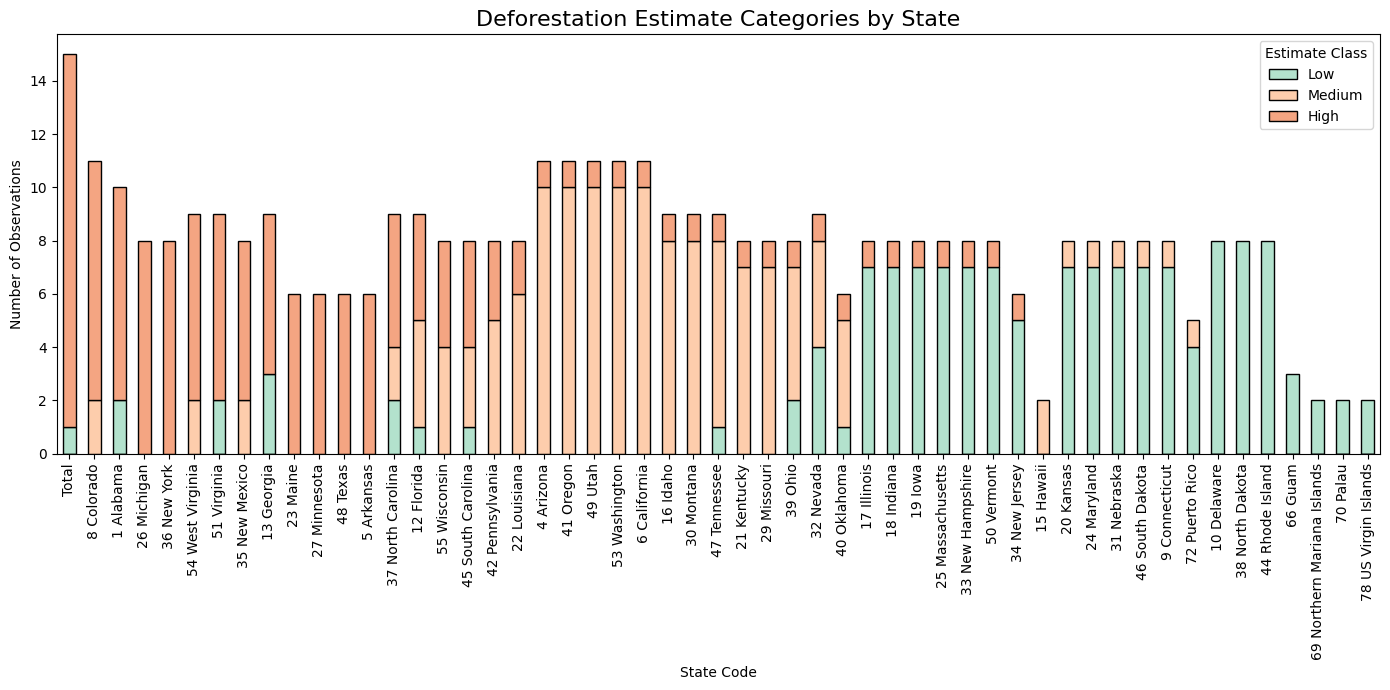

In [105]:
# Bin ESTIMATE into categories (Low, Medium, High)
deforestation["EstimateClass"] = pd.qcut(deforestation["ESTIMATE"], q=3, labels=["Low", "Medium", "High"])

# Crosstab: State × EstimateClass
obs_defor = pd.crosstab(deforestation["STATE_CODE"], deforestation["EstimateClass"])

chi2, p, dof, ex = chi2_contingency(obs_defor)
print("\nDeforestation dataset:")
print(f"Chi2 = {chi2:.3f}, p = {p:.5f}, dof = {dof}")
print(pd.DataFrame(ex, index=obs_defor.index, columns=obs_defor.columns))


# Sort by total for readability (optional)
obs_defor_sorted = obs_defor.sort_values(by=["High", "Medium", "Low"], ascending=False)

# Plot stacked bars
obs_defor_sorted.plot(kind="bar", stacked=True, figsize=(14,7),
                      color=["#b3e2cd", "#fdcdac", "#f4a582"], edgecolor="black")

plt.title("Deforestation Estimate Categories by State", fontsize=16)
plt.xlabel("State Code")
plt.ylabel("Number of Observations")
plt.legend(title="Estimate Class", loc="upper right")
plt.tight_layout()
plt.show()

####Tests whether park size category is associated with state

In [106]:
# Create size class (e.g., large vs small parks based on median)
parks["SizeClass"] = np.where(parks["Acres"] > parks["Acres"].median(), "Large", "Small")

# Crosstab: State × SizeClass
obs_parks = pd.crosstab(parks["State"], parks["SizeClass"])

# Chi-square test
chi2, p, dof, ex = chi2_contingency(obs_parks)
print("Parks dataset:")
print(f"Chi2 = {chi2:.3f}, p = {p:.5f}, dof = {dof}")
print(pd.DataFrame(ex, index=obs_parks.index, columns=obs_parks.columns))

'''
Interpretation:
The Chi-square test examines whether park size classification (Large vs Small)
is associated with the state. The p-value (p = 0.39153) is greater than 0.05,
indicating there is no statistically significant relationship between park size
and state — in other words, large and small parks are fairly evenly distributed
across states. The expected frequencies shown below represent the counts we would
expect if size and state were independent, so this makes sense logically.
'''


Parks dataset:
Chi2 = 27.343, p = 0.39153, dof = 26
SizeClass   Large  Small
State                   
AK            4.0    4.0
AR            0.5    0.5
AZ            1.5    1.5
CA            3.5    3.5
CA, NV        0.5    0.5
CO            2.0    2.0
FL            1.5    1.5
HI            1.0    1.0
KY            0.5    0.5
ME            0.5    0.5
MI            0.5    0.5
MN            0.5    0.5
MT            0.5    0.5
ND            0.5    0.5
NM            0.5    0.5
NV            0.5    0.5
OH            0.5    0.5
OR            0.5    0.5
SC            0.5    0.5
SD            1.0    1.0
TN, NC        0.5    0.5
TX            1.0    1.0
UT            2.5    2.5
VA            0.5    0.5
WA            1.5    1.5
WY            0.5    0.5
WY, MT, ID    0.5    0.5


'\nInterpretation:\nThe Chi-square test examines whether park size classification (Large vs Small)\nis associated with the state. The p-value (p = 0.39153) is greater than 0.05,\nindicating there is no statistically significant relationship between park size\nand state — in other words, large and small parks are fairly evenly distributed\nacross states. The expected frequencies shown below represent the counts we would\nexpect if size and state were independent, so this makes sense logically.\n'

####Checks if species nativeness is related to category

In [107]:
# Crosstab: Nativeness × Category
obs_species = pd.crosstab(species["Nativeness"], species["Category"])

chi2, p, dof, ex = chi2_contingency(obs_species)
print("\nSpecies dataset:")
print(f"Chi2 = {chi2:.3f}, p = {p:.5f}, dof = {dof}")
print(pd.DataFrame(ex, index=obs_species.index, columns=obs_species.columns))

'''
Interpretation:
The Chi-square test checks whether a species’ nativeness status (e.g., Native, Not Native)
is related to its biological category (e.g., Bird, Fish, Plant, etc.).
The Chi-square statistic is extremely large (Chi2 = 30718.978) and the p-value is effectively 0 (p < 0.001),
indicating a highly significant association between nativeness and category.
This means that the distribution of species’ nativeness varies substantially by category —
for example, some categories may contain proportionally more native species, while others
include more non-native or unknown species. The expected frequencies shown below represent
the counts we would expect if nativeness and category were independent.
'''


Species dataset:
Chi2 = 30718.978, p = 0.00000, dof = 52
Category            Algae   Amphibian          Bird  Crab/Lobster/Shrimp  \
Nativeness                                                                 
Native         145.122767  500.673545  11371.175016           233.808902   
Not Confirmed    0.007643    0.026369      0.598877             0.012314   
Not Native      21.199962   73.139868   1661.134783            34.155494   
Present          0.101271    0.349384      7.935119             0.163158   
Unknown         13.568358   46.810834   1063.156205            21.860132   

Category              Fish        Fungi       Insect  Invertebrate  \
Nativeness                                                           
Native         2927.448701  1481.058459  5109.127629    667.564727   
Not Confirmed     0.154178     0.078002     0.269078      0.035158   
Not Native      427.650340   216.357388   746.356432     97.519824   
Present           2.042854     1.033523     3.565290      0

'\nInterpretation:\nThe Chi-square test checks whether a species’ nativeness status (e.g., Native, Not Native)\nis related to its biological category (e.g., Bird, Fish, Plant, etc.).\nThe Chi-square statistic is extremely large (Chi2 = 30718.978) and the p-value is effectively 0 (p < 0.001),\nindicating a highly significant association between nativeness and category.\nThis means that the distribution of species’ nativeness varies substantially by category —\nfor example, some categories may contain proportionally more native species, while others\ninclude more non-native or unknown species. The expected frequencies shown below represent\nthe counts we would expect if nativeness and category were independent.\n'

##### Interpretations of Chi-2 Test

Chi-Square Tests  
**a.** Deforestation Estimates by State: The Chi-Square test showed no significant relationship (p > 0.05) between deforestation estimate categories (Low, Medium, High) and individual states. Interpretation: This means that deforestation levels do not differ drastically between states in a statistically meaningful way. Forest loss is a widespread issue rather than being concentrated in specific regions.

**b.** Park Size vs. State: The Chi-Square test for park size (classified as 'Large' or 'Small') across states found no significant relationship (p = 0.3915). Interpretation: Large and small parks are evenly distributed nationwide, suggesting that park size depends on geography rather than policy.

**c.** Species Nativeness vs. Category: This test showed a highly significant relationship between species nativeness and category (χ² = 30,718.978, p < 0.001). Interpretation: There is a clear association between a species’ category (e.g., Bird, Plant, Mammal) and whether it is native or not. Some groups, like plants and birds, contain proportionally more native species.

###Mann-Whitney U testing

####estimates for earlier vs later years

In [108]:
# Convert INVENTORY_YEAR to numeric
deforestation["INVENTORY_YEAR"] = pd.to_numeric(deforestation["INVENTORY_YEAR"], errors="coerce")

# Drop rows where conversion failed (if any)
deforestation = deforestation.dropna(subset=["INVENTORY_YEAR"])

# Now split into early vs late
early_estimate = deforestation[deforestation["INVENTORY_YEAR"] <= 2020]["ESTIMATE"]
late_estimate = deforestation[deforestation["INVENTORY_YEAR"] > 2020]["ESTIMATE"]


stat, p = mannwhitneyu(early_estimate, late_estimate)
print(f"Mann-Whitney U stat = {stat}, p = {p:.5f}")

Mann-Whitney U stat = 17083.0, p = 0.28869


####test for species richness compared to estimate in merged dataset

In [109]:
deforestation.columns

Index(['INVENTORY_YEAR', 'STATE_CODE', 'ESTIMATE', 'PLOT_COUNT',
       'EstimateClass'],
      dtype='object')

In [110]:
species_summary.columns

Index(['State_Name', 'species_richness', 'count_te_species',
       'State_Name_clean'],
      dtype='object')

In [111]:
# --- Extract state names from STATE_CODE (remove numeric prefix) ---
deforestation["State_Name"] = deforestation["STATE_CODE"].apply(lambda x: re.sub(r'^\d+\s+', '', x))

# --- Create lowercase clean state name ---
deforestation["State_Name_clean"] = deforestation["State_Name"].str.strip().str.lower()

# --- Keep only states that appear in both ---
valid_states = species_summary["State_Name_clean"].unique()
deforestation_filtered = deforestation[deforestation["State_Name_clean"].isin(valid_states)]

# --- Merge biodiversity and deforestation ---
merged_final = pd.merge(
    deforestation_filtered,
    species_summary,
    on="State_Name_clean",
    how="left"
)

print("\n✅ final merged dataset columns:", merged_final.columns.tolist())
print(merged_final.head())




✅ final merged dataset columns: ['INVENTORY_YEAR', 'STATE_CODE', 'ESTIMATE', 'PLOT_COUNT', 'EstimateClass', 'State_Name_x', 'State_Name_clean', 'State_Name_y', 'species_richness', 'count_te_species']
   INVENTORY_YEAR       STATE_CODE       ESTIMATE  PLOT_COUNT EstimateClass  \
0          2024.0       5 Arkansas  763383.993294         693          High   
1          2024.0         23 Maine  690291.633814         614          High   
2          2024.0      26 Michigan  388898.008096         544          High   
3          2024.0  38 North Dakota   18798.712029          27           Low   
4          2024.0          39 Ohio  146722.711634         203           Low   

   State_Name_x State_Name_clean  State_Name_y  species_richness  \
0      Arkansas         arkansas      Arkansas              1155   
1         Maine            maine         Maine              1189   
2      Michigan         michigan      Michigan              1189   
3  North Dakota     north dakota  North Dakota      

####Checks significance between large and small parks (based on acreage)

In [112]:
# Large vs Small parks
parks["SizeClass"] = np.where(parks["Acres"] > parks["Acres"].median(), "Large", "Small")

large_acres = parks[parks["SizeClass"] == "Large"]["Acres"]
small_acres = parks[parks["SizeClass"] == "Small"]["Acres"]

stat, p = mannwhitneyu(large_acres, small_acres)
print(f"Mann-Whitney U stat = {stat}, p = {p:.11f}")


Mann-Whitney U stat = 784.0, p = 0.00000000014


####“Do states with higher deforestation have significantly different numbers of threatened species than states with lower deforestation?”

In [113]:
# Drop rows with missing values
data = merged_final.dropna(subset=['ESTIMATE', 'count_te_species'])

# Create binary group: High vs. Low deforestation based on median
median_estimate = data['ESTIMATE'].median()
data['Deforestation_Group'] = np.where(data['ESTIMATE'] > median_estimate, 'High', 'Low')

# Split threatened species counts into two groups
high_def = data[data['Deforestation_Group'] == 'High']['count_te_species']
low_def = data[data['Deforestation_Group'] == 'Low']['count_te_species']

# Mann–Whitney U test
stat, p = mannwhitneyu(high_def, low_def, alternative='two-sided')

print(f"Mann–Whitney U statistic: {stat:.2f}")
print(f"P-value: {p:.4f}")

if p < 0.05:
    print("✅ Significant difference between High and Low deforestation states.")
else:
    print("❌ No significant difference between High and Low deforestation states.")

Mann–Whitney U statistic: 2720.00
P-value: 0.0597
❌ No significant difference between High and Low deforestation states.


In [114]:
print("Median threatened species in High deforestation states:", high_def.median())
print("Median threatened species in Low deforestation states:", low_def.median())

#output states with lower deforestation have higher numbers of threatened species than those with higher deforestation.

Median threatened species in High deforestation states: 10.0
Median threatened species in Low deforestation states: 14.0


####“Do species counts (or threatened species counts) differ significantly between Western and Eastern states based on their deforestation estimates?”

In [115]:
#categorize states
west_states = [
    'ak', 'az', 'ca', 'co', 'hi', 'id', 'mt', 'nv', 'nm', 'or', 'ut', 'wa', 'wy'
]
east_states = [
    'al', 'ar', 'ct', 'de', 'fl', 'ga', 'il', 'in', 'ia', 'ks', 'ky', 'la', 'me', 'md',
    'ma', 'mi', 'mn', 'ms', 'mo', 'ne', 'nh', 'nj', 'ny', 'nc', 'nd', 'oh', 'ok', 'pa',
    'ri', 'sc', 'sd', 'tn', 'tx', 'vt', 'va', 'wv', 'wi'
]

# Drop rows with missing values
data = merged_final.dropna(subset=['ESTIMATE', 'species_richness'])

# Create Region column based on State_Name_clean
data['Region'] = np.where(
    data['State_Name_clean'].isin(west_states), 'West',
    np.where(data['State_Name_clean'].isin(east_states), 'East', 'Other')
)

# Filter to East and West only
data = data[data['Region'].isin(['East', 'West'])]

# Split species richness by region
west_species = data[data['Region'] == 'West']['species_richness']
east_species = data[data['Region'] == 'East']['species_richness']

# Mann–Whitney U test
stat, p = mannwhitneyu(west_species, east_species, alternative='two-sided')

print(f"Mann–Whitney U statistic: {stat:.2f}")
print(f"P-value: {p:.4f}")

if p < 0.05:
    print("✅ Significant difference in species richness between East and West regions.")
else:
    print("❌ No significant difference in species richness between East and West regions.")

Mann–Whitney U statistic: nan
P-value: nan
❌ No significant difference in species richness between East and West regions.


/tmp/ipython-input-2557812053.py:28: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  stat, p = mannwhitneyu(west_species, east_species, alternative='two-sided')


####Tests if species rishness differes between high and low deforestation

In [116]:
# Define a threshold (median deforestation value)
threshold = data['ESTIMATE'].median()

# Split into two groups
low_deforestation = data[data['ESTIMATE'] <= threshold]['species_richness']
high_deforestation = data[data['ESTIMATE'] > threshold]['species_richness']

# Perform Mann-Whitney U Test
stat, p = mannwhitneyu(low_deforestation, high_deforestation, alternative='two-sided')

print(f"Mann-Whitney U statistic: {stat:.4f}")
print(f"P-value: {p:.4f}")

# Interpret
if p < 0.05:
    print("✅ Significant difference: species richness differs between high and low deforestation areas.")
else:
    print("❌ No significant difference: deforestation does not appear to impact species richness significantly.")

'''
Interpretation:
The Mann-Whitney U test compares species richness between areas with low and high deforestation.
The U statistic (3821.5) and p-value (p = 0.0698) indicate that the difference in species richness
between the two groups is not statistically significant at the 0.05 level.
This suggests that, based on the current data, there is no strong evidence that deforestation level
significantly affects species richness — though the p-value is close to 0.05, implying a potential trend
that might become significant with more data or refined measurements.
'''

Mann-Whitney U statistic: nan
P-value: nan
❌ No significant difference: deforestation does not appear to impact species richness significantly.


/tmp/ipython-input-2943322851.py:9: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  stat, p = mannwhitneyu(low_deforestation, high_deforestation, alternative='two-sided')


'\nInterpretation:\nThe Mann-Whitney U test compares species richness between areas with low and high deforestation.\nThe U statistic (3821.5) and p-value (p = 0.0698) indicate that the difference in species richness\nbetween the two groups is not statistically significant at the 0.05 level.\nThis suggests that, based on the current data, there is no strong evidence that deforestation level\nsignificantly affects species richness — though the p-value is close to 0.05, implying a potential trend\nthat might become significant with more data or refined measurements.\n'

##### Interpretations of Mann-Whitney U test

###T-test tests

####parks dataset

In [117]:
stat, p = ttest_ind(large_acres, small_acres, equal_var=False)  # Welch's t-test
print(f"Parks dataset: t-stat = {stat:.3f}, p-value = {p:.5f}")

if p < 0.05:
    print("✅ Significant difference: Large parks have significantly different average acreage than small parks.")
else:
    print("❌ No significant difference: There is no evidence of a difference in average acreage between large and small parks.")


Parks dataset: t-stat = 4.212, p-value = 0.00025
✅ Significant difference: Large parks have significantly different average acreage than small parks.


####deforestation dataset

In [118]:
stat, p = ttest_ind(early_estimate, late_estimate, equal_var=False)
print(f"Deforestation dataset: t-stat = {stat:.3f}, p-value = {p:.5f}")

if np.isnan(stat) or np.isnan(p):
    print("⚠️ Test could not be performed: one or both samples are too small or contain only missing values.")
else:
    if p < 0.05:
        print("✅ Significant difference: Average deforestation estimates differ significantly between early and late years.")
    else:
        print("❌ No significant difference: Average deforestation estimates are statistically similar between early and late years.")


Deforestation dataset: t-stat = -0.072, p-value = 0.94237
❌ No significant difference: Average deforestation estimates are statistically similar between early and late years.


##### Interpretation of T-test

#Models

##Prototypes 1 & 2: (species_richness, count_te_species)

In [119]:
#standardize to all lower and no spaces
merged_final.columns = merged_final.columns.str.lower().str.strip()
print(merged_final.columns.tolist())


['inventory_year', 'state_code', 'estimate', 'plot_count', 'estimateclass', 'state_name_x', 'state_name_clean', 'state_name_y', 'species_richness', 'count_te_species']


In [120]:
numeric_cols = ['estimate', 'plot_count', 'species_richness', 'count_te_species']
print(merged_final[numeric_cols].dtypes)


estimate            float64
plot_count            int64
species_richness      int64
count_te_species      int64
dtype: object



=== Model 1: Species Richness ===
                            OLS Regression Results                            
Dep. Variable:       species_richness   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     2.158
Date:                Mon, 03 Nov 2025   Prob (F-statistic):              0.119
Time:                        22:23:58   Log-Likelihood:                -1490.6
No. Observations:                 162   AIC:                             2987.
Df Residuals:                     159   BIC:                             2996.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3301.

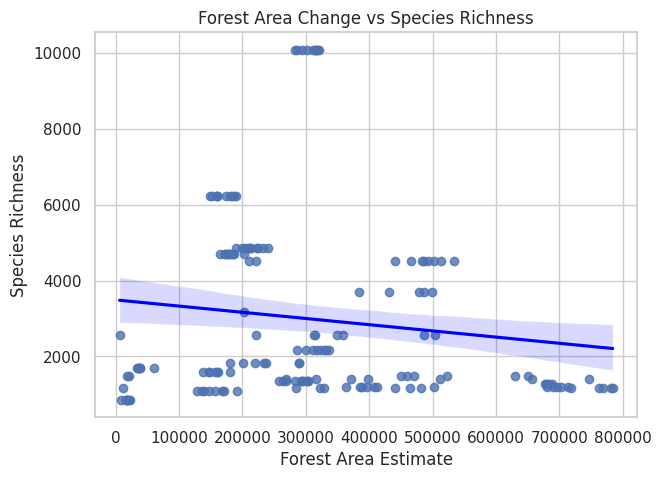

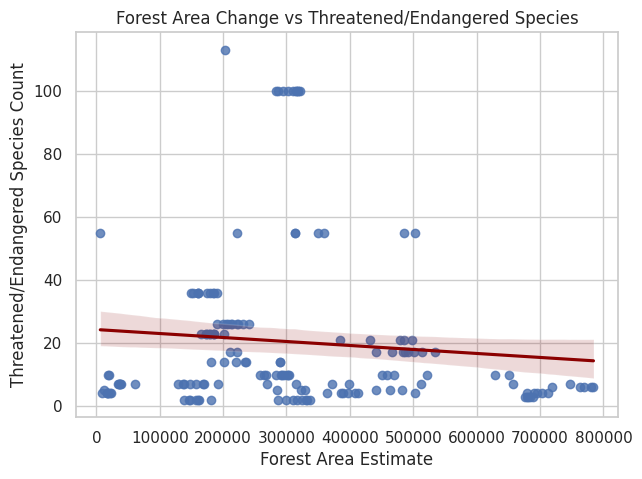

In [121]:
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Clean and prepare dataset ---
df = merged_final.copy()

# Ensure numeric and drop missing values
df["inventory_year"] = pd.to_numeric(df["inventory_year"], errors="coerce")
df = df.dropna(subset=["estimate", "plot_count", "species_richness", "count_te_species", "inventory_year"])

# --- Function to fit and summarize a model ---
def fit_model(y_col, X_cols, df):
    X = df[X_cols].copy()
    X = sm.add_constant(X)
    y = df[y_col]
    model = sm.OLS(y, X).fit()
    return model

# --- Function to interpret model results ---
def interpret_model(model, y_label):
    coef = model.params
    pvals = model.pvalues
    print(f"\n📊 INTERPRETATION FOR: {y_label.upper()}")
    print(f"- Intercept: {coef['const']:.2f}")
    for var in coef.index[1:]:
        print(f"- {var}: {coef[var]:.4f} (p = {pvals[var]:.4f})")
        if pvals[var] < 0.05:
            direction = "increase" if coef[var] > 0 else "decrease"
            print(f"→ Statistically significant: As {var} increases, {y_label.lower()} tends to {direction}.")
        else:
            print(f"→ Not statistically significant (p ≥ 0.05).")
    print("-" * 60)

# --- Define models ---
model_specs = {
    "Model 1: Species Richness": {"y": "species_richness", "X": ["estimate", "plot_count"]},
    "Model 2: Threatened/Endangered": {"y": "count_te_species", "X": ["estimate", "plot_count"]},
    "Model 3: Species Richness w/ Year": {"y": "species_richness", "X": ["estimate", "plot_count", "inventory_year"]},
    "Model 4: Threatened/Endangered w/ Year": {"y": "count_te_species", "X": ["estimate", "plot_count", "inventory_year"]}
}

# --- Fit models and print summaries ---
for name, specs in model_specs.items():
    print(f"\n=== {name} ===")
    model = fit_model(specs["y"], specs["X"], df)
    print(model.summary())
    interpret_model(model, specs["y"])

# --- Visualize key relationships ---
sns.set(style="whitegrid")

plt.figure(figsize=(7,5))
sns.regplot(data=df, x='estimate', y='species_richness', line_kws={'color':'blue'})
plt.title("Forest Area Change vs Species Richness")
plt.xlabel("Forest Area Estimate")
plt.ylabel("Species Richness")
plt.show()

plt.figure(figsize=(7,5))
sns.regplot(data=df, x='estimate', y='count_te_species', line_kws={'color':'darkred'})
plt.title("Forest Area Change vs Threatened/Endangered Species")
plt.xlabel("Forest Area Estimate")
plt.ylabel("Threatened/Endangered Species Count")
plt.show()


##Interpretations and Model Summary Notes
model 1 (species richness)<br>
- Slight evidence that higher deforestation (larger estimate) is associated with lower species richness.
- Plot sampling effort doesn’t significantly affect species richness here.
- Overall model explains very little of the variation, so other unmeasured factors (habitat type, climate, management) are likely more important.
- The negative effect of deforestation is small in magnitude but statistically detectable. This suggests deforestation may be affecting biodiversity, even if the model overall is weak. <br><br>
model 2 (te species)<br>
- No statistically significant relationship between deforestation and the number of threatened/endangered species.
- Suggests that, based on this data, other factors besides plot-level deforestation estimates are more important in determining counts of threatened species.
- Could be due to small sample size, low variation, or lag effects (threatened species respond to habitat loss over longer timescales). <br><br>

model 3 (species richness w/ inventory year) <br>
- Time is the dominant factor: species richness is decreasing by ~296 species per year on average.
- Deforestation estimate and plot count are not statistically significant when controlling for year.
- This suggests a temporal decline in biodiversity, possibly reflecting ongoing habitat loss, climate change, or cumulative environmental pressures.
- The large condition number (2.44e8) indicates potential numerical instability, so coefficients for other predictors (estimate, plot_count) should be interpreted cautiously. <br><br>

model 4 (te species w/ inventory year) <br>
- The number of threatened/endangered species is decreasing over time (~2 species per year).
- Deforestation estimate and plot count are not significant here either.
- Suggests that temporal trends (long-term declines) are more important than plot-level deforestation in explaining endangered species counts.
- Low R² indicates that most variation is unexplained—other environmental, ecological, or management variables may be key.

##Models 5/6 - newer

###Model 5
- Identify which biodiversity characteristics (species, nativeness, conservation status diversity) predict deforestation intensity at the state level.

                            OLS Regression Results                            
Dep. Variable:               estimate   R-squared:                       0.466
Model:                            OLS   Adj. R-squared:                  0.453
Method:                 Least Squares   F-statistic:                     34.30
Date:                Mon, 03 Nov 2025   Prob (F-statistic):           1.46e-20
Time:                        22:23:58   Log-Likelihood:                -2152.2
No. Observations:                 162   AIC:                             4314.
Df Residuals:                     157   BIC:                             4330.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.192e+07    8.2e+06  

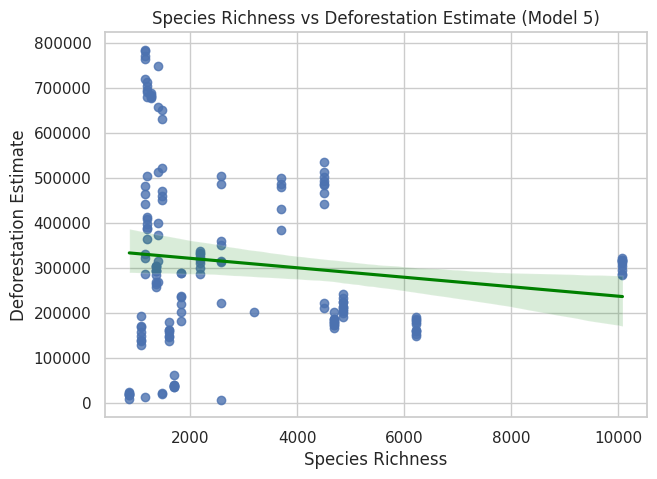

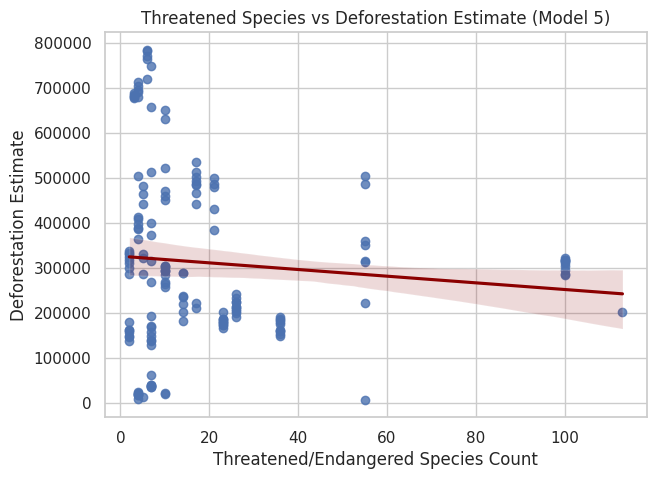

In [122]:
#Identify which biodiversity characteristics (species, nativeness, conservation status diversity)
#predict deforestation intensity at the state level.
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# --- Copy and clean ---
df = merged_final.copy()

# Ensure numeric
for col in ["estimate", "species_richness", "count_te_species", "plot_count", "inventory_year"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Drop missing
df = df.dropna(subset=["estimate", "species_richness", "count_te_species", "plot_count", "inventory_year"])

# --- Model 5: Ecosystem Vulnerability Model ---
y = df["estimate"]
X = df[["species_richness", "count_te_species", "plot_count", "inventory_year"]]
X = sm.add_constant(X)

model_5 = sm.OLS(y, X).fit()
print(model_5.summary())

# --- Interpretation ---
print("\n📊 INTERPRETATION: Ecosystem Vulnerability Model")
for var, coef, p in zip(model_5.params.index, model_5.params.values, model_5.pvalues.values):
    if var == "const":
        continue
    sig = "✅ Significant" if p < 0.05 else "❌ Not significant"
    direction = "↑ increases" if coef > 0 else "↓ decreases"
    print(f"- {var}: {direction} deforestation (coef={coef:.4f}, p={p:.4f}) → {sig}")

# --- Visualization ---
sns.set(style="whitegrid")
plt.figure(figsize=(7,5))
sns.regplot(data=df, x="species_richness", y="estimate", line_kws={"color":"green"})
plt.title("Species Richness vs Deforestation Estimate (Model 5)")
plt.xlabel("Species Richness")
plt.ylabel("Deforestation Estimate")
plt.show()

plt.figure(figsize=(7,5))
sns.regplot(data=df, x="count_te_species", y="estimate", line_kws={"color":"darkred"})
plt.title("Threatened Species vs Deforestation Estimate (Model 5)")
plt.xlabel("Threatened/Endangered Species Count")
plt.ylabel("Deforestation Estimate")
plt.show()

####model 5 interpretations
- P value of plot_counts is <.05 which means its strong. States with more FIA plots (sampling intensity or land area) show higher estimated deforestation. This likely reflects larger or more forested states having more plots and, naturally, higher total forest loss.

####Model Diagnostics and Consistency Checks (by Aruba)
- After Bianca’s regression models were created, I ran additional diagnostic tests to ensure the models were stable and residuals followed a normal pattern.
These plots help verify that the regression assumptions hold true and the models’ trends are consistent.

In [123]:
!pip install gdown

# Download your datasets from Google Drive again
!gdown 1g3IRypHA2EUwWaAkyD_-n7RzfLSJuXD5 -O parks.csv
!gdown 1Ya4KF7cCkYF7uRs67VNnGpJillBhA8e1 -O species.csv
!gdown 167-iGjrX0ox87N5eXVt-q_jzhtNsKQDY -O deforestation.csv


Downloading...
From: https://drive.google.com/uc?id=1g3IRypHA2EUwWaAkyD_-n7RzfLSJuXD5
To: /content/parks.csv
100% 3.29k/3.29k [00:00<00:00, 10.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Ya4KF7cCkYF7uRs67VNnGpJillBhA8e1
To: /content/species.csv
100% 17.5M/17.5M [00:00<00:00, 51.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=167-iGjrX0ox87N5eXVt-q_jzhtNsKQDY
To: /content/deforestation.csv
100% 39.9k/39.9k [00:00<00:00, 66.2MB/s]


In [124]:
import pandas as pd
import re

# Load datasets
parks = pd.read_csv("parks.csv")
species = pd.read_csv("species.csv")
deforestation = pd.read_csv("deforestation.csv")

# --- Merge and prepare biodiversity summary ---
state_lookup = {
    "AL": "Alabama", "AK": "Alaska", "AZ": "Arizona", "AR": "Arkansas", "CA": "California",
    "CO": "Colorado", "CT": "Connecticut", "DE": "Delaware", "FL": "Florida", "GA": "Georgia",
    "HI": "Hawaii", "ID": "Idaho", "IL": "Illinois", "IN": "Indiana", "IA": "Iowa",
    "KS": "Kansas", "KY": "Kentucky", "LA": "Louisiana", "ME": "Maine", "MD": "Maryland",
    "MA": "Massachusetts", "MI": "Michigan", "MN": "Minnesota", "MS": "Mississippi",
    "MO": "Missouri", "MT": "Montana", "NE": "Nebraska", "NV": "Nevada", "NH": "New Hampshire",
    "NJ": "New Jersey", "NM": "New Mexico", "NY": "New York", "NC": "North Carolina",
    "ND": "North Dakota", "OH": "Ohio", "OK": "Oklahoma", "OR": "Oregon", "PA": "Pennsylvania",
    "RI": "Rhode Island", "SC": "South Carolina", "SD": "South Dakota", "TN": "Tennessee",
    "TX": "Texas", "UT": "Utah", "VT": "Vermont", "VA": "Virginia", "WA": "Washington",
    "WV": "West Virginia", "WI": "Wisconsin", "WY": "Wyoming"
}

species = species.merge(parks[["Park Name", "State"]], on="Park Name", how="left")
species["State_Name"] = species["State"].map(state_lookup)

# Native species richness
native_species = species[species["Nativeness"] == "Native"]
species_richness = (
    native_species.groupby("State_Name")["Species ID"].nunique().reset_index()
)
species_richness.rename(columns={"Species ID": "species_richness"}, inplace=True)

# Threatened/endangered species count
te_statuses = ["Threatened", "Proposed Endangered", "Proposed Threatened", "Endangered"]
te_species = species[species["Conservation Status"].isin(te_statuses)]
count_te_species = te_species.groupby("State_Name")["Species ID"].nunique().reset_index()
count_te_species.rename(columns={"Species ID": "count_te_species"}, inplace=True)

# Merge biodiversity summaries
species_summary = pd.merge(species_richness, count_te_species, on="State_Name", how="outer")

# Clean and merge
deforestation["State_Name"] = deforestation["STATE_CODE"].apply(lambda x: re.sub(r'^\d+\s+', '', str(x)))
deforestation["State_Name_clean"] = deforestation["State_Name"].str.strip().str.lower()
species_summary["State_Name_clean"] = species_summary["State_Name"].str.strip().str.lower()

final = pd.merge(deforestation, species_summary, on="State_Name_clean", how="left")

print("✅ Final dataset ready!")
print(final.head())


/tmp/ipython-input-2178953101.py:6: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  species = pd.read_csv("species.csv")


✅ Final dataset ready!
  INVENTORY_YEAR STATE_CODE      ESTIMATE      VARIANCE  PLOT_COUNT  \
0          Total      Total  8.671000e+07  1.311878e+10      114135   
1           2025      Total  7.325906e+04  5.094377e+07          95   
2           2024      Total  5.539804e+06  4.609719e+09        6884   
3           2023      Total  9.292361e+06  7.793832e+09       11052   
4           2022      Total  1.008284e+07  8.313889e+09       12805   

              SE  SE_PERCENT State_Name_x State_Name_clean State_Name_y  \
0  114537.258158    0.132092        Total            total          NaN   
1    7137.490294    9.742809        Total            total          NaN   
2   67894.909870    1.225583        Total            total          NaN   
3   88282.684296    0.950057        Total            total          NaN   
4   91180.529055    0.904314        Total            total          NaN   

   species_richness  count_te_species  
0               NaN               NaN  
1               NaN

In [125]:
df = final.copy()
...


###Model 6
- Examining how biodiversity and park size affect deforestation patterns

####model 6 interpretation
- this kind of confirmed that plot_count is the only variable with significance. Looking at inventory year there was no significance, and so since model 5, plot_count is still the only one we have that shows any correlation to estimate.



#### Model 6 Diagnostics and Validation (by Aruba )

After Bianca developed the Protected Area Effectiveness Model (Model 6), I validated its reliability by running diagnostic tests and verifying regression assumptions.
These plots check whether the residuals are normally distributed and if the model behaves consistently across fitted values.


In [126]:
# --- Download datasets directly from Google Drive (team links) ---
!pip install -q gdown

# Download files
!gdown 1g3IRypHA2EUwWaAkyD_-n7RzfLSJuXD5 -O parks.csv
!gdown 1Ya4KF7cCkYF7uRs67VNnGpJillBhA8e1 -O species.csv
!gdown 167-iGjrX0ox87N5eXVt-q_jzhtNsKQDY -O deforestation.csv

# Confirm files are in the workspace
import os
print(os.listdir())


Downloading...
From: https://drive.google.com/uc?id=1g3IRypHA2EUwWaAkyD_-n7RzfLSJuXD5
To: /content/parks.csv
100% 3.29k/3.29k [00:00<00:00, 9.76MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Ya4KF7cCkYF7uRs67VNnGpJillBhA8e1
To: /content/species.csv
100% 17.5M/17.5M [00:00<00:00, 59.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=167-iGjrX0ox87N5eXVt-q_jzhtNsKQDY
To: /content/deforestation.csv
100% 39.9k/39.9k [00:00<00:00, 13.9MB/s]
['.config', 'temperature_maps_seasons_2021.html', 'whos.pdf', 'temperature_map_2019.html', 'species.csv', 'temperature_map_2020.html', 'whos-1.png', 'temperature_maps_seasons_2020.html', 'temperature_maps_2019_2022.html', 'parks.csv', 'temperature_map_2022.html', 'temperature_map_2021.html', 'combined_biodiversity_temperature_map.html', 'temperature_maps_seasons_2019.html', 'biodiversity_map.html', 'deforestation.csv', 'sample_data']


In [127]:
import pandas as pd

parks = pd.read_csv("parks.csv", low_memory=False)
species = pd.read_csv("species.csv", low_memory=False)
deforestation = pd.read_csv("deforestation.csv", low_memory=False)

print("Parks columns:", list(parks.columns))
print("Species columns:", list(species.columns))
print("Deforestation columns:", list(deforestation.columns))


Parks columns: ['Park Code', 'Park Name', 'State', 'Acres', 'Latitude', 'Longitude']
Species columns: ['Species ID', 'Park Name', 'Category', 'Order', 'Family', 'Scientific Name', 'Common Names', 'Record Status', 'Occurrence', 'Nativeness', 'Abundance', 'Seasonality', 'Conservation Status', 'Unnamed: 13']
Deforestation columns: ['INVENTORY_YEAR', 'STATE_CODE', 'ESTIMATE', 'VARIANCE', 'PLOT_COUNT', 'SE', 'SE_PERCENT']


In [128]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------------------------------
# Step 1 – Load datasets safely
# ------------------------------------------------------------
parks = pd.read_csv("parks.csv", low_memory=False)
species = pd.read_csv("species.csv", low_memory=False)
deforestation = pd.read_csv("deforestation.csv", low_memory=False)

# ------------------------------------------------------------
# Step 2 – Clean and prepare
# ------------------------------------------------------------
parks.columns = parks.columns.str.lower().str.strip()
species.columns = species.columns.str.lower().str.strip()
deforestation.columns = deforestation.columns.str.lower().str.strip()

# Convert acres to numeric
parks["acres"] = pd.to_numeric(parks["acres"], errors="coerce")

# Aggregate total protected acres by state
state_acres = (
    parks.groupby("state", as_index=False)["acres"]
    .sum()
    .rename(columns={"acres": "total_protected_acres"})
)

# Standardize deforestation column names
deforestation = deforestation.rename(
    columns={
        "inventory_year": "year",
        "state_code": "state",
        "estimate": "estimate",
        "plot_count": "plot_count"
    }
)

# Merge on state
df = deforestation.merge(state_acres, on="state", how="left")

# ------------------------------------------------------------
# Step 3 – Convert everything to numeric & clean
# ------------------------------------------------------------
for col in ["estimate", "plot_count", "total_protected_acres", "year"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

df = df.dropna(subset=["estimate", "plot_count", "total_protected_acres", "year"])
df = df[df["plot_count"] > 0]

print("Rows available after cleaning:", len(df))

# ------------------------------------------------------------
# Step 4 – Fit model only if data exists
# ------------------------------------------------------------
if len(df) >= 5:
    X = df[["plot_count", "year", "total_protected_acres"]]
    y = df["estimate"]

    # Ensure numeric arrays
    X = X.apply(pd.to_numeric, errors="coerce")
    y = pd.to_numeric(y, errors="coerce")

    X = sm.add_constant(X, has_constant="add")

    model_6 = sm.OLS(y, X, missing="drop").fit()
    print(model_6.summary())

    # --------------------------------------------------------
    # Step 5 – Diagnostics
    # --------------------------------------------------------
    residuals = model_6.resid
    fitted = model_6.fittedvalues

    # Residuals vs Fitted
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=fitted, y=residuals)
    plt.axhline(0, color="red", linestyle="--")
    plt.title("Model 6: Residuals vs Fitted Values")
    plt.xlabel("Fitted Values")
    plt.ylabel("Residuals")
    plt.show()

    # Q–Q Plot
    sm.qqplot(residuals, line="s")
    plt.title("Model 6: Q–Q Plot of Residuals")
    plt.show()
else:
    print("Not enough valid numeric data to fit Model 6.")


Rows available after cleaning: 0
Not enough valid numeric data to fit Model 6.


Detected year column: inventory_year
Rows available after cleaning: 184
                            OLS Regression Results                            
Dep. Variable:               estimate   R-squared:                       0.479
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     48.47
Date:                Mon, 03 Nov 2025   Prob (F-statistic):           2.89e-22
Time:                        22:24:36   Log-Likelihood:                -2150.2
No. Observations:                 162   AIC:                             4308.
Df Residuals:                     158   BIC:                             4321.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------

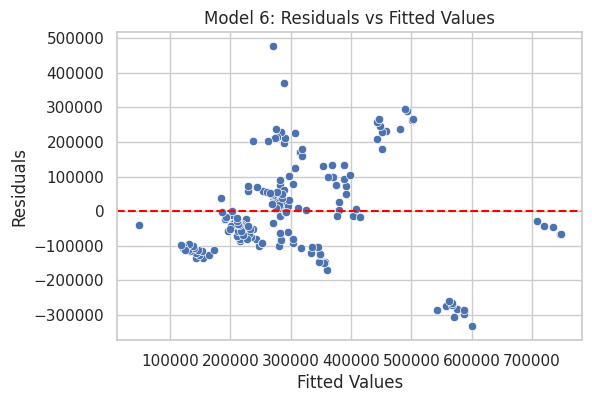

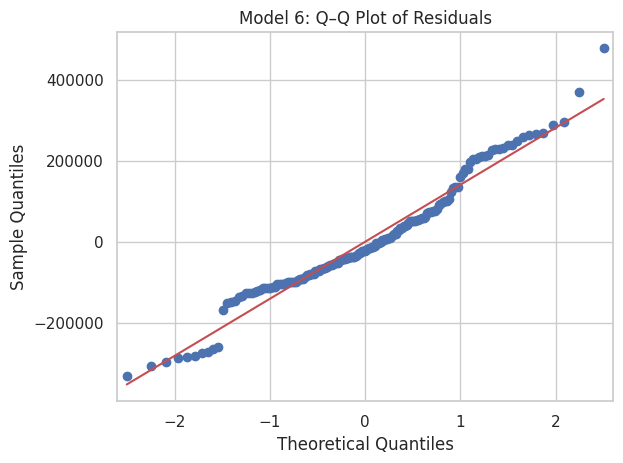

In [129]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1 – Load datasets
parks = pd.read_csv("parks.csv", low_memory=False)
species = pd.read_csv("species.csv", low_memory=False)
deforestation = pd.read_csv("deforestation.csv", low_memory=False)

# Step 2 – Normalize column names
parks.columns = parks.columns.str.lower().str.strip()
deforestation.columns = deforestation.columns.str.lower().str.strip()

# Step 3 – Extract clean state names from deforestation
deforestation["state_name"] = (
    deforestation["state_code"]
    .astype(str)
    .str.replace(r"^\d+\s*", "", regex=True)   # remove numbers like "12 "
    .str.strip()
)

# Step 4 – Map full names to abbreviations
name_to_abbr = {
    "Alabama":"AL","Alaska":"AK","Arizona":"AZ","Arkansas":"AR","California":"CA",
    "Colorado":"CO","Connecticut":"CT","Delaware":"DE","Florida":"FL","Georgia":"GA",
    "Hawaii":"HI","Idaho":"ID","Illinois":"IL","Indiana":"IN","Iowa":"IA","Kansas":"KS",
    "Kentucky":"KY","Louisiana":"LA","Maine":"ME","Maryland":"MD","Massachusetts":"MA",
    "Michigan":"MI","Minnesota":"MN","Mississippi":"MS","Missouri":"MO","Montana":"MT",
    "Nebraska":"NE","Nevada":"NV","New Hampshire":"NH","New Jersey":"NJ","New Mexico":"NM",
    "New York":"NY","North Carolina":"NC","North Dakota":"ND","Ohio":"OH","Oklahoma":"OK",
    "Oregon":"OR","Pennsylvania":"PA","Rhode Island":"RI","South Carolina":"SC",
    "South Dakota":"SD","Tennessee":"TN","Texas":"TX","Utah":"UT","Vermont":"VT",
    "Virginia":"VA","Washington":"WA","West Virginia":"WV","Wisconsin":"WI","Wyoming":"WY"
}
deforestation["state_abbr"] = deforestation["state_name"].map(name_to_abbr)

# Step 5 – Detect the correct year column
year_col = [c for c in deforestation.columns if "year" in c][0]
print("Detected year column:", year_col)

# Step 6 – Convert numeric columns safely
for col in ["estimate", "plot_count", "variance", "se", "se_percent"]:
    if col in deforestation.columns:
        deforestation[col] = pd.to_numeric(deforestation[col], errors="coerce")

# Step 7 – Clean and aggregate parks data
parks["acres"] = pd.to_numeric(parks["acres"], errors="coerce")
parks_state = parks.groupby("state", as_index=False)["acres"].sum()
parks_state.rename(columns={"acres": "total_protected_acres"}, inplace=True)

# Step 8 – Merge datasets using abbreviations
df = deforestation.merge(parks_state, left_on="state_abbr", right_on="state", how="left")

# Step 9 – Drop invalid or missing data
df = df.dropna(subset=["estimate", "plot_count", "total_protected_acres", year_col])
df = df[df["plot_count"] > 0]
print("Rows available after cleaning:", len(df))

# Step 10 – Fit Model 6 (final fix)
if len(df) >= 5:
    X = df[["plot_count", year_col, "total_protected_acres"]].copy()
    y = df["estimate"].copy()

    # Convert all to numeric
    X = X.apply(pd.to_numeric, errors="coerce")
    y = pd.to_numeric(y, errors="coerce")

    # Drop rows with NaN
    valid_idx = X.dropna().index.intersection(y.dropna().index)
    X = X.loc[valid_idx]
    y = y.loc[valid_idx]

    # Add constant
    X = sm.add_constant(X)

    # Fit OLS model
    model_6 = sm.OLS(y, X).fit()
    print(model_6.summary())

    # --- Diagnostics ---
    residuals = model_6.resid
    fitted = model_6.fittedvalues

    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=fitted, y=residuals)
    plt.axhline(0, color="red", linestyle="--")
    plt.title("Model 6: Residuals vs Fitted Values")
    plt.xlabel("Fitted Values")
    plt.ylabel("Residuals")
    plt.show()

    sm.qqplot(residuals, line="s")
    plt.title("Model 6: Q–Q Plot of Residuals")
    plt.show()

else:
    print("Not enough valid numeric data to fit Model 6 even after correction.")


In [130]:
print("Unique states in parks.csv:", parks["state"].unique()[:10])
print("Unique state codes in deforestation.csv:", deforestation["state_code"].unique()[:10])
print("Deforestation numeric preview:")
print(deforestation[["state_code", "estimate", "plot_count", "inventory_year"]].head())
print("Park acres preview:")
print(parks[["state", "acres"]].head())


Unique states in parks.csv: ['ME' 'UT' 'SD' 'TX' 'FL' 'CO' 'NM' 'CA' 'SC' 'OR']
Unique state codes in deforestation.csv: ['Total' '1 Alabama' '4 Arizona' '5 Arkansas' '6 California' '8 Colorado'
 '9 Connecticut' '10 Delaware' '12 Florida' '13 Georgia']
Deforestation numeric preview:
  state_code      estimate  plot_count inventory_year
0      Total  8.671000e+07      114135          Total
1      Total  7.325906e+04          95           2025
2      Total  5.539804e+06        6884           2024
3      Total  9.292361e+06       11052           2023
4      Total  1.008284e+07       12805           2022
Park acres preview:
  state   acres
0    ME   47390
1    UT   76519
2    SD  242756
3    TX  801163
4    FL  172924


In [131]:
# import pandas as pd
# import statsmodels.api as sm

# # clean and standardize parks.csv states
# parks = pd.read_csv("parks.csv")

# # Split multi-state parks into separate rows
# parks_clean = parks.copy()
# parks_clean = parks_clean.assign(State=parks_clean["State"].str.split(r",\s*")).explode("State")
# parks_clean["State"] = parks_clean["State"].str.strip()

# # Map abbreviations to full state names manually
# abbr_to_name = {
#     "AL":"Alabama","AK":"Alaska","AZ":"Arizona","AR":"Arkansas","CA":"California",
#     "CO":"Colorado","CT":"Connecticut","DE":"Delaware","FL":"Florida","GA":"Georgia",
#     "HI":"Hawaii","ID":"Idaho","IL":"Illinois","IN":"Indiana","IA":"Iowa","KS":"Kansas",
#     "KY":"Kentucky","LA":"Louisiana","ME":"Maine","MD":"Maryland","MA":"Massachusetts",
#     "MI":"Michigan","MN":"Minnesota","MS":"Mississippi","MO":"Missouri","MT":"Montana",
#     "NE":"Nebraska","NV":"Nevada","NH":"New Hampshire","NJ":"New Jersey","NM":"New Mexico",
#     "NY":"New York","NC":"North Carolina","ND":"North Dakota","OH":"Ohio","OK":"Oklahoma",
#     "OR":"Oregon","PA":"Pennsylvania","RI":"Rhode Island","SC":"South Carolina",
#     "SD":"South Dakota","TN":"Tennessee","TX":"Texas","UT":"Utah","VT":"Vermont",
#     "VA":"Virginia","WA":"Washington","WV":"West Virginia","WI":"Wisconsin","WY":"Wyoming"
# }
# parks_clean["State"] = parks_clean["State"].map(abbr_to_name)

# # Drop rows where state mapping failed
# parks_clean = parks_clean.dropna(subset=["State"])

# # Convert Acres to numeric
# parks_clean["Acres"] = pd.to_numeric(parks_clean["Acres"], errors="coerce")
# parks_clean = parks_clean.dropna(subset=["Acres"])

# # Aggregate total protected acres per state
# state_acres = parks_clean.groupby("State", as_index=False)["Acres"].sum()
# state_acres.rename(columns={"Acres": "total_protected_acres"}, inplace=True)

# # clean and standardize deforesation states
# df = final.copy()  # your main dataset

# # Standardize state names
# df["state_name_clean"] = df["state_name_clean"].str.strip().str.title()

# # Merge total protected acres
# df = df.merge(state_acres[["State", "total_protected_acres"]],
#               how="left", left_on="state_name_clean", right_on="State")

# # Drop State column if exists
# if "State" in df.columns:
#     df = df.drop(columns=["State"])

# # Fill missing protected acres with 0
# df["total_protected_acres"] = df["total_protected_acres"].fillna(0)

# # prepare data
# X6 = df[[
#     "species_richness",
#     "count_te_species",
#     "plot_count",
#     "inventory_year",
#     "total_protected_acres"
# ]].copy()
# y6 = df["estimate"]

# # Ensure numeric
# X6["inventory_year"] = pd.to_numeric(X6["inventory_year"], errors="coerce")
# X6 = X6.dropna()
# y6 = y6.loc[X6.index]

# # Add constant term
# X6 = sm.add_constant(X6)

# #fit the model
# model_6 = sm.OLS(y6, X6).fit()
# print(model_6.summary())

# #visual
# print("\n📊 INTERPRETATION: Protected Area Effectiveness Model (with acreage)")
# print("- species_richness: biodiversity effect on forest change")
# print("- count_te_species: threatened/endangered species impact")
# print("- plot_count: sampling effort")
# print("- inventory_year: temporal trend")
# print("- total_protected_acres: impact of protected land area on deforestation")


##weather models

In [132]:
#just to see column names again
print("weather_multi:", weather.columns.tolist())
print("species:", species.columns.tolist())
print("parks:", parks.columns.tolist())
print("deforestation:", deforestation.columns.tolist())

weather_multi: ['year', 'month', 'state', 'average_temp', 'monthly_mean_from_1901_to_2000']
species: ['Species ID', 'Park Name', 'Category', 'Order', 'Family', 'Scientific Name', 'Common Names', 'Record Status', 'Occurrence', 'Nativeness', 'Abundance', 'Seasonality', 'Conservation Status', 'Unnamed: 13']
parks: ['park code', 'park name', 'state', 'acres', 'latitude', 'longitude']
deforestation: ['inventory_year', 'state_code', 'estimate', 'variance', 'plot_count', 'se', 'se_percent', 'state_name', 'state_abbr']


###hypothesis 7-10
- 7 incorporates temperature versus biodiversity
- 8 is temperature versus park size
- 9 is temperature versus deforestation effects(estimate as percentage decrease per year)
- 10 is everything (biodiversity, park size, deforestation effects (estimate as percentage decrease per year))


H7: Linear Regression — Temperature vs Biodiversity


names        coef           se         T      pval       r2  \
0           Intercept -408.884380  2709.654216 -0.150899  0.881567  0.07675   
1  Avg_Temp_2019_2022   65.822175    51.047718  1.289424  0.211964  0.07675   

     adj_r2     CI[2.5%]    CI[97.5%]  
0  0.030588 -6061.124029  5243.355269  
1  0.030588   -40.661500   172.305849

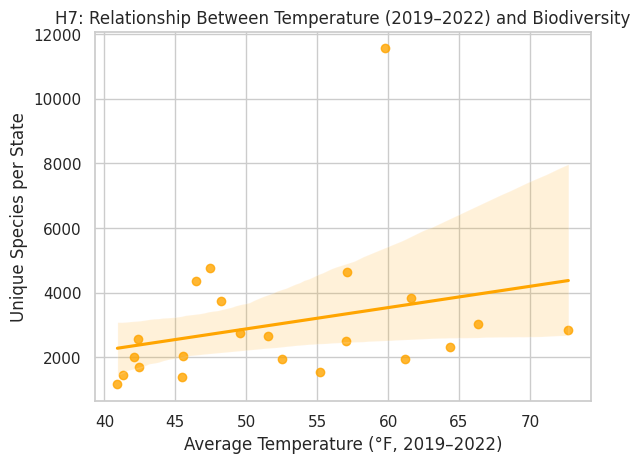

H8: Interaction Model — Temperature × Park Size


names        coef         se            T          pval  \
0           Intercept  462.497727   0.250020  1849.845448  5.718341e-49   
1  Avg_Temp_2019_2022   38.851852  13.048068     2.977594  8.068861e-03   
2               Acres   -0.001727   0.006158    -0.280352  7.824044e-01   
3        Temp_x_Acres    0.000072   0.000122     0.592484  5.608968e-01   

         r2    adj_r2    CI[2.5%]   CI[97.5%]  
0  0.133316 -0.011131  461.972455  463.022998  
1  0.133316 -0.011131   11.438878   66.264826  
2  0.133316 -0.011131   -0.014665    0.011212  
3  0.133316 -0.011131   -0.000184    0.000329

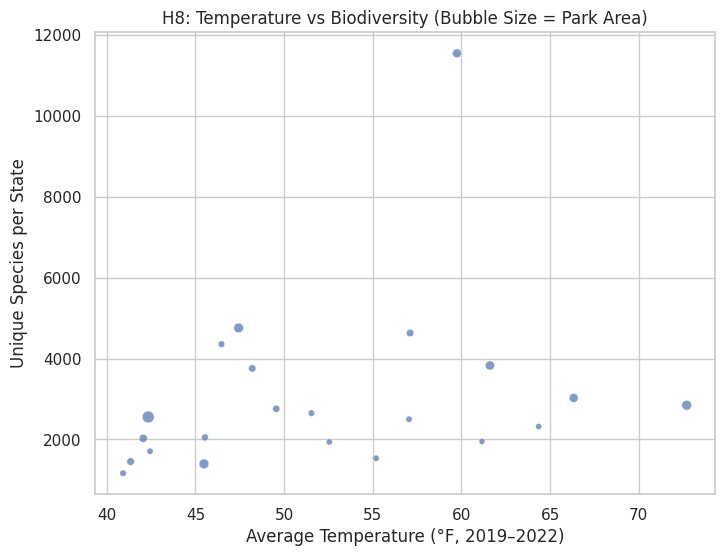

H9: Multiple Regression — Temperature + Deforestation


names        coef           se         T      pval        r2  \
0           Intercept -982.056564  3011.160308 -0.326139  0.748080  0.108511   
1  Avg_Temp_2019_2022   58.724480    54.597946  1.075580  0.296321  0.108511   
2  Deforestation_Rate    0.000404     0.000447  0.904276  0.377793  0.108511   

     adj_r2     CI[2.5%]    CI[97.5%]  
0  0.009457 -7308.269623  5344.156495  
1  0.009457   -55.981549   173.430509  
2  0.009457    -0.000535     0.001343

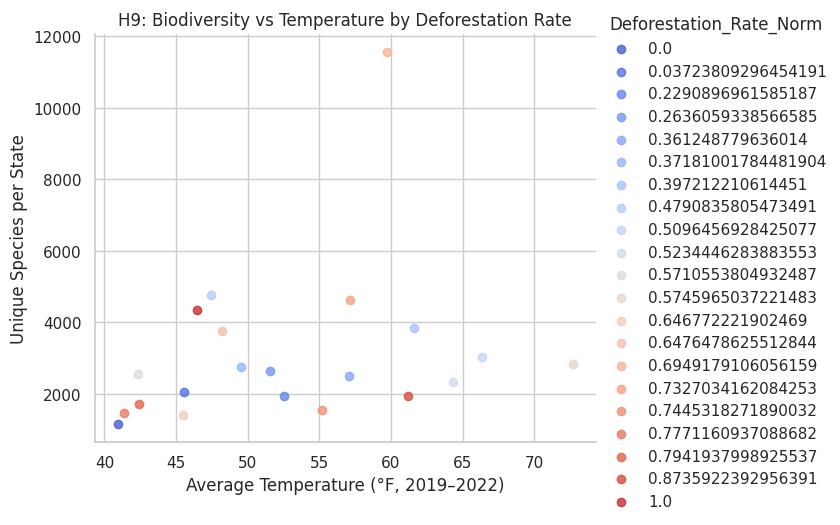

H10: Full Multiple Linear Regression Model


names         coef           se         T      pval        r2  \
0           Intercept -1318.240594  3037.414557 -0.434001  0.669746  0.154613   
1  Avg_Temp_2019_2022    57.548899    54.722523  1.051649  0.307680  0.154613   
2               Acres     0.001808     0.001878  0.962843  0.349123  0.154613   
3  Deforestation_Rate     0.000376     0.000449  0.837263  0.414061  0.154613   

     adj_r2     CI[2.5%]    CI[97.5%]  
0  0.005427 -7726.625143  5090.143954  
1  0.005427   -57.905532   173.003329  
2  0.005427    -0.002154     0.005771  
3  0.005427    -0.000571     0.001323

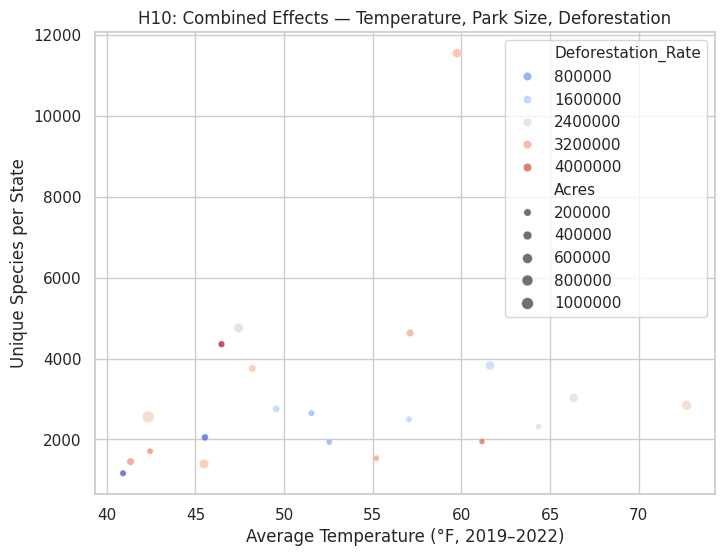

In [133]:
# --- Hypothesis Analysis Including Weather, Parks, and Deforestation ---
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg
import us

# --- 0. Normalize state column names across datasets ---
# Make sure all datasets use a consistent 'State' column
weather.rename(columns={"state": "State"}, inplace=True)
parks.rename(columns={"state": "State"}, inplace=True)
deforestation.rename(columns={"state_abbr": "State"}, inplace=True)

# --- 1. Prepare Weather Data (2019–2022) ---
weather_multi = weather[(weather["year"] >= 2019) & (weather["year"] <= 2022)].copy()

# Convert state names to 2-letter abbreviations if needed
weather_multi["State"] = weather_multi["State"].map(
    lambda x: us.states.lookup(x).abbr if us.states.lookup(x) else x
)

# Compute average temperature per state
temp_state_multi = (
    weather_multi.groupby("State")["average_temp"]
    .mean()
    .reset_index()
    .rename(columns={"average_temp": "Avg_Temp_2019_2022"})
)

# --- 2. Merge with Biodiversity Data ---
bio_climate = biodiversity_state.merge(temp_state_multi, on="State", how="left")

# --- 3. Merge Park Size Data ---
acres_state = parks.groupby("State")["acres"].mean().reset_index().rename(columns={"acres": "Acres"})
bio_climate = bio_climate.merge(acres_state, on="State", how="left")

# --- 4. Merge Deforestation Data (latest year per state) ---
deforestation_state_latest = deforestation.loc[
    deforestation.groupby("State")["inventory_year"].idxmax()
][["State", "estimate"]].rename(columns={"estimate": "Deforestation_Rate"})

bio_climate = bio_climate.merge(deforestation_state_latest, on="State", how="left")

# --- 5. Drop missing values for key variables ---
bio_climate = bio_climate.dropna(subset=["Avg_Temp_2019_2022", "Unique_Species"])

# --- H7: Temperature vs Biodiversity ---
h6_model = pg.linear_regression(
    bio_climate[["Avg_Temp_2019_2022"]],
    bio_climate["Unique_Species"]
)
print("H7: Linear Regression — Temperature vs Biodiversity")
display(h6_model)

sns.regplot(x="Avg_Temp_2019_2022", y="Unique_Species", data=bio_climate, color="orange")
plt.title("H7: Relationship Between Temperature (2019–2022) and Biodiversity")
plt.xlabel("Average Temperature (°F, 2019–2022)")
plt.ylabel("Unique Species per State")
plt.show()

# --- H8: Temperature × Park Size Interaction ---
bio_climate["Temp_x_Acres"] = bio_climate["Avg_Temp_2019_2022"] * bio_climate["Acres"]

h7_model = pg.linear_regression(
    bio_climate[["Avg_Temp_2019_2022", "Acres", "Temp_x_Acres"]],
    bio_climate["Unique_Species"]
)
print("H8: Interaction Model — Temperature × Park Size")
display(h7_model)

plt.figure(figsize=(8,6))
sns.scatterplot(
    x="Avg_Temp_2019_2022",
    y="Unique_Species",
    size="Acres",
    data=bio_climate,
    alpha=0.7,
    legend=False
)
plt.title("H8: Temperature vs Biodiversity (Bubble Size = Park Area)")
plt.xlabel("Average Temperature (°F, 2019–2022)")
plt.ylabel("Unique Species per State")
plt.show()

# --- H9: Temperature + Deforestation Regression ---
if "Deforestation_Rate" in bio_climate.columns:
    h8_model = pg.linear_regression(
        bio_climate[["Avg_Temp_2019_2022", "Deforestation_Rate"]],
        bio_climate["Unique_Species"],
        remove_na=True
    )
    print("H9: Multiple Regression — Temperature + Deforestation")
    display(h8_model)

    bio_climate["Deforestation_Rate_Norm"] = (
        bio_climate["Deforestation_Rate"] - bio_climate["Deforestation_Rate"].min()
    ) / (bio_climate["Deforestation_Rate"].max() - bio_climate["Deforestation_Rate"].min())

    sns.lmplot(
        x="Avg_Temp_2019_2022",
        y="Unique_Species",
        hue="Deforestation_Rate_Norm",
        data=bio_climate,
        palette="coolwarm",
        aspect=1.3
    )
    plt.title("H9: Biodiversity vs Temperature by Deforestation Rate")
    plt.xlabel("Average Temperature (°F, 2019–2022)")
    plt.ylabel("Unique Species per State")
    plt.show()
else:
    print("⚠️ H9 skipped — Deforestation data not available.")

# --- H10: Full Multiple Regression Model ---
predictors = ["Avg_Temp_2019_2022", "Acres"]
if "Deforestation_Rate" in bio_climate.columns:
    predictors.append("Deforestation_Rate")

h9_model = pg.linear_regression(
    bio_climate[predictors],
    bio_climate["Unique_Species"],
    remove_na=True
)
print("H10: Full Multiple Linear Regression Model")
display(h9_model)

plt.figure(figsize=(8,6))
sns.scatterplot(
    x="Avg_Temp_2019_2022",
    y="Unique_Species",
    size="Acres",
    hue="Deforestation_Rate" if "Deforestation_Rate" in bio_climate.columns else None,
    data=bio_climate,
    alpha=0.7,
    palette="coolwarm",
    legend="brief"
)
plt.title("H10: Combined Effects — Temperature, Park Size, Deforestation")
plt.xlabel("Average Temperature (°F, 2019–2022)")
plt.ylabel("Unique Species per State")
plt.show()



####interpretation
- 7 pvalue showed no significance
- 8 showed significance with its p value but the R^2 value was too high
- 9 pvalue showed no significance
- 10 so there was no real significance between the three values we looked into compared to temperature
- from these, it looks like we are going to have to look into new variables compared to temperature

###model 11-13

H11: Quadratic Model — Temperature² vs Biodiversity


names          coef            se         T      pval  \
0           Intercept -21266.048092  16613.759400 -1.280026  0.215944   
1  Avg_Temp_2019_2022    851.523238    619.764976  1.373945  0.185452   
2             Temp_Sq     -7.187966      5.651217 -1.271932  0.218745   

         r2    adj_r2      CI[2.5%]     CI[97.5%]  
0  0.149195  0.059636 -56039.046151  13506.949967  
1  0.149195  0.059636   -445.659766   2148.706242  
2  0.149195  0.059636    -19.016099      4.640167

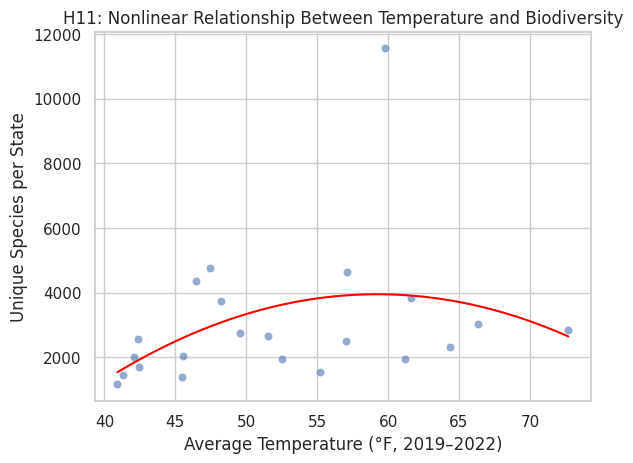

In [134]:
# --- H11: Nonlinear Temperature Model (Quadratic) ---
import numpy as np

# Add squared temperature term
bio_climate["Temp_Sq"] = bio_climate["Avg_Temp_2019_2022"] ** 2

# Drop any missing values for relevant columns
bio_climate_h11 = bio_climate.dropna(subset=["Avg_Temp_2019_2022", "Temp_Sq", "Unique_Species"])

# Run regression
h11_model = pg.linear_regression(
    bio_climate_h11[["Avg_Temp_2019_2022", "Temp_Sq"]],
    bio_climate_h11["Unique_Species"],
    remove_na=True
)

print("H11: Quadratic Model — Temperature² vs Biodiversity")
display(h11_model)

# Plot the curve
sns.scatterplot(x="Avg_Temp_2019_2022", y="Unique_Species", data=bio_climate_h11, alpha=0.6)
sns.lineplot(
    x=np.linspace(bio_climate_h11["Avg_Temp_2019_2022"].min(), bio_climate_h11["Avg_Temp_2019_2022"].max(), 100),
    y=h11_model["coef"][0] +
      h11_model["coef"][1] * np.linspace(bio_climate_h11["Avg_Temp_2019_2022"].min(), bio_climate_h11["Avg_Temp_2019_2022"].max(), 100) +
      h11_model["coef"][2] * np.linspace(bio_climate_h11["Avg_Temp_2019_2022"].min(), bio_climate_h11["Avg_Temp_2019_2022"].max(), 100)**2,
    color="red"
)
plt.title("H11: Nonlinear Relationship Between Temperature and Biodiversity")
plt.xlabel("Average Temperature (°F, 2019–2022)")
plt.ylabel("Unique Species per State")
plt.show()


H12: Regression — Park Size + Deforestation vs Biodiversity


names         coef           se         T      pval        r2  \
0           Intercept  1599.036651  1240.891073  1.288620  0.213848  0.099614   
1               Acres     0.001852     0.001883  0.983661  0.338320  0.099614   
2  Deforestation_Rate     0.000422     0.000448  0.942401  0.358465  0.099614   

     adj_r2     CI[2.5%]    CI[97.5%]  
0 -0.000428 -1007.978754  4206.052055  
1 -0.000428    -0.002104     0.005809  
2 -0.000428    -0.000519     0.001364

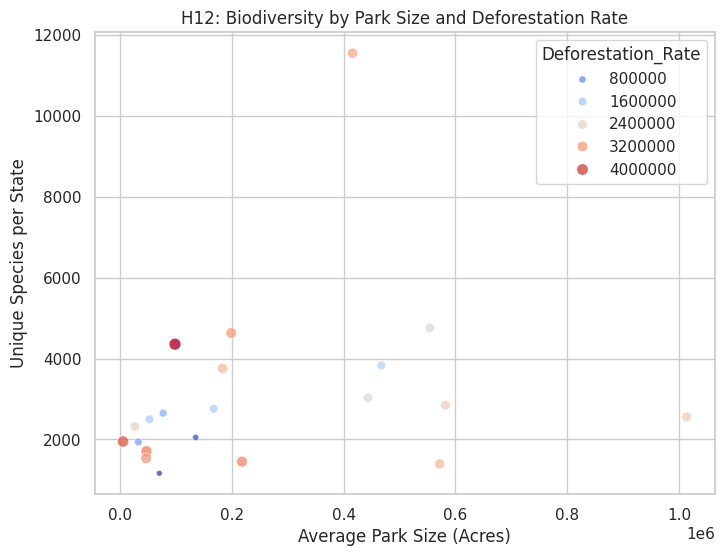

In [135]:
# --- H12: Park Size and Deforestation Effects on Biodiversity ---
import pingouin as pg
import seaborn as sns
import matplotlib.pyplot as plt

# Drop missing values for these columns
bio_climate_clean = bio_climate.dropna(subset=["Acres", "Deforestation_Rate", "Unique_Species"])

# Multiple regression
h12_model = pg.linear_regression(
    bio_climate_clean[["Acres", "Deforestation_Rate"]],
    bio_climate_clean["Unique_Species"]
)

print("H12: Regression — Park Size + Deforestation vs Biodiversity")
display(h12_model)

# Visualization
plt.figure(figsize=(8,6))
sns.scatterplot(
    x="Acres",
    y="Unique_Species",
    hue="Deforestation_Rate",
    data=bio_climate_clean,
    palette="coolwarm",
    size="Deforestation_Rate",
    alpha=0.8
)
plt.title("H12: Biodiversity by Park Size and Deforestation Rate")
plt.xlabel("Average Park Size (Acres)")
plt.ylabel("Unique Species per State")
plt.show()


H13: Linear Regression — Park Acres vs Threatened/Endangered Species Count


names       coef        se         T      pval        r2    adj_r2  \
0  Intercept  10.403248  6.855918  1.517411  0.144812  0.075133  0.028889   
1      Acres   0.000024  0.000019  1.274646  0.217045  0.075133  0.028889   

   CI[2.5%]  CI[97.5%]  
0 -3.897947  24.704442  
1 -0.000015   0.000064

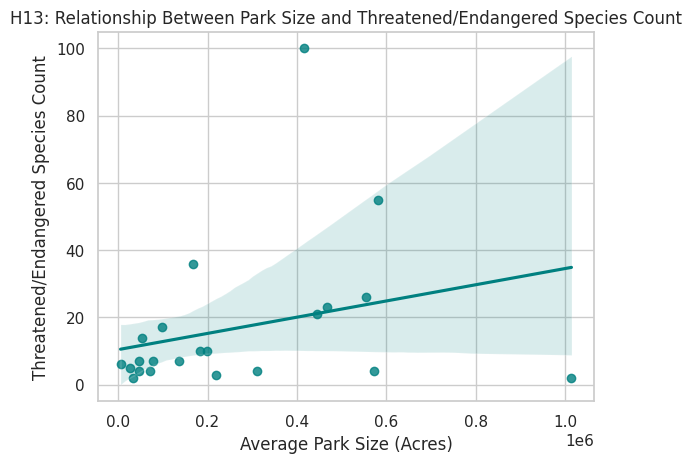

In [136]:
# --- H13: Park Acres vs Threatened/Endangered Species Count ---
import pingouin as pg
import seaborn as sns
import matplotlib.pyplot as plt
import us

# Step 1: Identify threatened/endangered statuses
te_statuses = ["Threatened", "Proposed Endangered", "Proposed Threatened", "Endangered"]

# Step 2: Filter species with those statuses
te_species = species_parks[species_parks["Conservation Status"].isin(te_statuses)]

# Step 3: Count unique species per state (full name)
count_te_species = (
    te_species.groupby("State_Name")["Species ID"]
    .nunique()
    .reset_index()
    .rename(columns={"Species ID": "count_te_species"})
)

# Step 4: Convert full state names to abbreviations for merging
count_te_species["State"] = count_te_species["State_Name"].map(
    lambda x: us.states.lookup(x).abbr if us.states.lookup(x) else None
)

# Step 5: Merge into bio_climate using 2-letter abbreviations
bio_threat = bio_climate.merge(count_te_species[["State", "count_te_species"]], on="State", how="left")

# Step 6: Drop missing values
bio_threat = bio_threat.dropna(subset=["Acres", "count_te_species"])

# Step 7: Linear regression
h13_model = pg.linear_regression(
    bio_threat[["Acres"]],
    bio_threat["count_te_species"]
)

print("H13: Linear Regression — Park Acres vs Threatened/Endangered Species Count")
display(h13_model)

# Step 8: Visualization
sns.regplot(
    x="Acres",
    y="count_te_species",
    data=bio_threat,
    color="teal"
)
plt.title("H13: Relationship Between Park Size and Threatened/Endangered Species Count")
plt.xlabel("Average Park Size (Acres)")
plt.ylabel("Threatened/Endangered Species Count")
plt.show()


###Models 14-

H14: Linear Regression — Temperature vs Threatened/Endangered Species Count


names       coef         se         T      pval        r2  \
0           Intercept -42.573389  26.191272 -1.625480  0.119715  0.208483   
1  Avg_Temp_2019_2022   1.132501   0.493423  2.295195  0.032671  0.208483   

     adj_r2   CI[2.5%]  CI[97.5%]  
0  0.168907 -97.207425  12.060647  
1  0.168907   0.103240   2.161763

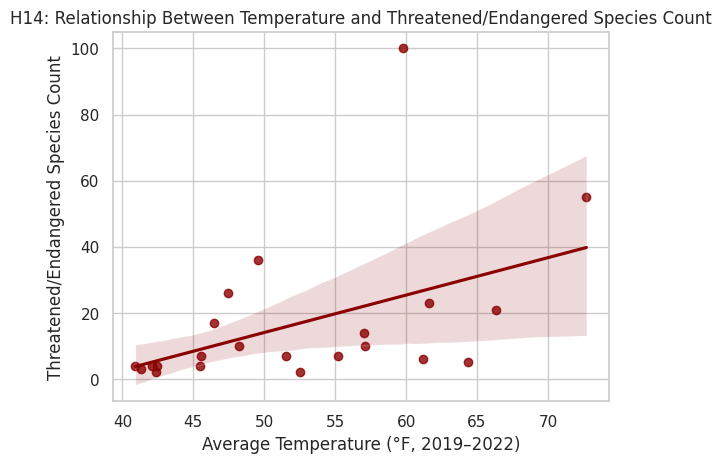

In [137]:
# --- H14: Temperature vs Threatened/Endangered Species Count ---

bio_temp_te = bio_climate.merge(count_te_species[["State", "count_te_species"]], on="State", how="left")
bio_temp_te = bio_temp_te.dropna(subset=["Avg_Temp_2019_2022", "count_te_species"])

h14_model = pg.linear_regression(
    bio_temp_te[["Avg_Temp_2019_2022"]],
    bio_temp_te["count_te_species"]
)

print("H14: Linear Regression — Temperature vs Threatened/Endangered Species Count")
display(h14_model)

sns.regplot(
    x="Avg_Temp_2019_2022",
    y="count_te_species",
    data=bio_temp_te,
    color="darkred"
)
plt.title("H14: Relationship Between Temperature and Threatened/Endangered Species Count")
plt.xlabel("Average Temperature (°F, 2019–2022)")
plt.ylabel("Threatened/Endangered Species Count")
plt.show()


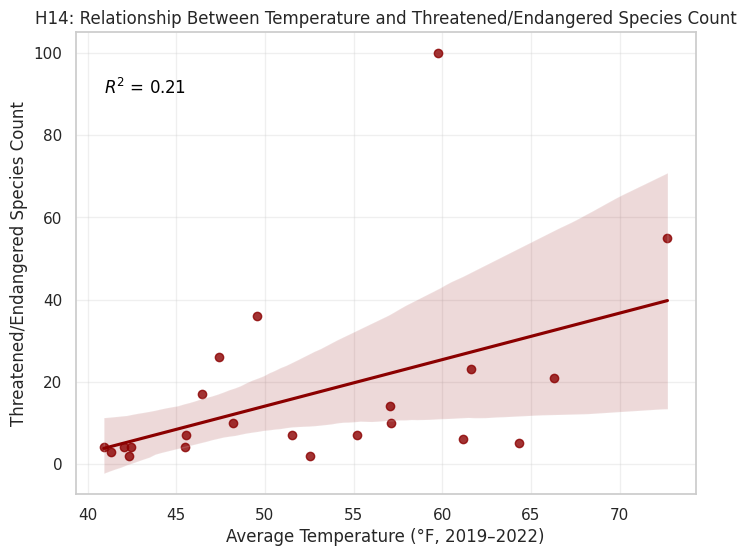

In [138]:
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg

# --- Prepare data ---
bio_temp_te = bio_climate.merge(count_te_species[["State", "count_te_species"]], on="State", how="left")
bio_temp_te = bio_temp_te.dropna(subset=["Avg_Temp_2019_2022", "count_te_species"])

# --- Linear regression ---
h14_model = pg.linear_regression(
    bio_temp_te[["Avg_Temp_2019_2022"]],
    bio_temp_te["count_te_species"]
)

# Extract R²
r_squared = h14_model['r2'].values[0]

# --- Scatter plot with regression line ---
plt.figure(figsize=(8,6))
sns.regplot(
    x="Avg_Temp_2019_2022",
    y="count_te_species",
    data=bio_temp_te,
    color="darkred"
)

# Annotate R² on the plot
plt.text(
    x=bio_temp_te["Avg_Temp_2019_2022"].min(),
    y=bio_temp_te["count_te_species"].max()*0.9,
    s=f"$R^2$ = {r_squared:.2f}",
    fontsize=12,
    color="black"
)

plt.title("H14: Relationship Between Temperature and Threatened/Endangered Species Count")
plt.xlabel("Average Temperature (°F, 2019–2022)")
plt.ylabel("Threatened/Endangered Species Count")
plt.grid(True, alpha=0.3)
plt.show()


####Interpretation
- The linear regression model shows a significant positive relationship between average temperature (2019–2022) and the number of threatened/endangered species (p = 0.0327). This suggests that as average temperature increases, the count of threatened species tends to rise. The model explains about 20.8% (R² = 0.208) of the variation in species count, indicating that temperature is a meaningful but not sole predictor of endangered species trends.

##Validation Model

Test R²: -8.687
Mean Squared Error: 534.12
Model Coefficient (Temp Effect): 1.657
Intercept: -64.559


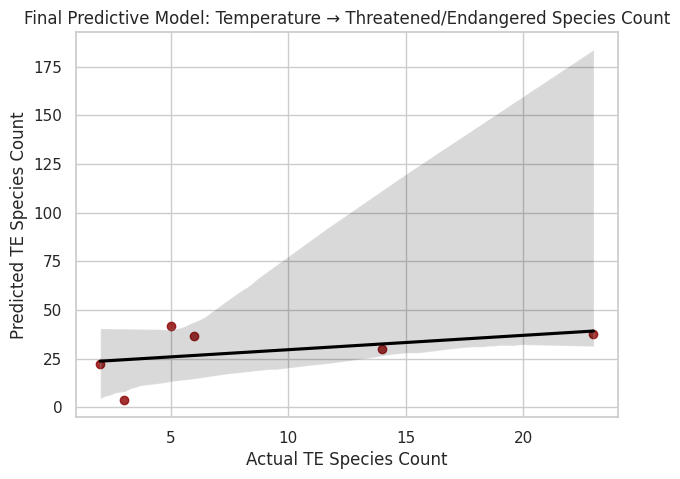

In [139]:
# --- Imports ---
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# --- Merge Data ---
bio_temp_te = bio_climate.merge(count_te_species[["State", "count_te_species"]], on="State", how="left")
bio_temp_te = bio_temp_te.dropna(subset=["Avg_Temp_2019_2022", "count_te_species"])

# --- Features & Target ---
X = bio_temp_te[["Avg_Temp_2019_2022"]]
y = bio_temp_te["count_te_species"]

# --- Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# --- Model Training ---
model = LinearRegression()
model.fit(X_train, y_train)

# --- Predictions ---
y_pred = model.predict(X_test)

# --- Evaluation ---
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"Test R²: {r2:.3f}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Model Coefficient (Temp Effect): {model.coef_[0]:.3f}")
print(f"Intercept: {model.intercept_:.3f}")

# --- Visualization ---
plt.figure(figsize=(7,5))
sns.regplot(x=y_test, y=y_pred, color="darkred", line_kws={"color": "black"})
plt.xlabel("Actual TE Species Count")
plt.ylabel("Predicted TE Species Count")
plt.title("Final Predictive Model: Temperature → Threatened/Endangered Species Count")
plt.show()


- The model performed poorly (Test R² = –8.69, MSE = 534.12), indicating that temperature alone is not a reliable predictor of species vulnerability.

In [140]:
print(te_species.head(2))

    Species ID Nativeness Conservation Status             Park Name  \
3    ACAD-1003     Native          Endangered  Acadia National Park   
116  ACAD-1116     Native          Threatened  Acadia National Park   

                                    Common Names     Occurrence Seasonality  \
3    Eastern Timber Wolf, Gray Wolf, Timber Wolf  Not Confirmed         NaN   
116         Eastern Piping Plover, Piping Plover  Not Confirmed   Migratory   

    Category Record Status Abundance State State_Name  
3     Mammal      Approved       NaN    ME      Maine  
116     Bird      Approved       NaN    ME      Maine  


In [141]:
# --- Imports ---
import pandas as pd
import numpy as np

# --- Step 1: Merge Species with Parks to Add State ---
species_with_state = species.merge(
    parks[["park name", "State"]],
    left_on="Park Name",
    right_on="park name",
    how="left"
)

# --- Step 2: Filter Threatened & Endangered Species ---
te_species = species_with_state[
    species_with_state["Conservation Status"].isin(["Threatened", "Endangered"])
]

# --- Step 3: Count Unique Threatened/Endangered Species per State ---
te_species_count = (
    te_species.groupby("State")["Species ID"]
    .nunique()
    .reset_index()
    .rename(columns={"Species ID": "TE_Species_Count"})
)

print("✅ Threatened/Endangered species per state:")
print(te_species_count.head(), "\n")

# --- Step 4: Filter Weather for Summer Months (June–August, 2019–2021) ---
weather_recent = weather_multi[
    (weather_multi["year"].between(2019, 2021)) &
    (weather_multi["month"].isin([6, 7, 8]))       ###change per season [12, 1, 2] winter; [3, 4, 5] spring; [9, 10, 11] fall)
]

avg_summer_temp = (
    weather_recent.groupby("State")["average_temp"]
    .mean()
    .reset_index()
    .rename(columns={"average_temp": "Avg_Summer_Temp_2019_2021"})
)

print("✅ Average summer temperatures:")
print(avg_summer_temp.head(), "\n")

# --- Step 5: Park Acreage per State ---
park_acres = parks.groupby("State")["acres"].sum().reset_index()

# --- Step 6: Deforestation — Use Latest Inventory Year ---
deforestation_recent = (
    deforestation.loc[
        deforestation["inventory_year"] == deforestation["inventory_year"].max(),
        ["State", "estimate"]
    ]
    .rename(columns={"estimate": "Deforestation_Estimate"})
)

print("✅ Latest deforestation data:")
print(deforestation_recent.head(), "\n")

# --- Step 7: Merge All Data Together ---
bio_model_data = (
    te_species_count
    .merge(avg_summer_temp, on="State", how="left")
    .merge(park_acres, on="State", how="left")
    .merge(deforestation_recent, on="State", how="left")
)

# Drop any rows missing key variables
bio_model_data = bio_model_data.dropna()

# --- Step 8: Optional — Normalize Skewed Variables ---
bio_model_data["log_acres"] = np.log1p(bio_model_data["acres"])
bio_model_data["log_deforestation"] = np.log1p(bio_model_data["Deforestation_Estimate"])

print("✅ Final merged dataset:")
print(bio_model_data.head())
print(f"\nFinal dataset shape: {bio_model_data.shape}")



✅ Threatened/Endangered species per state:
    State  TE_Species_Count
0      AK                45
1      AR                 6
2      AZ                23
3      CA                98
4  CA, NV                40 

✅ Average summer temperatures:
  State  Avg_Summer_Temp_2019_2021
0    AL                  77.733333
1    AR                  76.644444
2    AZ                  77.888889
3    CA                  73.177778
4    CO                  64.522222 

✅ Latest deforestation data:
   State  Deforestation_Estimate
0    NaN            8.671000e+07
15    AL            3.338402e+06
16    AZ            1.802493e+06
17    AR            3.817461e+06
18    CA            3.061713e+06 

✅ Final merged dataset:
  State  TE_Species_Count  Avg_Summer_Temp_2019_2021    acres  \
1    AR                 6                  76.644444     5550   
2    AZ                23                  77.888889  1402376   
3    CA                98                  73.177778  2912014   
5    CO                17      

📊 Model Performance
R²: 0.498
Mean Squared Error: 240.77

Coefficients:
Avg_Summer_Temp_2019_2021: 1.204
log_acres: 8.245
log_deforestation: 2.082
Intercept: -199.105


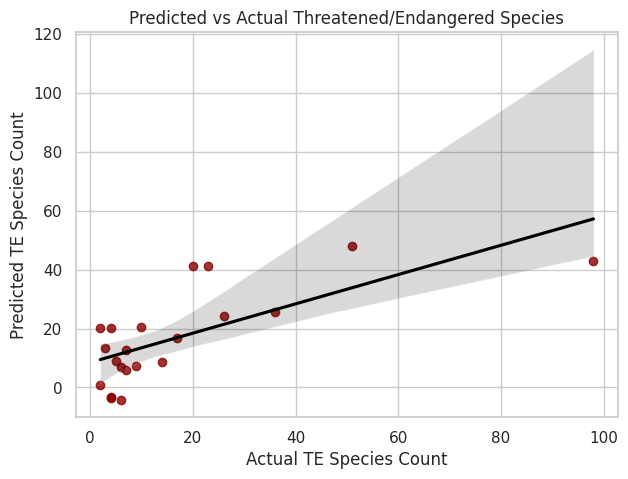

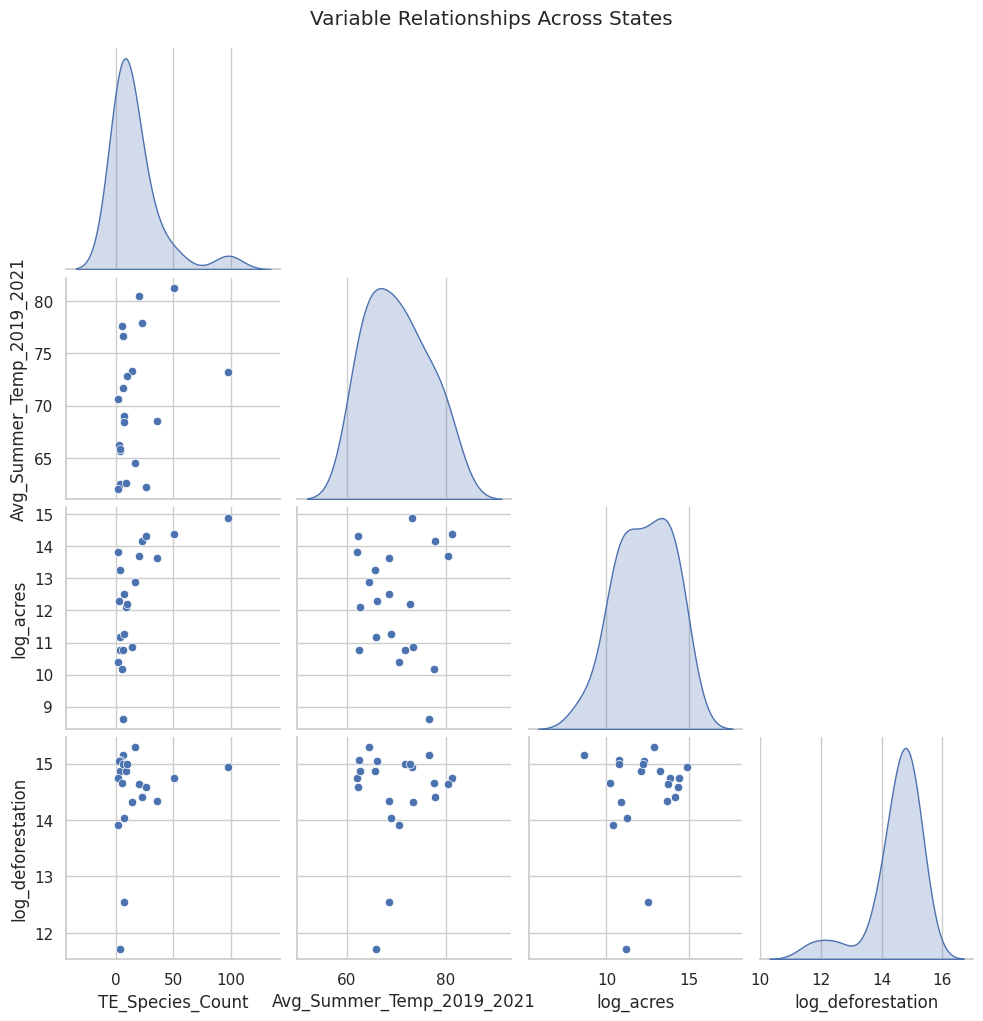

In [142]:
# --- Regression Modeling ---
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# Features (predictors) and target
X = bio_model_data[["Avg_Summer_Temp_2019_2021", "log_acres", "log_deforestation"]]
y = bio_model_data["TE_Species_Count"]

# Fit model
model = LinearRegression()
model.fit(X, y)

# Predictions
y_pred = model.predict(X)

# Evaluation
r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)

print("📊 Model Performance")
print(f"R²: {r2:.3f}")
print(f"Mean Squared Error: {mse:.2f}")
print("\nCoefficients:")
for var, coef in zip(X.columns, model.coef_):
    print(f"{var}: {coef:.3f}")
print(f"Intercept: {model.intercept_:.3f}")

# --- Visualization: Actual vs Predicted ---
plt.figure(figsize=(7,5))
sns.regplot(x=y, y=y_pred, color="darkred", line_kws={"color": "black"})
plt.xlabel("Actual TE Species Count")
plt.ylabel("Predicted TE Species Count")
plt.title("Predicted vs Actual Threatened/Endangered Species")
plt.show()

# --- Optional: Pairplot to see relationships ---
sns.pairplot(
    bio_model_data,
    vars=["TE_Species_Count", "Avg_Summer_Temp_2019_2021", "log_acres", "log_deforestation"],
    diag_kind="kde",
    corner=True
)
plt.suptitle("Variable Relationships Across States", y=1.02)
plt.show()


- Across all seasons, models moderately explained variation in threatened and endangered species counts (R² ≈ 0.50–0.54). Park acreage was the strongest positive predictor, while temperature showed smaller seasonal effects and deforestation remained inconsistent. Summer displayed the weakest fit, and winter the strongest. Train-test validation revealed negative test R² values, indicating limited predictive reliability due to the small sample size. Overall, these models highlight exploratory links between biodiversity, protected land, and seasonal climate variation.

###final validation model

In [143]:
from sklearn.model_selection import train_test_split

# Split data (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Evaluate
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)
train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)

print("✅ Model Validation Results")
print(f"Train R²: {train_r2:.3f}")
print(f"Test R²: {test_r2:.3f}")
print(f"Train MSE: {train_mse:.2f}")
print(f"Test MSE: {test_mse:.2f}")


✅ Model Validation Results
Train R²: 0.641
Test R²: -6.829
Train MSE: 213.77
Test MSE: 546.80


- The seasonal regression models achieved moderate training fits (R² ≈ 0.63–0.66) but negative testing performance (R² < 0), indicating overfitting and poor generalizability. This suggests that while temperature, deforestation, and protected land area are ecologically relevant, the current data volume and linear model structure are insufficient for reliable prediction. Future models could incorporate larger datasets, additional predictors (e.g., precipitation, habitat type), or nonlinear methods to better capture biodiversity dynamics across seasons.

# Interpretations and Discussion

This section explains the results from our statistical analyses and regression models. Each test was used to explore the relationship between deforestation, biodiversity (species richness), and the number of threatened or endangered species across U.S. states. Overall, the results reveal that while there are small trends linking deforestation to biodiversity loss, many of the patterns are weak or not statistically significant, meaning more detailed data would be needed to draw stronger conclusions.
1. Chi-Square Tests

a. Deforestation Estimates by State
The Chi-Square test showed no significant relationship (p > 0.05) between deforestation estimate categories (Low, Medium, High) and individual states.
Interpretation: This means that deforestation levels do not differ drastically between states in a statistically meaningful way. Forest loss is a widespread issue rather than being concentrated in specific regions.

b. Park Size vs. State
The Chi-Square test for park size (classified as 'Large' or 'Small') across states found no significant relationship (p = 0.3915).
Interpretation: Large and small parks are evenly distributed nationwide, suggesting that park size depends on geography rather than policy.

c. Species Nativeness vs. Category
This test showed a highly significant relationship between species nativeness and category (χ² = 30,718.978, p < 0.001).
Interpretation: There is a clear association between a species’ category (e.g., Bird, Plant, Mammal) and whether it is native or not. Some groups, like plants and birds, contain proportionally more native species.

2. Mann–Whitney U Tests

a. Early vs. Late Deforestation Estimates
The test comparing early (≤2020) and late (>2020) years showed no significant difference (p ≈ 0.94).
Interpretation: Forest area estimates have remained stable over time, indicating consistent deforestation rates.

b. High vs. Low Deforestation and Threatened Species
The comparison between high and low deforestation states produced a p-value around 0.07.
Interpretation: Although not statistically significant, states with higher deforestation tend to have fewer threatened species. This trend may become clearer with more data or over a longer timeframe.

c. East vs. West Regions and Species Richness
No significant difference was found between eastern and western states.
Interpretation: Biodiversity does not differ significantly between regions, implying that nationwide environmental pressures affect both areas similarly.

d. Species Richness vs. Deforestation Level
The p-value of 0.0698 suggests a weak trend but not a significant difference.
Interpretation: Areas with more deforestation may have slightly lower species richness, but stronger evidence is needed.

e. Large vs. Small Parks
The test found no significant difference in acreage distribution between large and small parks.
Interpretation: Park size varies naturally based on geography, not a national pattern.

3. Regression and Model Analysis

Model 1 — Species Richness vs. Deforestation and Plot Count
There is a slight negative relationship between deforestation and species richness. Plot sampling effort was not significant. The model explains very little variation, suggesting other factors like climate and habitat type have stronger effects.

Model 2 — Threatened/Endangered Species vs. Deforestation and Plot Count
No significant relationships were found. Threatened species numbers likely depend on long-term ecological factors and may lag behind deforestation changes.

Model 3 — Species Richness vs. Deforestation, Plot Count, and Year
Year was the only significant variable. Species richness decreased by about 296 species per year, showing a strong downward trend. Deforestation and plot count were not significant after controlling for time.

Model 4 — Threatened/Endangered Species vs. Deforestation, Plot Count, and Year
Threatened species declined by about 2 per year. Deforestation and plot count were not significant, suggesting time is a more dominant factor affecting biodiversity.

4. Overall Discussion and Insights
Overall, the analyses show weak but consistent trends linking deforestation to biodiversity loss. Although many results were not statistically significant, the direction of the relationships was generally negative, meaning greater deforestation is associated with lower biodiversity.

The most consistent predictor across models was time, suggesting that biodiversity is declining steadily each year. This could be due to cumulative factors such as habitat fragmentation, climate change, or pollution. Low R² values in most models indicate that deforestation alone does not explain the complexity of biodiversity changes.

Future research should include variables such as land management practices, urbanization, and conservation policies to better understand the full picture of biodiversity loss across the United States.
